In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


Missing Values  % of Total Values
id_24          585793               99.2
id_25          585408               99.1
id_07          585385               99.1
id_08          585385               99.1
id_21          585381               99.1
...               ...                ...
V285               12                0.0
V284               12                0.0
V280               12                0.0
V279               12                0.0
V312               12                0.0

[414 rows x 2 columns]

In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


Missing Values  % of Total Values
id-24          501951               99.1
id-25          501652               99.0
id-26          501644               99.0
id-08          501632               99.0
id-07          501632               99.0
...               ...                ...
V293                3                0.0
C14                 3                0.0
V319                3                0.0
V292                3                0.0
V303                3                0.0

[385 rows x 2 columns]

Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...                    id_31  id_32  \
0       150.0        visa  226.0   debit  ...                      NaN    NaN   
1       150.0        visa  226.0   debit  ...                      NaN    NaN   
2       150.0        visa  226.0   debit  ...                      NaN    NaN   
3       150.0        visa  166.0   debit  ...                      NaN    NaN   
4       150.0  mastercard  117.0   debit  ...                      NaN    NaN   
...       ...         ...    ...     ...  ...                      ...    ...   
506686  185.0  mastercard  224.0   debit  ...                      NaN    NaN   
506687  185.0  mastercard  224.0   debit  ...  chrome 43.0 for android    NaN   
506688  150.0        visa  226.0   debit  ...                      NaN    NaN   
506689  150.0  mastercard  224.0   debit  ...                      NaN    NaN   
506690  144.0        visa  147.0  credit  ...      samsung browser 8.2    NaN   

        id_33  id_34 id_35 id_36  id_37  id_38  DeviceType  \
0         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
1         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
2         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
3         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
4         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
...       ...    ...   ...   ...    ...    ...         ...   
506686    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506687    NaN    NaN     F     F      T      F      mobile   
506688    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506689    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506690    NaN    NaN     F     F      T      F      mobile   

                         DeviceInfo  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
506686                          NaN  
506687  ALE-L23 Build/HuaweiALE-L23  
506688                          NaN  
506689                          NaN  
506690                      SAMSUNG  

[506691 rows x 433 columns]

Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


Missing Values  % of Total Values
M4            281444               47.7
D2            280797               47.5
V7            279287               47.3
V11           279287               47.3
V10           279287               47.3
...              ...                ...
V295              12                0.0
V297              12                0.0
V298              12                0.0
V299              12                0.0
V321              12                0.0

[200 rows x 2 columns]

In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


Missing Values  % of Total Values
M4            237745               46.9
D2            234769               46.3
D3            203142               40.1
M3            176639               34.9
M2            176639               34.9
...              ...                ...
V287               3                0.0
V290               3                0.0
V292               3                0.0
V293               3                0.0
V321               3                0.0

[171 rows x 2 columns]

И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

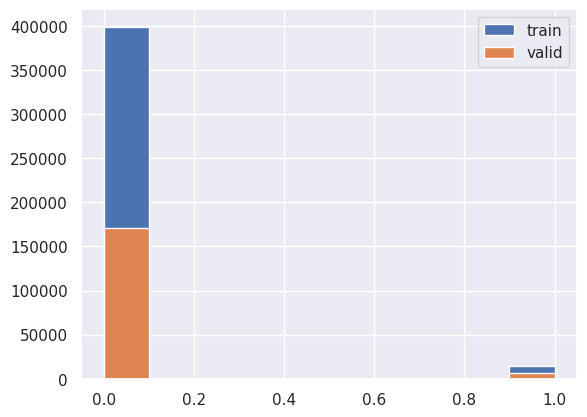

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='valid')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count  Percent
isFraud                 
0        398914  0.96501
1         14464  0.03499

In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count   Percent
isFraud                  
0        170963  0.965009
1          6199  0.034991

Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

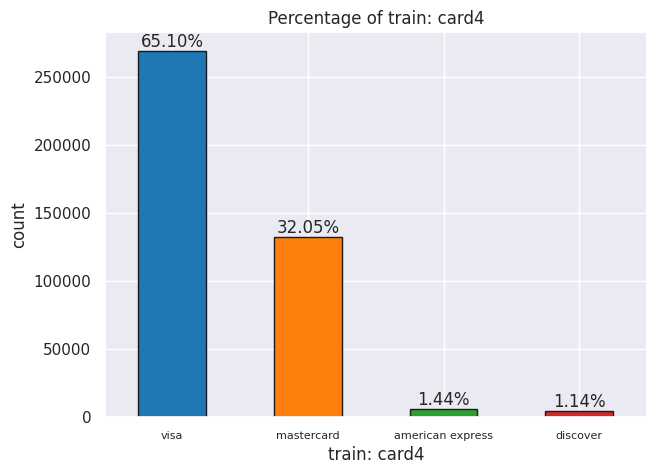

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

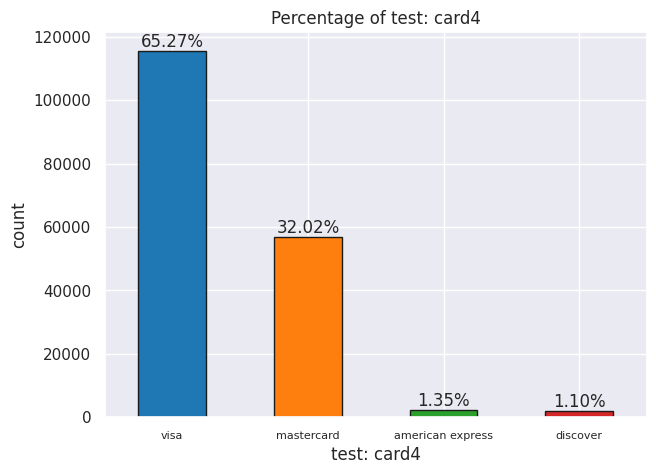

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

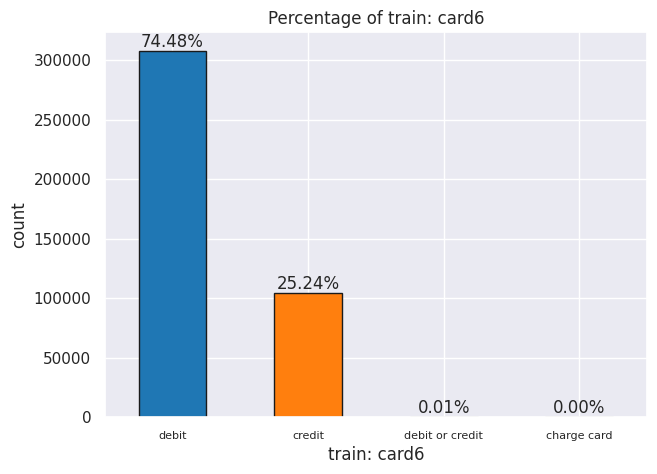

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

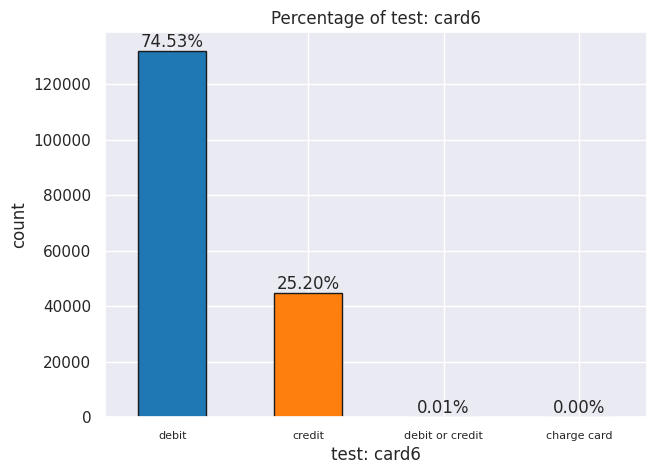

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

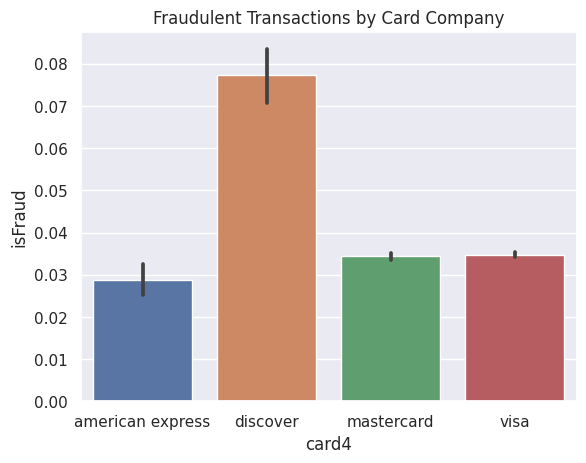

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

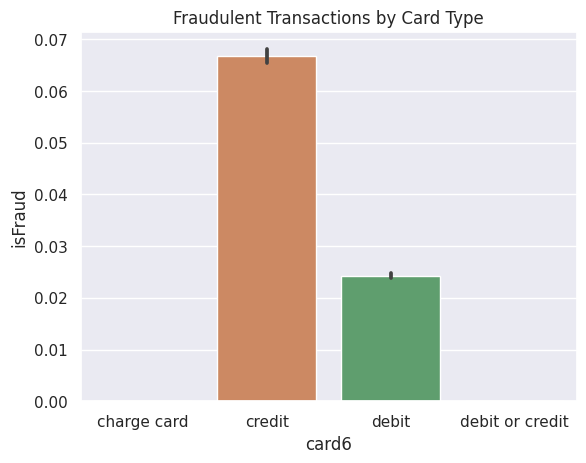

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 220533 to 49037
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
220533        3207533        5178963      117.000000          4  18291  555.0   
162542        3149542        3442175      166.990005          4  10094    NaN   
136171        3123171        2746886     1707.949951          4  16568  321.0   
110035        3097035        2155755      200.000000          2   6019  583.0   
21860         3008860         576919       25.000000          4  11207  361.0   
...               ...            ...             ...        ...    ...    ...   
66310         3053310        1486858      150.000000          2  16075  514.0   
75614         3062614        1649784      261.950012          4   6481  111.0   
326116        3313116        8034626      445.000000          4  10447  490.0   
401326        3388326       10112783       28.277000          0  14543  500.0   
49037         3036037        1178072      500.000000          2   2067  420.0   

        card3  card4  card5  card6  ...   V312  V313        V314  V315   V316  \
220533  150.0      2  195.0      2  ...    0.0   0.0    0.000000   0.0    0.0   
162542  150.0      4  138.0      2  ...    0.0   0.0    0.000000   0.0    0.0   
136171  150.0      4  195.0      2  ...    0.0   0.0    0.000000   0.0    0.0   
110035  150.0      4  226.0      1  ...    0.0   0.0    0.000000   0.0  200.0   
21860   150.0      4  226.0      2  ...    0.0   0.0    0.000000   0.0    0.0   
...       ...    ...    ...    ...  ...    ...   ...         ...   ...    ...   
66310   150.0      2  102.0      1  ...    0.0   0.0    0.000000   0.0    0.0   
75614   150.0      4  226.0      2  ...    0.0   0.0  135.899994   0.0    0.0   
326116  150.0      4  226.0      2  ...  335.0   0.0  335.000000   0.0    0.0   
401326  185.0      2  224.0      1  ...    0.0   0.0    0.000000   0.0    0.0   
49037   150.0      2  224.0      2  ...    0.0   0.0    0.000000   0.0    0.0   

         V317   V318  V319  V320  V321  
220533    0.0    0.0   0.0   0.0   0.0  
162542    0.0    0.0   0.0   0.0   0.0  
136171    0.0    0.0   0.0   0.0   0.0  
110035  200.0  200.0   0.0   0.0   0.0  
21860     0.0    0.0   0.0   0.0   0.0  
...       ...    ...   ...   ...   ...  
66310     0.0    0.0   0.0   0.0   0.0  
75614     0.0    0.0   0.0   0.0   0.0  
326116  169.0    0.0   0.0   0.0   0.0  
401326    0.0    0.0   0.0   0.0   0.0  
49037     0.0    0.0   0.0   0.0   0.0  

[413378 rows x 219 columns]

In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
557643        3544643       14756997       49.000000          4  15370  321.0   
288316        3275316        7085480       24.500000          4  10023  111.0   
296247        3283247        7324049      226.000000          4  18132  567.0   
363123        3350123        9001934       42.950001          4  17131  111.0   
55549         3042549        1289910       49.000000          4   7299  111.0   
...               ...            ...             ...        ...    ...    ...   
395636        3382636        9939326       18.730000          0  15885  545.0   
67004         3054004        1527884        8.570000          0  15315  202.0   
568385        3555385       15085652      554.000000          4   3466  225.0   
150004        3137004        3093504       40.000000          1  16075  514.0   
452819        3439819       11564691      117.000000          4   6530  206.0   

        card3  card4  card5  card6  ...        V312  V313   V314  V315  V316  \
557643  150.0      4  226.0      2  ...    0.000000   0.0   59.0   0.0   0.0   
288316  150.0      4  226.0      2  ...    0.000000   0.0    0.0   0.0   0.0   
296247  150.0      2  117.0      2  ...    0.000000   0.0    0.0   0.0   0.0   
363123  150.0      2  224.0      2  ...  107.949997   0.0    0.0   0.0   0.0   
55549   150.0      2  195.0      2  ...  117.000000   0.0    0.0   0.0   0.0   
...       ...    ...    ...    ...  ...         ...   ...    ...   ...   ...   
395636  185.0      4  138.0      2  ...    0.000000   0.0    0.0   0.0   0.0   
67004   185.0      2  137.0      1  ...    0.000000   0.0    0.0   0.0   0.0   
568385  150.0      2  117.0      2  ...    0.000000   0.0    0.0   0.0   0.0   
150004  150.0      2  102.0      1  ...    0.000000  40.0   40.0  40.0  40.0   
452819  150.0      2  126.0      2  ...  200.000000  59.0  259.0  59.0   0.0   

         V317   V318  V319  V320  V321  
557643    0.0    0.0   0.0   0.0   0.0  
288316    0.0    0.0   0.0   0.0   0.0  
296247    0.0    0.0   0.0   0.0   0.0  
363123    0.0    0.0   0.0   0.0   0.0  
55549   149.0    0.0  49.0  49.0  49.0  
...       ...    ...   ...   ...   ...  
395636    0.0    0.0   0.0   0.0   0.0  
67004     0.0    0.0   0.0   0.0   0.0  
568385    0.0    0.0   0.0   0.0   0.0  
150004   40.0   40.0   0.0   0.0   0.0  
452819  282.0  282.0   0.0   0.0   0.0  

[177162 rows x 219 columns]

In [52]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...       V312        V313  \
0       150.0        visa  226.0   debit  ...   0.000000    0.000000   
1       150.0        visa  226.0   debit  ...  77.000000    0.000000   
2       150.0        visa  226.0   debit  ...   0.000000    0.000000   
3       150.0        visa  166.0   debit  ...   0.000000  282.540009   
4       150.0  mastercard  117.0   debit  ...  67.949997   67.949997   
...       ...         ...    ...     ...  ...        ...         ...   
506686  185.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506687  185.0  mastercard  224.0   debit  ...   0.000000   31.723700   
506688  150.0        visa  226.0   debit  ...   0.000000    0.000000   
506689  150.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506690  144.0        visa  147.0  credit  ...   0.000000    0.000000   

              V314        V315  V316  V317  V318  V319   V320  V321  
0         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000    0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009  282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4       183.850006   67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...         ...   ...   ...   ...   ...    ...   ...  
506686    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card3  card4  card5  card6  ...       V312        V313        V314  \
0       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
1       150.0      4  226.0      2  ...  77.000000    0.000000    0.000000   
2       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
3       150.0      4  166.0      2  ...   0.000000  282.540009  282.540009   
4       150.0      2  117.0      2  ...  67.949997   67.949997  183.850006   
...       ...    ...    ...    ...  ...        ...         ...         ...   
506686  185.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506687  185.0      2  224.0      2  ...   0.000000   31.723700   31.723700   
506688  150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
506689  150.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506690  144.0      4  147.0      1  ...   0.000000    0.000000    0.000000   

              V315  V316  V317  V318  V319   V320  V321  
0         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4        67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...   ...   ...   ...   ...    ...   ...  
506686    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.9994963626704848),
 ('C1', 'C11', 0.9965607963296673),
 ('C1', 'C2', 0.9951439844100551),
 ('C2', 'C1', 0.9951439844100551),
 ('C2', 'C11', 0.9939627806163583),
 ('C6', 'C11', 0.9911066090468261),
 ('C7', 'C10', 0.9847962873770975),
 ('C6', 'C14', 0.9841533509240226),
 ('C7', 'C8', 0.9827005342864272),
 ('C1', 'C6', 0.9822994355723507),
 ('C6', 'C1', 0.9822994355723507),
 ('D1', 'D2', 0.9812331174021418),
 ('D2', 'D1', 0.9812331174021418),
 ('C2', 'C8', 0.9759174305189021),
 ('C2', 'C6', 0.974906730636597),
 ('C6', 'C2', 0.974906730636597),
 ('C2', 'C4', 0.972113343760445),
 ('C2', 'C10', 0.9705933531976281),
 ('C1', 'C4', 0.9677912034787022),
 ('C1', 'C8', 0.9676943702408097),
 ('C6', 'C4', 0.9624872898229508),
 ('C1', 'C10', 0.9581278057336933),
 ('C1', 'C14', 0.9517222371044003),
 ('M2', 'M3', 0.9407065675782804),
 ('M3', 'M2', 0.9407065675782804),
 ('C2', 'C12', 0.9397947390918344),
 ('C2', 'C7', 0.9384466819994878),
 ('C7', 'C2', 0.9384466819994878),
 ('C2', 'C14'

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2636
2636
5272
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
220533        3207533        5178963      117.000000          4  18291  555.0   
162542        3149542        3442175      166.990005          4  10094    NaN   
136171        3123171        2746886     1707.949951          4  16568  321.0   
110035        3097035        2155755      200.000000          2   6019  583.0   
21860         3008860         576919       25.000000          4  11207  361.0   
...               ...            ...             ...        ...    ...    ...   
66310         3053310        1486858      150.000000          2  16075  514.0   
75614         3062614        1649784      261.950012          4   6481  111.0   
326116        3313116        8034626      445.000000          4  10447  490.0   
401326        3388326       10112783       28.277000          0  14543  500.0   
49037         3036037        1178072      500.000000          2   2067  420.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
220533      2  195.0      2  204.0  ...             16  0.0   NaN  NaN  1.0   
162542      4  138.0      2  181.0  ...             54  0.0   NaN  NaN  1.0   
136171      4  195.0      2  264.0  ...             54  0.0  31.0  NaN  1.0   
110035      4  226.0      1  299.0  ...             19  0.0   NaN  NaN  NaN   
21860       4  226.0      2  330.0  ...             32  0.0  14.0  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
66310       2  102.0      1  299.0  ...             54  0.0   NaN  NaN  NaN   
75614       4  226.0      2  337.0  ...             32  0.0  17.0  1.0  1.0   
326116      4  226.0      2  315.0  ...             54  0.0   0.0  NaN  1.0   
401326      2  224.0      1    NaN  ...             16  0.0   NaN  NaN  1.0   
49037       2  224.0      2  269.0  ...             16  0.0   NaN  NaN  NaN   

        V107  V121  V281  V286  V305  
220533   1.0   1.0   0.0   0.0   1.0  
162542   1.0   1.0   0.0   0.0   1.0  
136171   1.0   1.0   0.0   0.0   1.0  
110035   1.0   1.0   0.0   0.0   1.0  
21860    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
66310    1.0   1.0   0.0   0.0   1.0  
75614    1.0   1.0   0.0   0.0   1.0  
326116   1.0   1.0   0.0   0.0   1.0  
401326   1.0   1.0   0.0   0.0   1.0  
49037    1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
557643        3544643       14756997       49.000000          4  15370  321.0   
288316        3275316        7085480       24.500000          4  10023  111.0   
296247        3283247        7324049      226.000000          4  18132  567.0   
363123        3350123        9001934       42.950001          4  17131  111.0   
55549         3042549        1289910       49.000000          4   7299  111.0   
...               ...            ...             ...        ...    ...    ...   
395636        3382636        9939326       18.730000          0  15885  545.0   
67004         3054004        1527884        8.570000          0  15315  202.0   
568385        3555385       15085652      554.000000          4   3466  225.0   
150004        3137004        3093504       40.000000          1  16075  514.0   
452819        3439819       11564691      117.000000          4   6530  206.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
557643      4  226.0      2  203.0  ...             16  0.0  15.0  1.0  1.0   
288316      4  226.0      2    NaN  ...             16  0.0   NaN  1.0  1.0   
296247      2  117.0      2  204.0  ...             30  0.0   NaN  1.0  1.0   
363123      2  224.0      2  264.0  ...              3  0.0   2.0  1.0  1.0   
55549       2  195.0      2  204.0  ...              1  0.0   0.0  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
395636      4  138.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
67004       2  137.0      1    NaN  ...             19  0.0   NaN  NaN  1.0   
568385      2  117.0      2  226.0  ...              8  0.0   NaN  1.0  1.0   
150004      2  102.0      1  204.0  ...             16  0.0   NaN  NaN  NaN   
452819      2  126.0      2  433.0  ...             32  0.0   1.0  1.0  1.0   

        V107  V121  V281  V286  V305  
557643   1.0   1.0   0.0   0.0   1.0  
288316   1.0   1.0   0.0   0.0   1.0  
296247   1.0   1.0   0.0   0.0   1.0  
363123   1.0   1.0   0.0   0.0   1.0  
55549    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
395636   1.0   1.0   0.0   0.0   1.0  
67004    1.0   1.0   0.0   0.0   1.0  
568385   1.0   1.0   0.0   0.0   1.0  
150004   1.0   1.0   0.0   0.0   1.0  
452819   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 21 columns]

In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
0           4  226.0      2  170.0  ...             16  0.0  27.0  1.0  1.0   
1           4  226.0      2  299.0  ...              2  0.0   7.0  1.0  1.0   
2           4  226.0      2  472.0  ...             19  0.0  10.0  1.0  1.0   
3           4  166.0      2  205.0  ...             16  0.0  41.0  1.0  1.0   
4           2  117.0      2  264.0  ...             16  0.0   0.0  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
506686      2  224.0      2  284.0  ...             16  0.0   NaN  NaN  1.0   
506687      2  224.0      2    NaN  ...             19  0.0  16.0  NaN  2.0   
506688      4  226.0      2  327.0  ...             19  0.0   NaN  1.0  1.0   
506689      2  224.0      2  177.0  ...             19  0.0   NaN  1.0  1.0   
506690      4  147.0      1    NaN  ...             19  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 21 columns]

Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

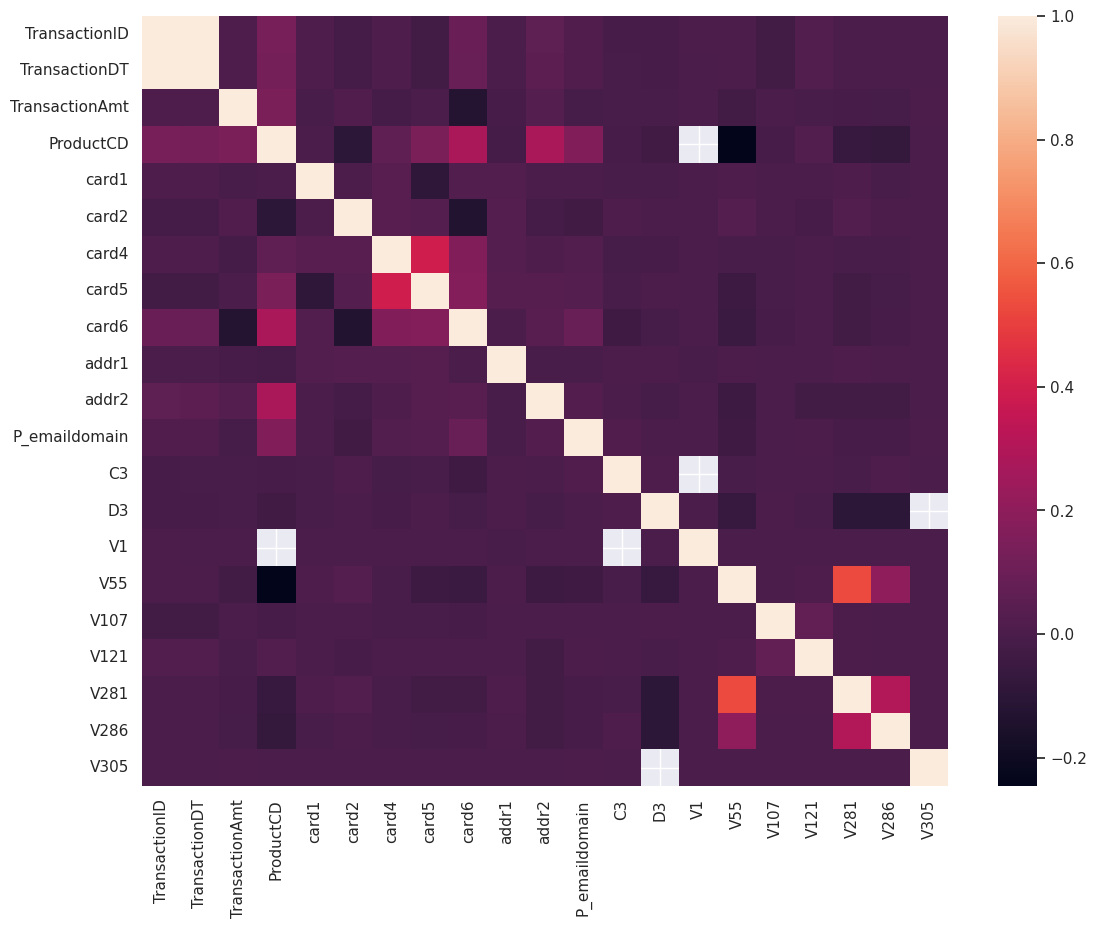

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns, 
           yticklabels=X_train.columns)

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


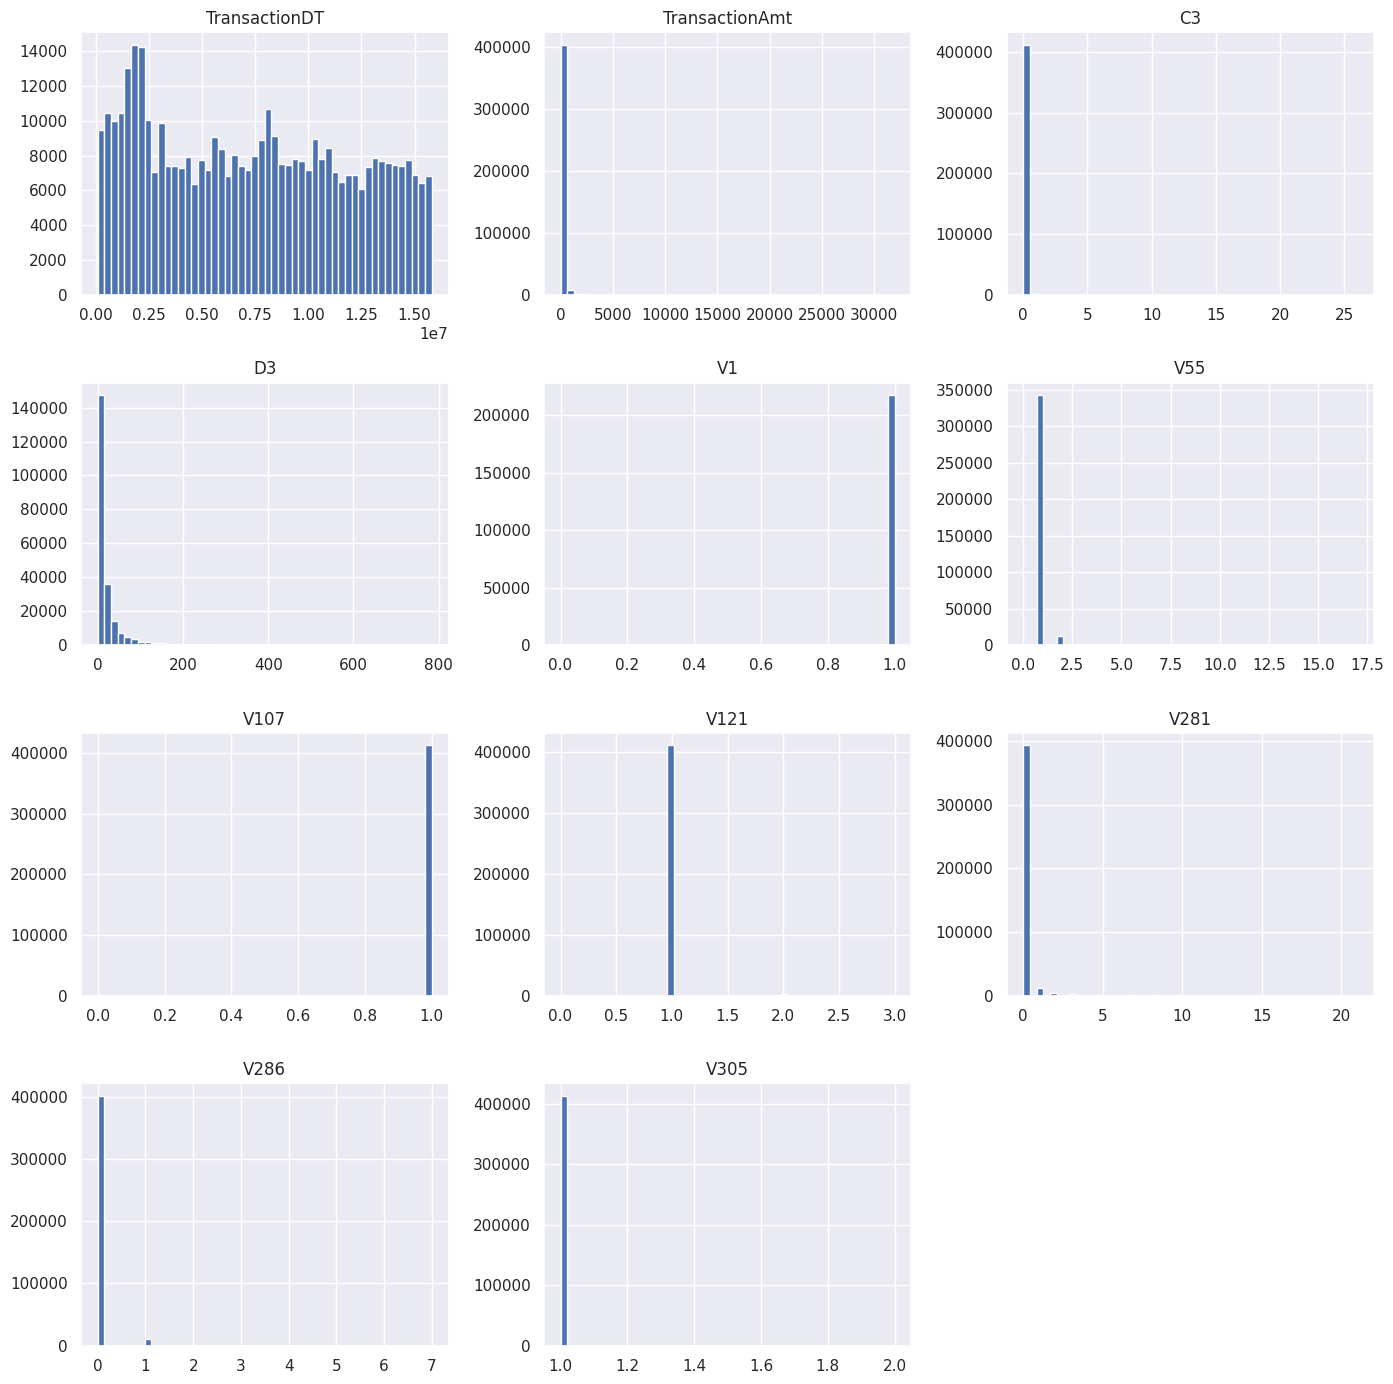

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

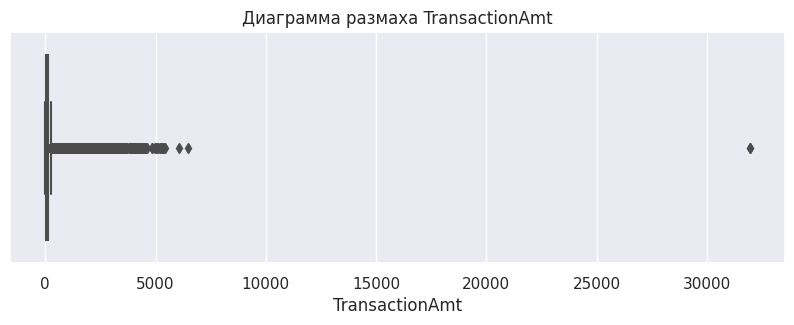

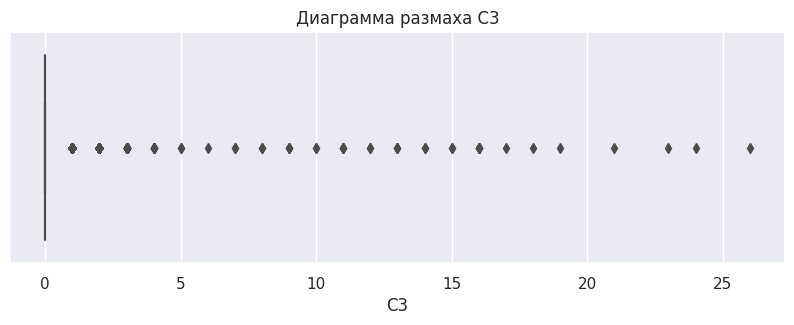

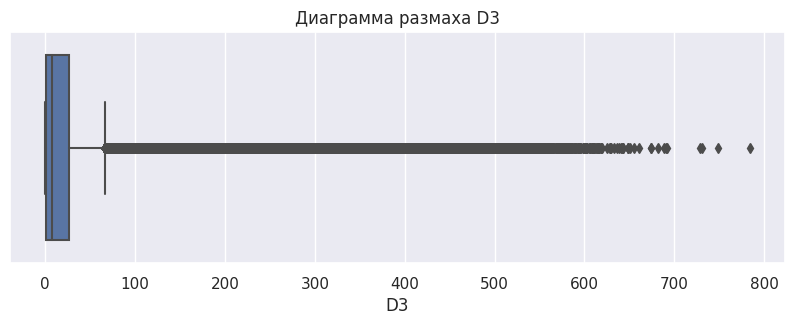

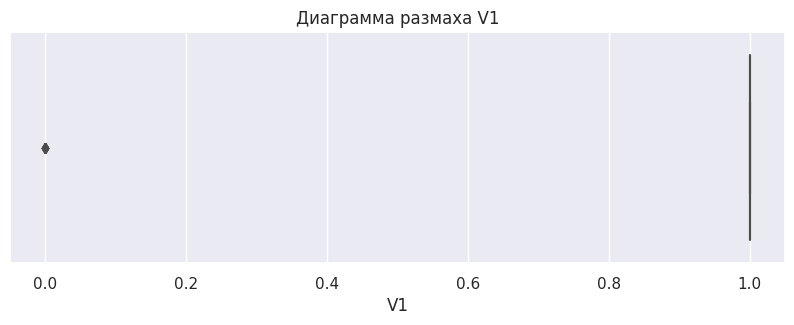

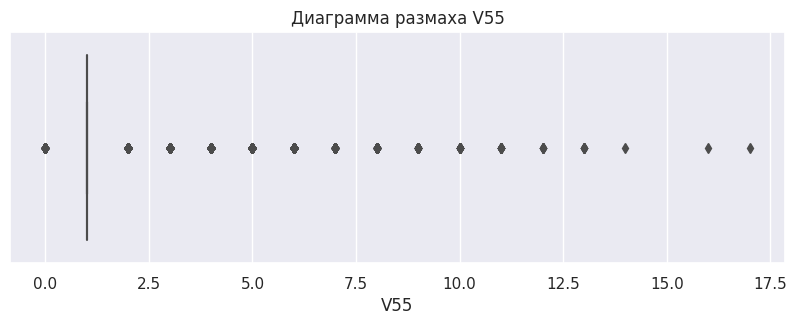

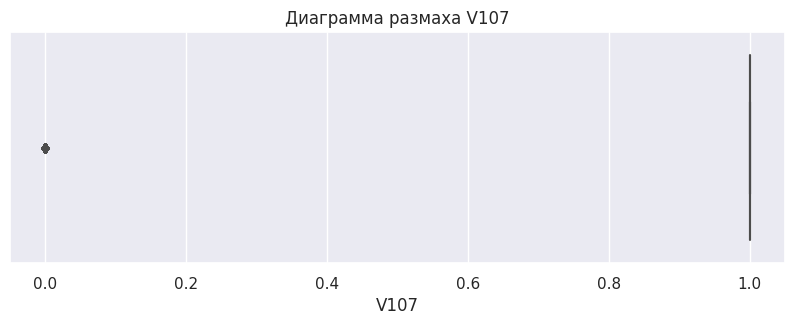

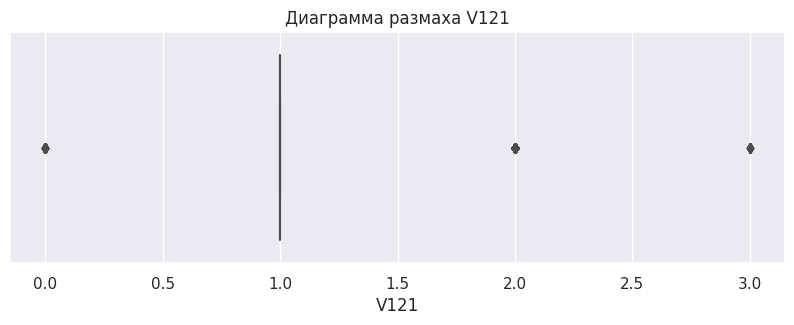

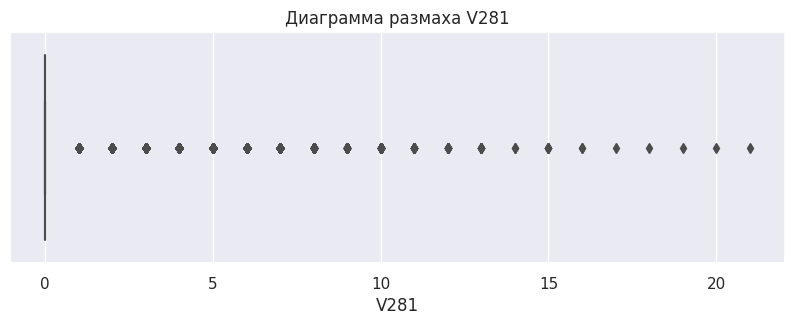

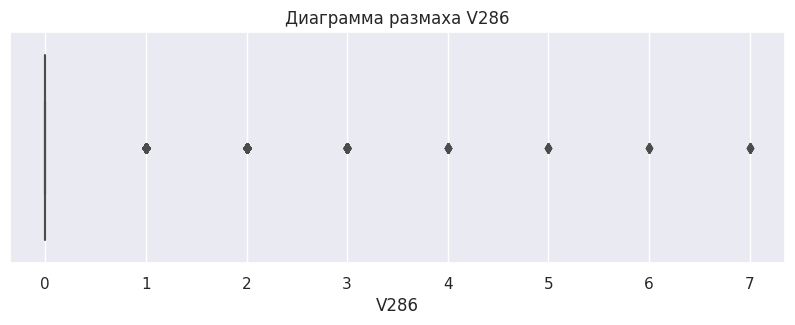

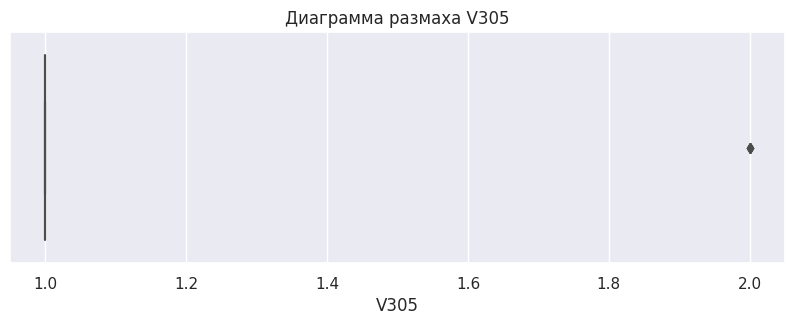

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 220533 to 49037
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407174 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410339 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367338 non-null  float32
 10  addr2           367338 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229494 non-null  float32
 14  V1              217728 non-null  float32
 15  V55             359464 non-null  float32
 16  V107            413150 non-null  float32
 17  V121       

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6204
card4                  0
card5               3039
card6                  0
addr1              46040
addr2              46040
P_emaildomain          0
C3                     0
D3                183884
V1                195650
V55                53914
V107                 228
V121                 228
V281                 903
V286                   8
V305                   8
dtype: int64

Сперва заполним пропуски числовых признаков средним по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Посмотрим на распределения признаков после заполнения пропусков

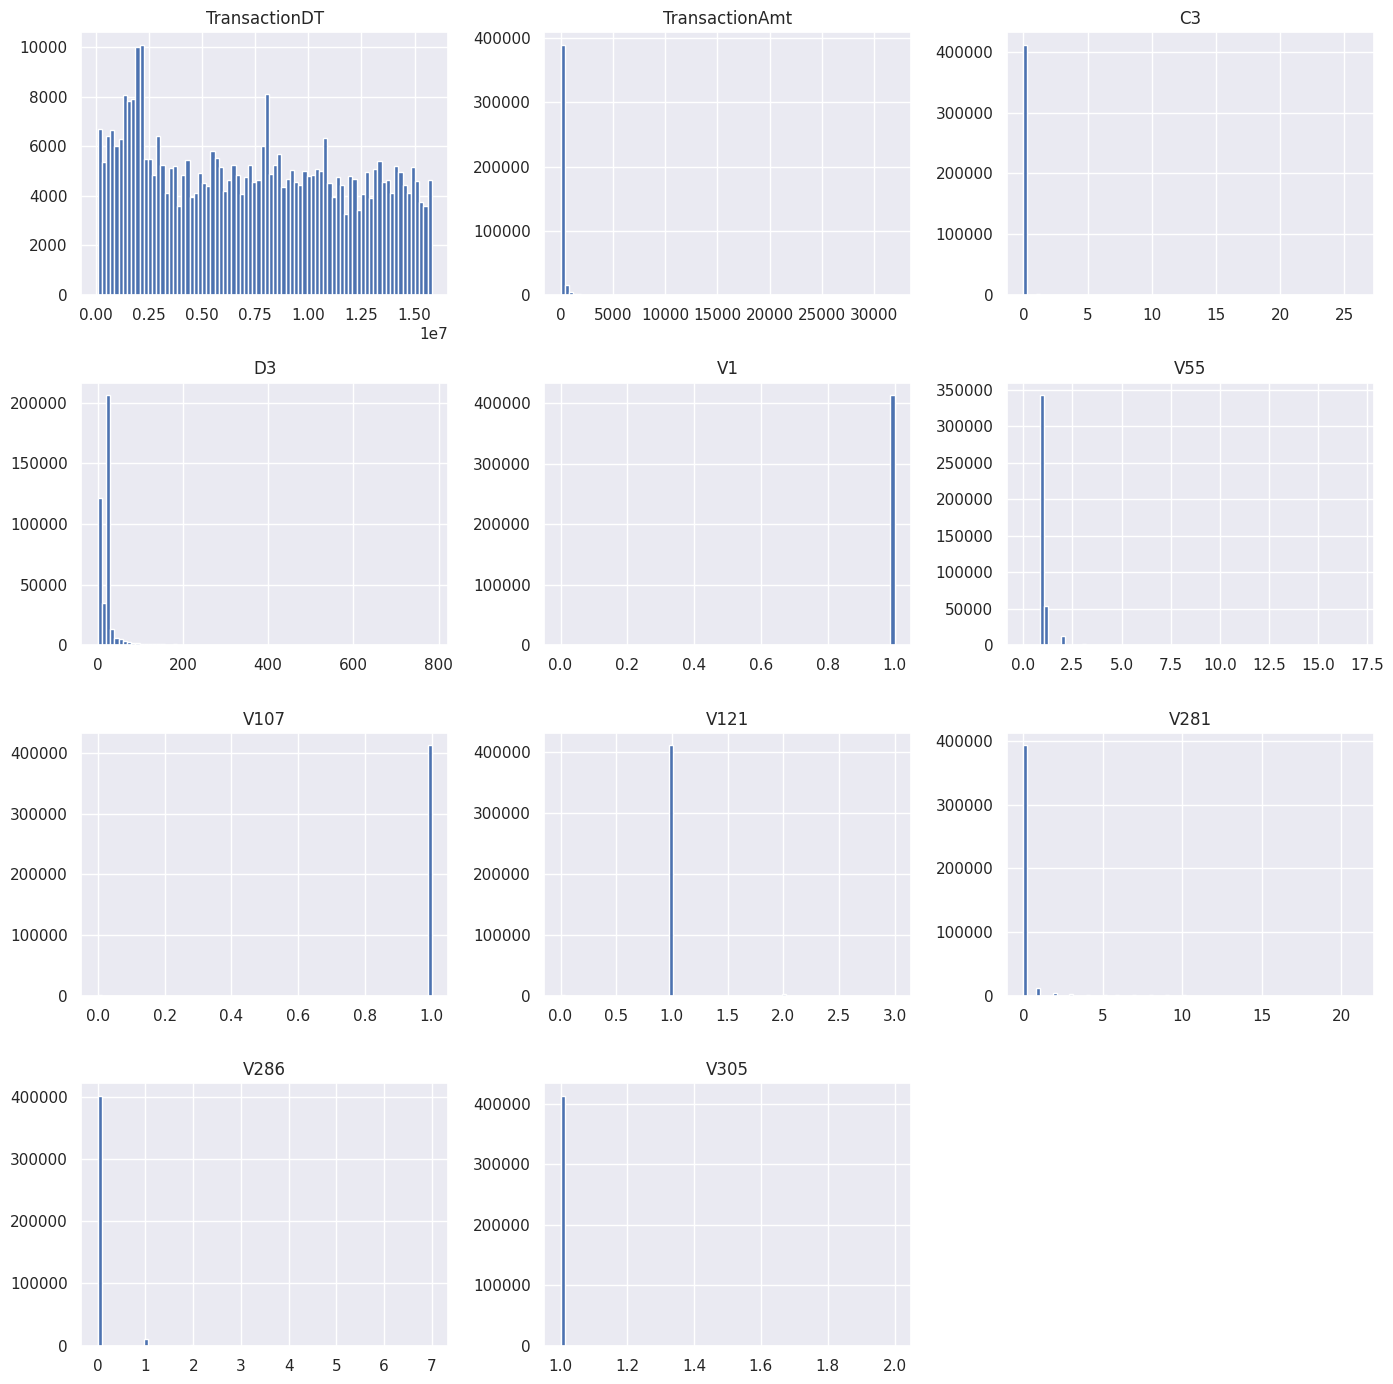

In [76]:
X_train_copy[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

Видим, что распределения признаков после заполнения пропусков не изменились

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [79]:
y_pred_valid_LR = model_LR.predict(X_valid_copy)

In [80]:
y_pred_valid_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [81]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


Отличный результат, но это на валидационной выборке, и плюс распределение ответов в нашей выборке не сбалансировано

#### Посмотрим на **матрицу ошибок**

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

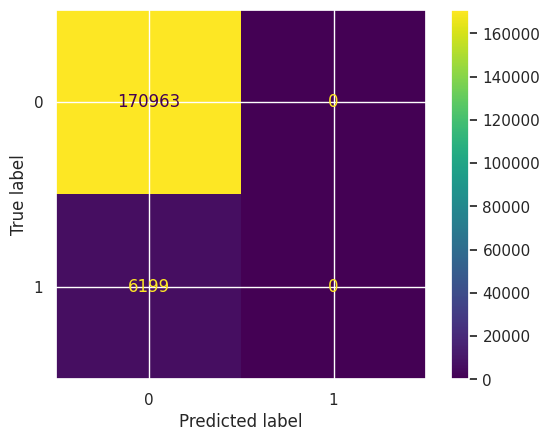

In [83]:
cm = confusion_matrix(y_valid, y_pred_valid_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Видим, что среди верных срабатываний не предсказано ни одного верного ответа

Посмотрим отчёт по метрикам классификации

In [84]:
print(classification_report(y_valid, y_pred_valid_LR))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Это потому что в данных большой дисбаланс классов

Так как размеры датасетов достаточно большие, уберём часть данных класса с большей долей (валидные) из нашей выборки

In [85]:
X_train_copy

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
220533        3207533        5178963      117.000000          4  18291  555.0   
162542        3149542        3442175      166.990005          4  10094   -1.0   
136171        3123171        2746886     1707.949951          4  16568  321.0   
110035        3097035        2155755      200.000000          2   6019  583.0   
21860         3008860         576919       25.000000          4  11207  361.0   
...               ...            ...             ...        ...    ...    ...   
66310         3053310        1486858      150.000000          2  16075  514.0   
75614         3062614        1649784      261.950012          4   6481  111.0   
326116        3313116        8034626      445.000000          4  10447  490.0   
401326        3388326       10112783       28.277000          0  14543  500.0   
49037         3036037        1178072      500.000000          2   2067  420.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3         D3  \
220533      2  195.0      2  204.0  ...             16  0.0  28.488626   
162542      4  138.0      2  181.0  ...             54  0.0  28.488626   
136171      4  195.0      2  264.0  ...             54  0.0  31.000000   
110035      4  226.0      1  299.0  ...             19  0.0  28.488626   
21860       4  226.0      2  330.0  ...             32  0.0  14.000000   
...       ...    ...    ...    ...  ...            ...  ...        ...   
66310       2  102.0      1  299.0  ...             54  0.0  28.488626   
75614       4  226.0      2  337.0  ...             32  0.0  17.000000   
326116      4  226.0      2  315.0  ...             54  0.0   0.000000   
401326      2  224.0      1   -1.0  ...             16  0.0  28.488626   
49037       2  224.0      2  269.0  ...             16  0.0  28.488626   

              V1       V55  V107  V121  V281  V286  V305  
220533  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
162542  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
136171  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
110035  0.999945  1.068277   1.0   1.0   0.0   0.0   1.0  
21860   0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...       ...   ...   ...   ...   ...   ...  
66310   0.999945  1.068277   1.0   1.0   0.0   0.0   1.0  
75614   1.000000  1.000000   1.0   1.0   0.0   0.0   1.0  
326116  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
401326  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
49037   0.999945  1.068277   1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

Мы помним, что распределение целевых меток в наших данных:
- валидные транзакции - ```96,5``` %
- мошеннические транзакции - ```3,5``` %

Попробуем убрать число копий мошеннических транзакций так, чтобы соотношение классов стало равным ```70```% (валидные) к ```30``` % (мошеннические)

Посчитаем сколько записей транзакций от **общего размера обучающей выборки** составляют ```70``` %:

In [86]:
num_y_train_70_prct = len(y_train) * 0.7
int(num_y_train_70_prct)

289364

Посмотрим сколько записей **валидных транзакций** надо удалить из обучающего датасета, чтобы соотношение долей ответов стало 70 к 30:

- num_trxs       - 100 %
- num_valid_trxs - 70 %
- num_fraud_trxs - 30%

In [87]:
not_fraud_trxs_count = len(y_train[y_train==0])
fraud_trxs_count = len(y_train[y_train==1])
# посмотрим какое общее число транзакций должно быть, 
# чтобы мы смогли достичь нужного соотношения
balanced_trxs_count = int(fraud_trxs_count * 100 / 30)
print('not_fraud_trxs_count: ', not_fraud_trxs_count)
print('fraud_trxs_count: ', fraud_trxs_count)
print('balanced_trxs_count: ', balanced_trxs_count)

not_fraud_trxs_count:  398914
fraud_trxs_count:  14464
balanced_trxs_count:  48213


Видим, что **сбалансированое кол-во транзакций было бы - 48213**, но мы не можем сократить число транзакций до такого кол-ва, т.к. данных останется слишком мало, что плохо скажется на прогнозах по тестовым данным

Поэтому необходимо **добавить** необходимое число копий **мошеннических транзакций** в датасеты

In [88]:
trxs_count = len(y_train)
opt_fraud_trxs_count = int(trxs_count * 30 / 100)
print('optimal fraud trxs count: ', opt_fraud_trxs_count)

optimal fraud trxs count:  124013


Посчитаем насколько копий нужно увеличить кол-во мошеннических записей

In [89]:
diff_fraud_trxs_count = opt_fraud_trxs_count - fraud_trxs_count
diff_fraud_trxs_count

109549

Нужно добавить **109549** записей класса 1

In [90]:
int(opt_fraud_trxs_count / fraud_trxs_count)

8

#### т.е. увеличим число мошеннических транзакций примерно в 8 раз

In [91]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(7)])
y_train_fraud_increased

116914    1
475598    1
426761    1
316307    1
424898    1
         ..
544797    1
573159    1
566209    1
589166    1
39234     1
Name: isFraud, Length: 101248, dtype: uint8

In [92]:
y_train_increased = pd.concat([y_train, y_train_fraud_increased])
y_train_increased

220533    0
162542    0
136171    0
110035    0
21860     0
         ..
544797    1
573159    1
566209    1
589166    1
39234     1
Name: isFraud, Length: 514626, dtype: uint8

Посмотрим теперь на соотношение ответов

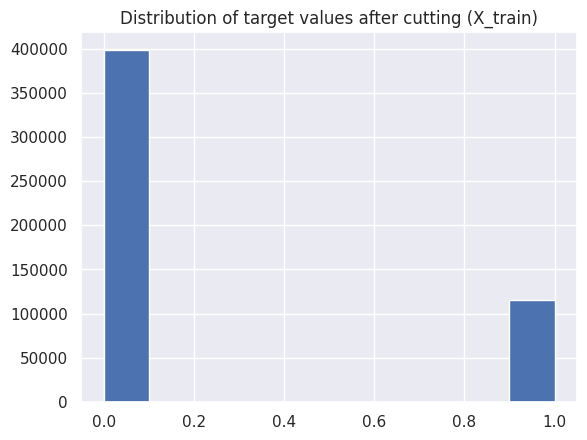

In [93]:
plt.hist(y_train_increased)
plt.title('Distribution of target values after cutting (X_train)')
plt.show()

Видим, как поменялось соотношение ответов

Увеличим кол-во соответствующих данных в датасете ```X_train```

In [94]:
before_inc = y_train[y_train==1].index
before_inc

Index([116914, 475598, 426761, 316307, 424898, 293472, 402880, 159531, 422292,
       565600,
       ...
       410899, 449539,  67744, 522062, 155349, 544797, 573159, 566209, 589166,
        39234],
      dtype='int64', length=14464)

In [95]:
y_train_indexes = list(y_train_increased[y_train_increased==1].index[len(before_inc):])
len(y_train_indexes)

101248

In [96]:
X_train_increased = pd.concat([X_train, X_train.loc[y_train_indexes]])
X_train_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
220533        3207533        5178963      117.000000          4  18291  555.0   
162542        3149542        3442175      166.990005          4  10094    NaN   
136171        3123171        2746886     1707.949951          4  16568  321.0   
110035        3097035        2155755      200.000000          2   6019  583.0   
21860         3008860         576919       25.000000          4  11207  361.0   
...               ...            ...             ...        ...    ...    ...   
544797        3531797       14386853      117.000000          4   3368  572.0   
573159        3560159       15215780       16.354000          0  16136  204.0   
566209        3553209       15013160      106.000000          4   9500  321.0   
589166        3576166       15783628       59.000000          4   4383  271.0   
39234         3026234         954870       14.692000          0  15885  545.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
220533      2  195.0      2  204.0  ...             16  0.0   NaN  NaN  1.0   
162542      4  138.0      2  181.0  ...             54  0.0   NaN  NaN  1.0   
136171      4  195.0      2  264.0  ...             54  0.0  31.0  NaN  1.0   
110035      4  226.0      1  299.0  ...             19  0.0   NaN  NaN  NaN   
21860       4  226.0      2  330.0  ...             32  0.0  14.0  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
544797      2  224.0      2  433.0  ...             32  0.0  15.0  1.0  1.0   
573159      4  138.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
566209      4  226.0      2  231.0  ...             32  0.0   NaN  1.0  1.0   
589166      4  226.0      1  324.0  ...              2  0.0   0.0  1.0  1.0   
39234       4  138.0      2    NaN  ...             23  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
220533   1.0   1.0   0.0   0.0   1.0  
162542   1.0   1.0   0.0   0.0   1.0  
136171   1.0   1.0   0.0   0.0   1.0  
110035   1.0   1.0   0.0   0.0   1.0  
21860    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
544797   1.0   1.0   0.0   0.0   1.0  
573159   1.0   1.0   0.0   0.0   1.0  
566209   1.0   1.0   0.0   0.0   1.0  
589166   1.0   1.0   0.0   0.0   1.0  
39234    1.0   1.0   0.0   0.0   1.0  

[514626 rows x 21 columns]

In [97]:
y_train_increased.shape

(514626,)

In [98]:
X_train_increased.shape

(514626, 21)

In [99]:
X_train_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8297
card4                  0
card5               4068
card6                  0
addr1              84232
addr2              84232
P_emaildomain          0
C3                     0
D3                238092
V1                267092
V55                76020
V107                 326
V121                 326
V281                1106
V286                  15
V305                  15
dtype: int64

Снова заполним пропуски в данных:
- числовые признаки средними значениями по столбцам
- категориальные - ```-1```

In [100]:
X_train_increased[num_feats] = X_train_increased[num_feats].fillna(
    X_train_increased[num_feats].mean())

In [101]:
X_train_increased[cat_feats] = X_train_increased[cat_feats].fillna(-1)

In [102]:
X_train_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Проделаем вышеперечисленные действия с увеличением доли **мошеннических записей** для валидационного датасета

In [103]:
y_valid_fraud_increased = pd.concat([y_valid[y_valid==1] for i in range(7)])
y_valid_fraud_increased

374198    1
390790    1
268834    1
383190    1
340654    1
         ..
557503    1
558810    1
586024    1
397410    1
241071    1
Name: isFraud, Length: 43393, dtype: uint8

In [104]:
y_valid_increased = pd.concat([y_valid, y_valid_fraud_increased])
y_valid_increased

557643    0
288316    0
296247    0
363123    0
55549     0
         ..
557503    1
558810    1
586024    1
397410    1
241071    1
Name: isFraud, Length: 220555, dtype: uint8

Посмотрим на соотношение ответов валидационного датасета

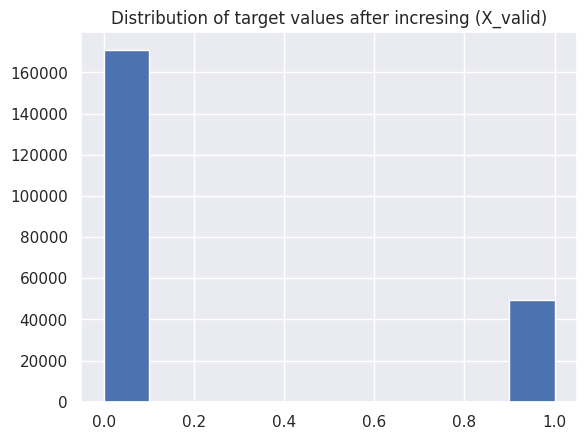

In [105]:
plt.hist(y_valid_increased)
plt.title('Distribution of target values after incresing (X_valid)')
plt.show()

In [106]:
before_inc = y_valid[y_valid==1].index
y_valid_indexes = list(y_valid_increased[y_valid_increased==1].index[len(before_inc):])
X_valid_increased = pd.concat([X_valid, X_valid.loc[y_valid_indexes]])
X_valid_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
557643        3544643       14756997       49.000000          4  15370  321.0   
288316        3275316        7085480       24.500000          4  10023  111.0   
296247        3283247        7324049      226.000000          4  18132  567.0   
363123        3350123        9001934       42.950001          4  17131  111.0   
55549         3042549        1289910       49.000000          4   7299  111.0   
...               ...            ...             ...        ...    ...    ...   
557503        3544503       14753632       14.879000          0   5347  408.0   
558810        3545810       14785695        9.468000          0   7079  545.0   
586024        3573024       15690030       28.096001          0   3154  408.0   
397410        3384410       10010437       65.978996          0   1164  545.0   
241071        3228071        5696717       59.000000          4   5033  269.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
557643      4  226.0      2  203.0  ...             16  0.0  15.0  1.0  1.0   
288316      4  226.0      2    NaN  ...             16  0.0   NaN  1.0  1.0   
296247      2  117.0      2  204.0  ...             30  0.0   NaN  1.0  1.0   
363123      2  224.0      2  264.0  ...              3  0.0   2.0  1.0  1.0   
55549       2  195.0      2  204.0  ...              1  0.0   0.0  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
557503      2  102.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
558810      4  226.0      1    NaN  ...             21  0.0   0.0  NaN  3.0   
586024      2  224.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
397410      4  137.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
241071      2  224.0      2  476.0  ...             54  0.0   0.0  NaN  2.0   

        V107  V121  V281  V286  V305  
557643   1.0   1.0   0.0   0.0   1.0  
288316   1.0   1.0   0.0   0.0   1.0  
296247   1.0   1.0   0.0   0.0   1.0  
363123   1.0   1.0   0.0   0.0   1.0  
55549    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
557503   1.0   1.0   0.0   0.0   1.0  
558810   1.0   1.0   2.0   0.0   1.0  
586024   1.0   1.0   0.0   0.0   1.0  
397410   1.0   1.0   0.0   0.0   1.0  
241071   1.0   1.0   0.0   0.0   1.0  

[220555 rows x 21 columns]

In [107]:
y_valid_increased.shape

(220555,)

In [108]:
X_valid_increased.shape

(220555, 21)

Заполним пропуски в валидационном датасете

In [109]:
X_valid_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3597
card4                  0
card5               1661
card6                  0
addr1              35661
addr2              35661
P_emaildomain          0
C3                     0
D3                102094
V1                114094
V55                32639
V107                 107
V121                 107
V281                 485
V286                  11
V305                  11
dtype: int64

In [110]:
X_valid_increased[num_feats] = X_valid_increased[num_feats].fillna(
    X_valid_increased[num_feats].mean())

In [111]:
X_valid_increased[cat_feats] = X_valid_increased[cat_feats].fillna(-1)

In [112]:
X_valid_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

Заполним пропуски в тестовом датасете

In [113]:
test_df.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8654
card4                  0
card5               4547
card6                  0
addr1              65609
addr2              65609
P_emaildomain          0
C3                     3
D3                203142
V1                176518
V55                12899
V107                   0
V121                   0
V281                6031
V286                   3
V305                   3
dtype: int64

In [114]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [115]:
test_df[num_feats[1:]] = test_df[num_feats[1:]].fillna(test_df[num_feats[1:]].mean())
test_df[cat_feats] = test_df[cat_feats].fillna(-1)
test_df.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### После добавления данных в датасеты посмотрим снова на прогноз модели логистической регрессии:

In [116]:
model_LR2 = LogisticRegression()
model_LR2.fit(X_train_increased, y_train_increased)

LogisticRegression()

In [117]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_increased)

In [118]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid_increased).sum()/len(y_valid_increased)}')

Доля верно угаданных объектов 0.7751490557910725


Видим, что качество прогнозов ухудшилось. Посмотрим на матрицу ошибок и отчёт классификации

Напишем функцию для построения матрицы ошибок:

In [119]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

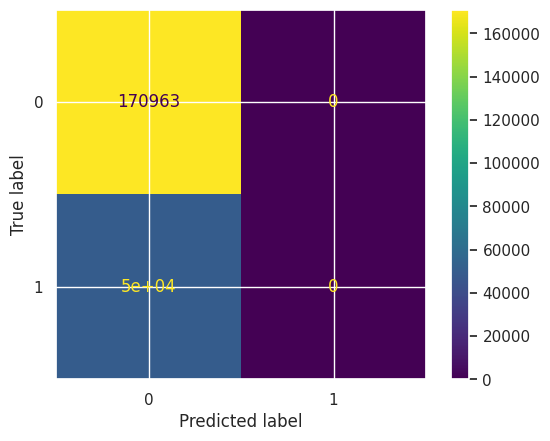

In [120]:
conf_matrix(y_valid_increased, y_pred_valid_LR2)

In [121]:
print(classification_report(y_valid_increased, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    170963
           1       0.00      0.00      0.00     49592

    accuracy                           0.78    220555
   macro avg       0.39      0.50      0.44    220555
weighted avg       0.60      0.78      0.68    220555



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Попробуем сделать прогноз на исходной выборке ```X_valid_copy``` с дисбалансом в данных

In [122]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_copy)

In [123]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


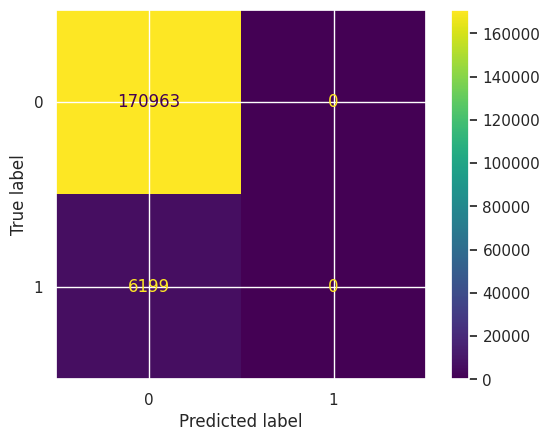

In [124]:
conf_matrix(y_valid, y_pred_valid_LR2)

In [125]:
print(classification_report(y_valid, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Видим, что среди верных срабатываний доля верно предсказанных значений мошеннических транзакций увеличилась, но число ошибок также очень большое

#### Но попробуем сбалансировать значения двух выборок 50 на 50. Уменьшим кол-во записей в датасете с классом 0

In [126]:
opt_fraud_trxs_count

124013

In [127]:
not_fraud_trxs_count

398914

In [128]:
balanced_y_train_0 = y_train[y_train==0][:opt_fraud_trxs_count]
balanced_y_train_0

220533    0
162542    0
136171    0
110035    0
21860     0
         ..
527120    0
213641    0
86299     0
505521    0
187651    0
Name: isFraud, Length: 124013, dtype: uint8

In [129]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(8)])
y_train_fraud_increased

116914    1
475598    1
426761    1
316307    1
424898    1
         ..
544797    1
573159    1
566209    1
589166    1
39234     1
Name: isFraud, Length: 115712, dtype: uint8

In [130]:
y_train_balanced = pd.concat([balanced_y_train_0, y_train_fraud_increased])
y_train_balanced

220533    0
162542    0
136171    0
110035    0
21860     0
         ..
544797    1
573159    1
566209    1
589166    1
39234     1
Name: isFraud, Length: 239725, dtype: uint8

Посмотрим теперь на соотношение ответов

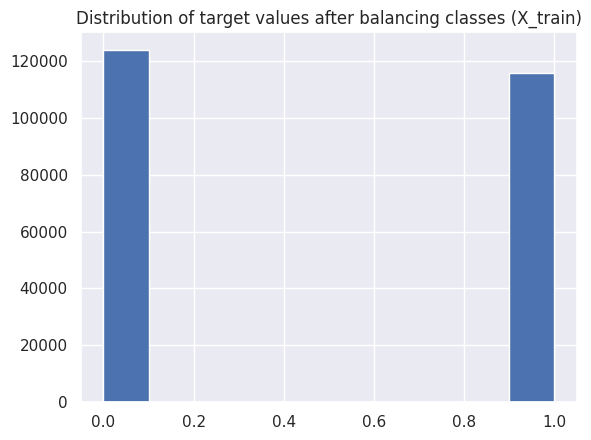

In [131]:
plt.hist(y_train_balanced)
plt.title('Distribution of target values after balancing classes (X_train)')
plt.show()

In [132]:
y_train_balanced.shape

(239725,)

In [133]:
X_train_balanced = X_train_copy.loc[y_train_balanced.index]

In [134]:
X_train_balanced.shape

(239725, 21)

In [135]:
test_df.shape

(506691, 21)

In [136]:
model_LR4 = LogisticRegression()
model_LR4.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [137]:
y_pred_valid_LR4 = model_LR4.predict(X_valid_copy)

In [138]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR4 == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7597566069473137


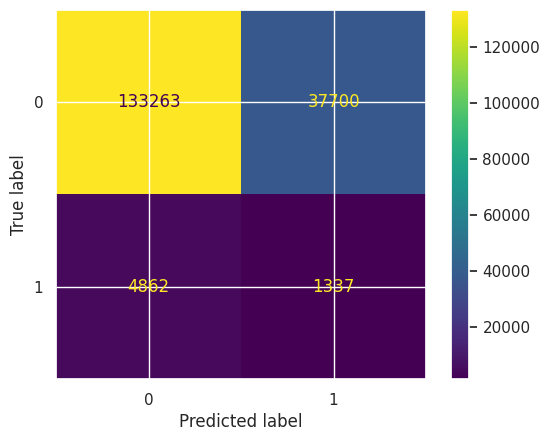

In [139]:
conf_matrix(y_valid, y_pred_valid_LR4)

In [140]:
print(classification_report(y_valid, y_pred_valid_LR4))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    170963
           1       0.03      0.22      0.06      6199

    accuracy                           0.76    177162
   macro avg       0.50      0.50      0.46    177162
weighted avg       0.93      0.76      0.83    177162



Видим, что качество после уравнивания долей ответов обоих классов по прежнему остаётся не очень хорошим, хоть и полнота для класса 1 выросла

#### Так как линейные модели чувствительны к порядкам признаков, необходимо произвести **масштабирование признаков**

In [141]:
from sklearn.preprocessing import StandardScaler

Уберём из датасетов признак ```TransactionID```. Но сохраним этот признак в отдельную переменную для тестовой выборки - это нужно для отправки данных на соревнование

In [142]:
X_train_balanced2 = X_train_balanced.drop(columns=['TransactionID'])
X_train_balanced2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
220533        5178963      117.000000          4  18291  555.0      2  195.0   
162542        3442175      166.990005          4  10094   -1.0      4  138.0   
136171        2746886     1707.949951          4  16568  321.0      4  195.0   
110035        2155755      200.000000          2   6019  583.0      4  226.0   
21860          576919       25.000000          4  11207  361.0      4  226.0   
...               ...             ...        ...    ...    ...    ...    ...   
544797       14386853      117.000000          4   3368  572.0      2  224.0   
573159       15215780       16.354000          0  16136  204.0      4  138.0   
566209       15013160      106.000000          4   9500  321.0      4  226.0   
589166       15783628       59.000000          4   4383  271.0      4  226.0   
39234          954870       14.692000          0  15885  545.0      4  138.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  \
220533      2  204.0   87.0             16  0.0  28.488626  0.999945   
162542      2  181.0   87.0             54  0.0  28.488626  0.999945   
136171      2  264.0   87.0             54  0.0  31.000000  0.999945   
110035      1  299.0   87.0             19  0.0  28.488626  0.999945   
21860       2  330.0   87.0             32  0.0  14.000000  0.999945   
...       ...    ...    ...            ...  ...        ...       ...   
544797      2  433.0   87.0             32  0.0  15.000000  1.000000   
573159      2   -1.0   -1.0             19  0.0  28.488626  0.999945   
566209      2  231.0   87.0             32  0.0  28.488626  1.000000   
589166      1  324.0   87.0              2  0.0   0.000000  1.000000   
39234       2   -1.0   -1.0             23  0.0  28.488626  0.999945   

             V55  V107  V121  V281  V286  V305  
220533  1.000000   1.0   1.0   0.0   0.0   1.0  
162542  1.000000   1.0   1.0   0.0   0.0   1.0  
136171  1.000000   1.0   1.0   0.0   0.0   1.0  
110035  1.068277   1.0   1.0   0.0   0.0   1.0  
21860   1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...   ...   ...   ...   ...   ...  
544797  1.000000   1.0   1.0   0.0   0.0   1.0  
573159  1.000000   1.0   1.0   0.0   0.0   1.0  
566209  1.000000   1.0   1.0   0.0   0.0   1.0  
589166  1.000000   1.0   1.0   0.0   0.0   1.0  
39234   1.000000   1.0   1.0   0.0   0.0   1.0  

[239725 rows x 20 columns]

In [143]:
X_valid_copy2 = X_valid_copy.drop(columns=['TransactionID'])
X_valid_copy2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
557643       14756997       49.000000          4  15370  321.0      4  226.0   
288316        7085480       24.500000          4  10023  111.0      4  226.0   
296247        7324049      226.000000          4  18132  567.0      2  117.0   
363123        9001934       42.950001          4  17131  111.0      2  224.0   
55549         1289910       49.000000          4   7299  111.0      2  195.0   
...               ...             ...        ...    ...    ...    ...    ...   
395636        9939326       18.730000          0  15885  545.0      4  138.0   
67004         1527884        8.570000          0  15315  202.0      2  137.0   
568385       15085652      554.000000          4   3466  225.0      2  117.0   
150004        3093504       40.000000          1  16075  514.0      2  102.0   
452819       11564691      117.000000          4   6530  206.0      2  126.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  \
557643      2  203.0   87.0             16  0.0  15.000000  1.000000   
288316      2   -1.0   -1.0             16  0.0  28.003717  1.000000   
296247      2  204.0   87.0             30  0.0  28.003717  1.000000   
363123      2  264.0   87.0              3  0.0   2.000000  1.000000   
55549       2  204.0   87.0              1  0.0   0.000000  0.999947   
...       ...    ...    ...            ...  ...        ...       ...   
395636      2   -1.0   -1.0             19  0.0  28.003717  0.999947   
67004       1   -1.0   -1.0             19  0.0  28.003717  0.999947   
568385      2  226.0   87.0              8  0.0  28.003717  1.000000   
150004      1  204.0   87.0             16  0.0  28.003717  0.999947   
452819      2  433.0   87.0             32  0.0   1.000000  1.000000   

             V55  V107  V121  V281  V286  V305  
557643  1.000000   1.0   1.0   0.0   0.0   1.0  
288316  1.000000   1.0   1.0   0.0   0.0   1.0  
296247  1.000000   1.0   1.0   0.0   0.0   1.0  
363123  1.000000   1.0   1.0   0.0   0.0   1.0  
55549   1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...   ...   ...   ...   ...   ...  
395636  1.000000   1.0   1.0   0.0   0.0   1.0  
67004   1.000000   1.0   1.0   0.0   0.0   1.0  
568385  1.000000   1.0   1.0   0.0   0.0   1.0  
150004  1.066255   1.0   1.0   0.0   0.0   1.0  
452819  1.000000   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 20 columns]

In [144]:
transactionIDs_test = test_df['TransactionID']
test_df = test_df.drop(columns=['TransactionID'])
test_df

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0            18403224       31.950001          4  10409  111.0      4  226.0   
1            18403263       49.000000          4   4272  111.0      4  226.0   
2            18403310      171.000000          4   4476  574.0      4  226.0   
3            18403310      284.950012          4  10989  360.0      4  166.0   
4            18403317       67.949997          4  18018  452.0      2  117.0   
...               ...             ...        ...    ...    ...    ...    ...   
506686       34214279       94.679001          0  13832  375.0      2  224.0   
506687       34214287       12.173000          0   3154  408.0      2  224.0   
506688       34214326       49.000000          4  16661  490.0      4  226.0   
506689       34214337      202.000000          4  16621  516.0      2  224.0   
506690       34214345       24.346001          0   5713  168.0      4  147.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  V55  \
0           2  170.0   87.0             16  0.0  27.000000  1.000000  1.0   
1           2  299.0   87.0              2  0.0   7.000000  1.000000  1.0   
2           2  472.0   87.0             19  0.0  10.000000  1.000000  1.0   
3           2  205.0   87.0             16  0.0  41.000000  1.000000  1.0   
4           2  264.0   87.0             16  0.0   0.000000  1.000000  1.0   
...       ...    ...    ...            ...  ...        ...       ...  ...   
506686      2  284.0   60.0             16  0.0  33.394726  0.999997  1.0   
506687      2   -1.0   -1.0             19  0.0  16.000000  0.999997  2.0   
506688      2  327.0   87.0             19  0.0  33.394726  1.000000  1.0   
506689      2  177.0   87.0             19  0.0  33.394726  1.000000  1.0   
506690      1   -1.0   -1.0             19  0.0  33.394726  0.999997  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 20 columns]

In [145]:
scaler = StandardScaler()
scaler.fit(X_train_balanced2, y_train_balanced)
X_train_sc = pd.DataFrame(scaler.transform(X_train_balanced2), 
                          index=X_train_balanced2.index,
                          columns=X_train_balanced2.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid_copy2), 
                         index=X_valid_copy2.index,
                         columns=X_valid_copy2.columns)

In [146]:
test_df_sc = pd.DataFrame(scaler.transform(test_df),
                         index=test_df.index,
                         columns=test_df.columns)

In [147]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.402416       -0.442357   0.764445  0.137805 -1.502299   
1            2.402424       -0.374214   0.764445 -1.132994 -1.502299   
2            2.402435        0.113378   0.764445 -1.090752  1.318459   
3            2.402435        0.568798   0.764445  0.257907  0.014696   
4            2.402436       -0.298478   0.764445  1.713415  0.575192   
...               ...             ...        ...       ...       ...   
506686       5.895085       -0.191651  -1.543195  0.846612  0.106082   
506687       5.895087       -0.521399  -1.543195 -1.364501  0.307129   
506688       5.895096       -0.374214   0.764445  1.432418  0.806702   
506689       5.895098        0.237275   0.764445  1.424136  0.965103   
506690       5.895100       -0.472748  -1.543195 -0.834604 -1.155035   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.713018  0.678301  0.717344 -0.350107  0.561813      -0.497620   
1       0.713018  0.678301  0.717344  0.490992  0.561813      -1.406909   
2       0.713018  0.678301  0.717344  1.618977  0.561813      -0.302773   
3       0.713018 -0.597839  0.717344 -0.121902  0.561813      -0.497620   
4      -1.200708 -1.640020  0.717344  0.262787  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
506686 -1.200708  0.635763  0.717344  0.393190 -0.162668      -0.497620   
506687 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
506688  0.713018  0.678301  0.717344  0.673556  0.561813      -0.302773   
506689 -1.200708  0.635763  0.717344 -0.304466  0.561813      -0.302773   
506690  0.713018 -1.001950 -1.311410 -1.465052 -1.799457      -0.302773   

              C3        D3        V1       V55     V107      V121      V281  \
0      -0.027289  0.052325  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
1      -0.027289 -0.447736  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
2      -0.027289 -0.372727  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
3      -0.027289  0.402368  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
4      -0.027289 -0.622757  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
...          ...       ...       ...       ...      ...       ...       ...   
506686 -0.027289  0.212213  0.012910 -0.241324  0.01747 -0.077832 -0.228787   
506687 -0.027289 -0.222708  0.012910  1.960458  0.01747 -0.077832  1.043537   
506688 -0.027289  0.212213  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
506689 -0.027289  0.212213  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
506690 -0.027289  0.212213  0.012910 -0.241324  0.01747 -0.077832 -0.228787   

            V286      V305  
0      -0.171824 -0.002889  
1      -0.171824 -0.002889  
2      -0.171824 -0.002889  
3      -0.171824 -0.002889  
4       4.930259 -0.002889  
...          ...       ...  
506686 -0.171824 -0.002889  
506687 -0.171824 -0.002889  
506688 -0.171824 -0.002889  
506689 -0.171824 -0.002889  
506690 -0.171824 -0.002889  

[506691 rows x 20 columns]

Построим лог. регрессию на новых данных

In [148]:
model_LR_sc = LogisticRegression()
model_LR_sc.fit(X_train_sc, y_train_balanced)
y_pred_valid_LR_sc = model_LR_sc.predict(X_valid_sc)
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_sc == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.7659825470473353


Видим, что доля верно угаданных ответов немного выросла

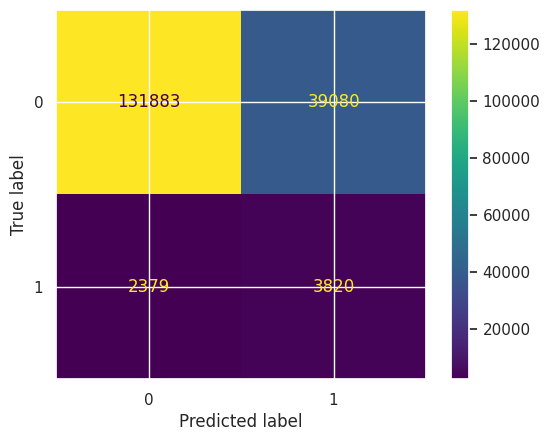

In [149]:
conf_matrix(y_valid, y_pred_valid_LR_sc)

In [150]:
print(classification_report(y_valid, y_pred_valid_LR_sc))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.62      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



#### По матрице ошибок и отчёту классификации видно, что полнота предсказаных значений класса ```1``` **значительно выросла**

#### Теперь попробуем убрать шум в данных при помощи **метода главных компонент**

In [151]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
220533      -0.518830       -0.102442   0.764445  1.769946  1.202704   
162542      -0.902487        0.097352   0.764445  0.072578 -2.184642   
136171      -1.056077        6.256044   0.764445  1.413161 -0.222905   
110035      -1.186658        0.229281  -0.389375 -0.771240  1.373290   
21860       -1.535424       -0.470134   0.764445  0.303049  0.020789   
...               ...             ...        ...       ...       ...   
544797       1.515197       -0.102442   0.764445 -1.320187  1.306274   
573159       1.698308       -0.504689  -1.543195  1.323706 -0.935710   
566209       1.653549       -0.146405   0.764445 -0.050423 -0.222905   
589166       1.823746       -0.334248   0.764445 -1.110009 -0.527523   
39234       -1.451934       -0.511332  -1.543195  1.271731  1.141781   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
220533 -1.200708  0.018962  0.717344 -0.128422  0.561813      -0.497620   
162542  0.713018 -1.193371  0.717344 -0.278385  0.561813       1.970449   
136171  0.713018  0.018962  0.717344  0.262787  0.561813       1.970449   
110035  0.713018  0.678301 -1.311410  0.490992  0.561813      -0.302773   
21860   0.713018  0.678301  0.717344  0.693116  0.561813       0.541567   
...          ...       ...       ...       ...       ...            ...   
544797 -1.200708  0.635763  0.717344  1.364692  0.561813       0.541567   
573159  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
566209  0.713018  0.678301  0.717344  0.047622  0.561813       0.541567   
589166  0.713018  0.678301 -1.311410  0.653996  0.561813      -1.406909   
39234   0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.042976   

              C3        D3        V1       V55     V107      V121      V281  \
220533 -0.027289  0.089546 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   
162542 -0.027289  0.089546 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   
136171 -0.027289  0.152338 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   
110035 -0.027289  0.089546 -0.005126 -0.090994  0.01747 -0.077832 -0.228787   
21860  -0.027289 -0.272714 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   
...          ...       ...       ...       ...      ...       ...       ...   
544797 -0.027289 -0.247711  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
573159 -0.027289  0.089546 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   
566209 -0.027289  0.089546  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
589166 -0.027289 -0.622757  0.013962 -0.241324  0.01747 -0.077832 -0.228787   
39234  -0.027289  0.089546 -0.005126 -0.241324  0.01747 -0.077832 -0.228787   

            V286      V305  
220533 -0.171824 -0.002889  
162542 -0.171824 -0.002889  
136171 -0.171824 -0.002889  
110035 -0.171824 -0.002889  
21860  -0.171824 -0.002889  
...          ...       ...  
544797 -0.171824 -0.002889  
573159 -0.171824 -0.002889  
566209 -0.171824 -0.002889  
589166 -0.171824 -0.002889  
39234  -0.171824 -0.002889  

[239725 rows x 20 columns]

In [152]:
from sklearn import decomposition

In [153]:
pca = decomposition.PCA()
pca.fit(X_train_sc)
X_train_norm = pca.transform(X_train_sc)
X_valid_norm = pca.transform(X_valid_sc)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [154]:
pca.explained_variance_ratio_

array([0.146264  , 0.08190074, 0.06772465, 0.05850786, 0.05289798,
       0.05139272, 0.05017173, 0.05005342, 0.05000072, 0.04995121,
       0.04859458, 0.04784408, 0.04636995, 0.04459475, 0.04376152,
       0.03540736, 0.03117219, 0.02382883, 0.01461298, 0.00494874])

Видим, что большая часть компонент вносит примерно равный вклад в разброс исходных данных, поэтому будем обучать модель с использованием всех компонент

In [155]:
model_LR_norm = LogisticRegression()
model_LR_norm.fit(X_train_norm, y_train_balanced)

LogisticRegression()

In [156]:
y_pred_valid_LR_norm = model_LR_norm.predict(X_valid_norm)

In [157]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_norm == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7659825470473353


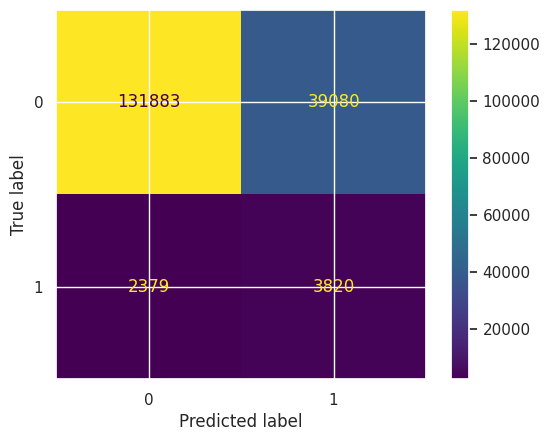

In [158]:
conf_matrix(y_valid, y_pred_valid_LR_norm)

In [159]:
print(classification_report(y_valid, y_pred_valid_LR_norm))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.62      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



### Попробуем сделать прогнозы с использованием других, более сложных моделей

Напишем функцию, которая будет обучать модели, делать прогнозы и предоставлять отчёт по качеству прогнозов

In [160]:
def fit_pred_score(model, model_name, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    print('------------------------------')
    print(model_name)
    print(f'Доля верно угаданных объектов {(y_pred == y_valid).sum() / len(y_valid)}')
    conf_matrix(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print('roc auc score: ', roc_auc_score(y_valid, y_pred_proba))
    return model, roc_auc

------------------------------
DecisionTree
Доля верно угаданных объектов 0.930442194149987


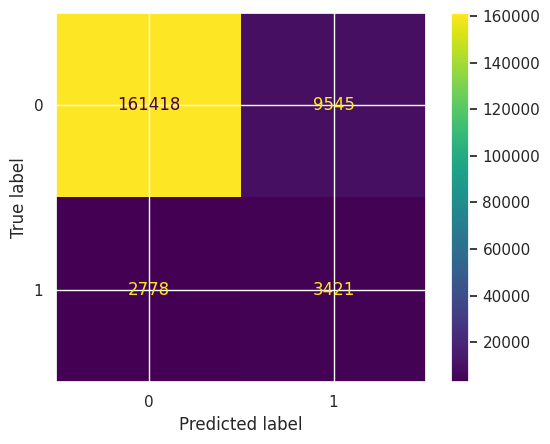

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.26      0.55      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.62      0.75      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7480162049725255


In [161]:
DTmodel, DT_roc_auc_score = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9664713651911809


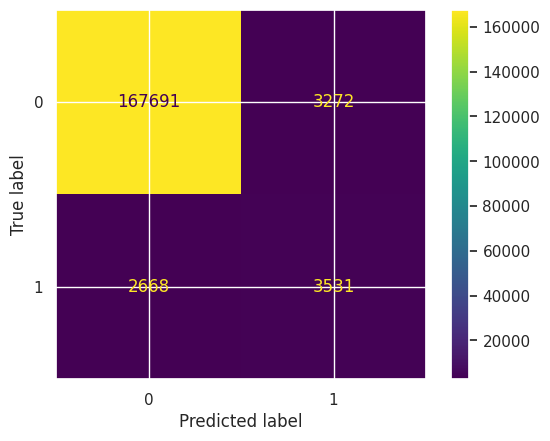

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.52      0.57      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9132933615073505


In [162]:
RFmodel, RF_roc_auc_score = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7764193224280602


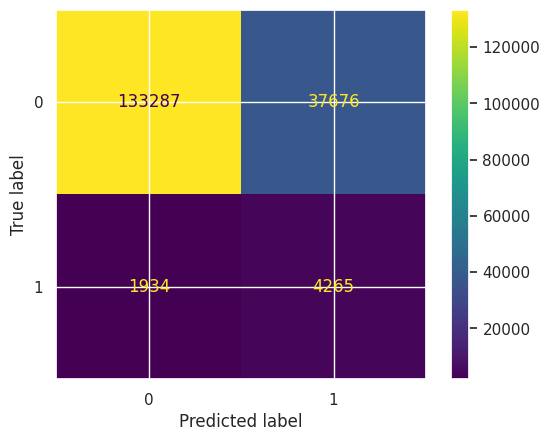

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.10      0.69      0.18      6199

    accuracy                           0.78    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.95      0.78      0.85    177162

roc auc score:  0.8045423009519299


In [163]:
AdaBoost_model, AdaBoost_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.7790891951998735


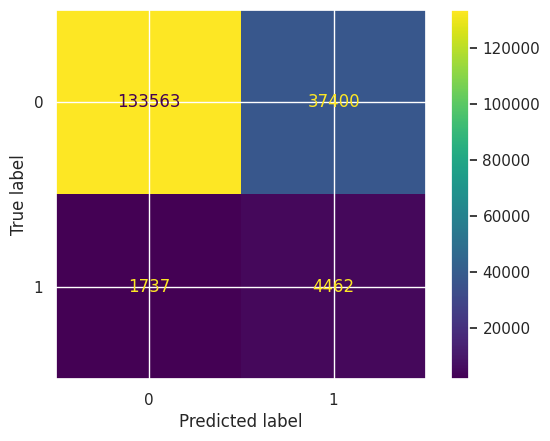

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.72      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.75      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8292430133187525


In [164]:
GBM_model, GBM_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8749223874194241


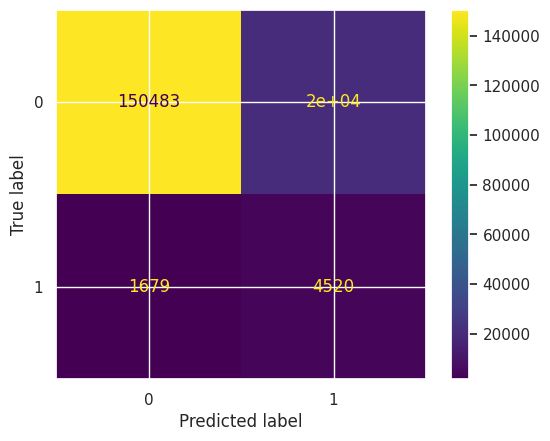

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    170963
           1       0.18      0.73      0.29      6199

    accuracy                           0.87    177162
   macro avg       0.58      0.80      0.61    177162
weighted avg       0.96      0.87      0.91    177162

roc auc score:  0.8857791536495875


In [165]:
XGB_model, XGB_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8345751346225488


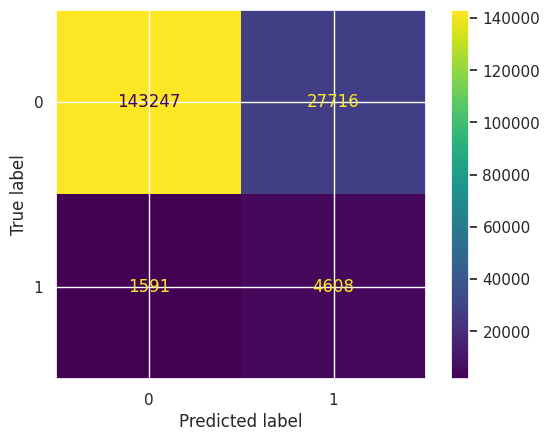

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    170963
           1       0.14      0.74      0.24      6199

    accuracy                           0.83    177162
   macro avg       0.57      0.79      0.57    177162
weighted avg       0.96      0.83      0.88    177162

roc auc score:  0.8684118548155344


In [166]:
LGBM_model, LGBM_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Сделаем общую таблицу по основной метрике качества этого задания ```roc auc score```, чтобы наглядно увидеть лучшую модель:

In [167]:
roc_auc_df = pd.DataFrame(data=[DT_roc_auc_score, 
                                RF_roc_auc_score,
                                AdaBoost_roc_auc_score,
                                GBM_roc_auc_score,
                                XGB_roc_auc_score,
                                LGBM_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                         columns=['roc auc score'])
roc_auc_df

roc auc score
DT             0.748016
RF             0.913293
AdaBoost       0.804542
GBM            0.829243
XGB            0.885779
LGBM           0.868412

### Видим, что классфикатор ```Random Forest``` показал наилучшую точность

#### Посмотрим на важность признаков:

In [168]:
print('DecesionTree important features:')
sorted(zip(X_train_sc.columns, DTmodel.feature_importances_), key=lambda x: -x[1])

DecesionTree important features:


[('TransactionDT', 0.19657113459323394),
 ('TransactionAmt', 0.14086483204653455),
 ('card1', 0.11285097291499266),
 ('addr2', 0.11250269377505404),
 ('addr1', 0.07618093456335004),
 ('D3', 0.0742683254800188),
 ('card2', 0.07234841278910917),
 ('P_emaildomain', 0.0626526300548836),
 ('V55', 0.05505757306999789),
 ('card5', 0.026306133541066458),
 ('V281', 0.017497856471869588),
 ('card6', 0.016864186635523484),
 ('ProductCD', 0.011414970365340187),
 ('card4', 0.009445943425721295),
 ('V1', 0.0061975691900135),
 ('V286', 0.004181942427659624),
 ('C3', 0.0027207003911066756),
 ('V121', 0.0016313072461919586),
 ('V107', 0.0004418810183324094),
 ('V305', 0.0)]

In [169]:
print('RandomForest important features:')
sorted(zip(X_train_sc.columns, RFmodel.feature_importances_), key=lambda x: -x[1])

RandomForest important features:


[('TransactionDT', 0.1673388285144057),
 ('TransactionAmt', 0.148689637865106),
 ('addr1', 0.10849138736547603),
 ('card1', 0.1000668116499987),
 ('D3', 0.08512632668037591),
 ('card2', 0.07821905802903216),
 ('P_emaildomain', 0.06857091980266307),
 ('ProductCD', 0.05088379288238396),
 ('addr2', 0.036554716060520784),
 ('card5', 0.03294757753775013),
 ('card6', 0.029366835246905094),
 ('V281', 0.02716750351567439),
 ('V55', 0.024981994391765197),
 ('V1', 0.0192117837777852),
 ('card4', 0.012497356694907846),
 ('V286', 0.005341886659062892),
 ('V121', 0.002299671229393068),
 ('C3', 0.0019254335465698183),
 ('V107', 0.00031564816460885706),
 ('V305', 2.830385615261434e-06)]

In [170]:
print('AdaBoost important features:')
sorted(zip(X_train_sc.columns, AdaBoost_model.feature_importances_), key=lambda x: -x[1])

AdaBoost important features:


[('TransactionAmt', 0.14),
 ('card2', 0.14),
 ('V55', 0.14),
 ('card1', 0.08),
 ('P_emaildomain', 0.08),
 ('D3', 0.08),
 ('TransactionDT', 0.06),
 ('card4', 0.04),
 ('card6', 0.04),
 ('V281', 0.04),
 ('ProductCD', 0.02),
 ('card5', 0.02),
 ('addr1', 0.02),
 ('addr2', 0.02),
 ('C3', 0.02),
 ('V1', 0.02),
 ('V121', 0.02),
 ('V286', 0.02),
 ('V107', 0.0),
 ('V305', 0.0)]

In [171]:
print('GradientBoosting important features:')
sorted(zip(X_train_sc.columns, GBM_model.feature_importances_), key=lambda x: -x[1])

GradientBoosting important features:


[('ProductCD', 0.19990257911734588),
 ('D3', 0.1634048410746476),
 ('addr2', 0.15807490046621342),
 ('TransactionAmt', 0.10197036709822799),
 ('TransactionDT', 0.07166015798195817),
 ('card6', 0.060173970160148),
 ('V55', 0.052998492303692066),
 ('V281', 0.05064266956157969),
 ('P_emaildomain', 0.04906737290925178),
 ('card2', 0.02841316040805732),
 ('card1', 0.019988716653615377),
 ('addr1', 0.018084392300608668),
 ('V286', 0.008138706296392365),
 ('C3', 0.00540856896013041),
 ('card5', 0.004608795542185407),
 ('card4', 0.004329452417387722),
 ('V121', 0.0022120615422040264),
 ('V1', 0.000785332340379651),
 ('V107', 0.00013546286597452035),
 ('V305', 0.0)]

In [172]:
print('XGB important features:')
sorted(zip(X_train_sc.columns, XGB_model.feature_importances_), key=lambda x: -x[1])

XGB important features:


[('addr2', 0.5068966),
 ('V55', 0.069575146),
 ('ProductCD', 0.065035775),
 ('card6', 0.05296551),
 ('V281', 0.050105385),
 ('D3', 0.039736703),
 ('C3', 0.028452618),
 ('V286', 0.02627576),
 ('TransactionAmt', 0.020583333),
 ('P_emaildomain', 0.020423204),
 ('V121', 0.01880101),
 ('card2', 0.017785195),
 ('card1', 0.015112549),
 ('card5', 0.014834369),
 ('TransactionDT', 0.014648152),
 ('addr1', 0.013737601),
 ('card4', 0.009052335),
 ('V1', 0.008429005),
 ('V107', 0.00754974),
 ('V305', 0.0)]

In [173]:
print('LGB important features:')
sorted(zip(X_train_sc.columns, LGBM_model.feature_importances_), key=lambda x: -x[1])

LGB important features:


[('TransactionAmt', 429),
 ('card1', 418),
 ('card2', 347),
 ('P_emaildomain', 319),
 ('TransactionDT', 318),
 ('addr1', 310),
 ('D3', 197),
 ('card5', 122),
 ('V55', 113),
 ('ProductCD', 108),
 ('card6', 76),
 ('V281', 70),
 ('addr2', 42),
 ('card4', 33),
 ('C3', 31),
 ('V1', 24),
 ('V286', 22),
 ('V121', 17),
 ('V107', 4),
 ('V305', 0)]

По большей части в моделях наименее важными считаются признаки:
```'V286'``` , ```'V121'```, ```'C3'```, ```'V107'```, ```'V305'```.
Удалим их из данных

In [174]:
not_important_feats = ['V286', 'V121', 'C3', 'V107', 'V305']
X_train_sc = X_train_sc.drop(columns=not_important_feats)
X_valid_sc = X_valid_sc.drop(columns=not_important_feats)

In [175]:
test_df_sc = test_df_sc.drop(columns=not_important_feats)

In [176]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
220533      -0.518830       -0.102442   0.764445  1.769946  1.202704   
162542      -0.902487        0.097352   0.764445  0.072578 -2.184642   
136171      -1.056077        6.256044   0.764445  1.413161 -0.222905   
110035      -1.186658        0.229281  -0.389375 -0.771240  1.373290   
21860       -1.535424       -0.470134   0.764445  0.303049  0.020789   
...               ...             ...        ...       ...       ...   
544797       1.515197       -0.102442   0.764445 -1.320187  1.306274   
573159       1.698308       -0.504689  -1.543195  1.323706 -0.935710   
566209       1.653549       -0.146405   0.764445 -0.050423 -0.222905   
589166       1.823746       -0.334248   0.764445 -1.110009 -0.527523   
39234       -1.451934       -0.511332  -1.543195  1.271731  1.141781   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
220533 -1.200708  0.018962  0.717344 -0.128422  0.561813      -0.497620   
162542  0.713018 -1.193371  0.717344 -0.278385  0.561813       1.970449   
136171  0.713018  0.018962  0.717344  0.262787  0.561813       1.970449   
110035  0.713018  0.678301 -1.311410  0.490992  0.561813      -0.302773   
21860   0.713018  0.678301  0.717344  0.693116  0.561813       0.541567   
...          ...       ...       ...       ...       ...            ...   
544797 -1.200708  0.635763  0.717344  1.364692  0.561813       0.541567   
573159  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
566209  0.713018  0.678301  0.717344  0.047622  0.561813       0.541567   
589166  0.713018  0.678301 -1.311410  0.653996  0.561813      -1.406909   
39234   0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.042976   

              D3        V1       V55      V281  
220533  0.089546 -0.005126 -0.241324 -0.228787  
162542  0.089546 -0.005126 -0.241324 -0.228787  
136171  0.152338 -0.005126 -0.241324 -0.228787  
110035  0.089546 -0.005126 -0.090994 -0.228787  
21860  -0.272714 -0.005126 -0.241324 -0.228787  
...          ...       ...       ...       ...  
544797 -0.247711  0.013962 -0.241324 -0.228787  
573159  0.089546 -0.005126 -0.241324 -0.228787  
566209  0.089546  0.013962 -0.241324 -0.228787  
589166 -0.622757  0.013962 -0.241324 -0.228787  
39234   0.089546 -0.005126 -0.241324 -0.228787  

[239725 rows x 15 columns]

In [177]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
557643       1.596962       -0.374214   0.764445  1.165089 -0.222905   
288316      -0.097679       -0.472133   0.764445  0.057876 -1.502299   
296247      -0.044979        0.333194   0.764445  1.737021  1.275813   
363123       0.325666       -0.398394   0.764445  1.529742 -1.502299   
55549       -1.377924       -0.374214   0.764445 -0.506188 -1.502299   
...               ...             ...        ...       ...       ...   
395636       0.532737       -0.495193  -1.543195  1.271731  1.141781   
67004       -1.325355       -0.535799  -1.543195  1.153700 -0.947895   
568385       1.669562        1.644099   0.764445 -1.299894 -0.807771   
150004      -0.979509       -0.410184  -0.966285  1.311074  0.952918   
452819       0.891780       -0.102442   0.764445 -0.665426 -0.923525   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
557643  0.713018  0.678301  0.717344 -0.134942  0.561813      -0.497620   
288316  0.713018  0.678301  0.717344 -1.465052 -1.799457      -0.497620   
296247 -1.200708 -1.640020  0.717344 -0.128422  0.561813       0.411669   
363123 -1.200708  0.635763  0.717344  0.262787  0.561813      -1.341960   
55549  -1.200708  0.018962  0.717344 -0.128422  0.561813      -1.471858   
...          ...       ...       ...       ...       ...            ...   
395636  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
67004  -1.200708 -1.214640 -1.311410 -1.465052 -1.799457      -0.302773   
568385 -1.200708 -1.640020  0.717344  0.015021  0.561813      -1.017214   
150004 -1.200708 -1.959055 -1.311410 -0.128422  0.561813      -0.497620   
452819 -1.200708 -1.448599  0.717344  1.364692  0.561813       0.541567   

              D3        V1       V55      V281  
557643 -0.247711  0.013962 -0.241324 -0.228787  
288316  0.077421  0.013962 -0.241324 -0.228787  
296247  0.077421  0.013962 -0.241324 -0.228787  
363123 -0.572751  0.013962 -0.241324 -0.228787  
55549  -0.622757 -0.004548 -0.241324 -0.228787  
...          ...       ...       ...       ...  
395636  0.077421 -0.004548 -0.241324 -0.228787  
67004   0.077421 -0.004548 -0.241324 -0.228787  
568385  0.077421  0.013962 -0.241324 -0.228787  
150004  0.077421 -0.004548 -0.095445 -0.228787  
452819 -0.597754  0.013962 -0.241324 -0.228787  

[177162 rows x 15 columns]

In [178]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.402416       -0.442357   0.764445  0.137805 -1.502299   
1            2.402424       -0.374214   0.764445 -1.132994 -1.502299   
2            2.402435        0.113378   0.764445 -1.090752  1.318459   
3            2.402435        0.568798   0.764445  0.257907  0.014696   
4            2.402436       -0.298478   0.764445  1.713415  0.575192   
...               ...             ...        ...       ...       ...   
506686       5.895085       -0.191651  -1.543195  0.846612  0.106082   
506687       5.895087       -0.521399  -1.543195 -1.364501  0.307129   
506688       5.895096       -0.374214   0.764445  1.432418  0.806702   
506689       5.895098        0.237275   0.764445  1.424136  0.965103   
506690       5.895100       -0.472748  -1.543195 -0.834604 -1.155035   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.713018  0.678301  0.717344 -0.350107  0.561813      -0.497620   
1       0.713018  0.678301  0.717344  0.490992  0.561813      -1.406909   
2       0.713018  0.678301  0.717344  1.618977  0.561813      -0.302773   
3       0.713018 -0.597839  0.717344 -0.121902  0.561813      -0.497620   
4      -1.200708 -1.640020  0.717344  0.262787  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
506686 -1.200708  0.635763  0.717344  0.393190 -0.162668      -0.497620   
506687 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
506688  0.713018  0.678301  0.717344  0.673556  0.561813      -0.302773   
506689 -1.200708  0.635763  0.717344 -0.304466  0.561813      -0.302773   
506690  0.713018 -1.001950 -1.311410 -1.465052 -1.799457      -0.302773   

              D3        V1       V55      V281  
0       0.052325  0.013962 -0.241324 -0.228787  
1      -0.447736  0.013962 -0.241324 -0.228787  
2      -0.372727  0.013962 -0.241324 -0.228787  
3       0.402368  0.013962 -0.241324 -0.228787  
4      -0.622757  0.013962 -0.241324 -0.228787  
...          ...       ...       ...       ...  
506686  0.212213  0.012910 -0.241324 -0.228787  
506687 -0.222708  0.012910  1.960458  1.043537  
506688  0.212213  0.013962 -0.241324 -0.228787  
506689  0.212213  0.013962 -0.241324 -0.228787  
506690  0.212213  0.012910 -0.241324 -0.228787  

[506691 rows x 15 columns]

Теперь снова попробуем обучить наши модели:

------------------------------
DecisionTree
Доля верно угаданных объектов 0.930295435815807


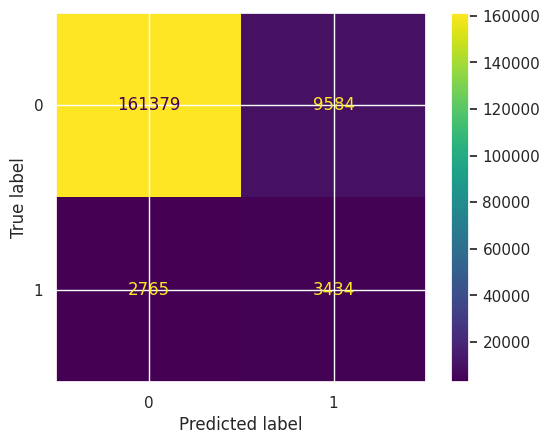

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.26      0.55      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.62      0.75      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7489507014239523


In [179]:
DT, DT_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RF
Доля верно угаданных объектов 0.9668326164753164


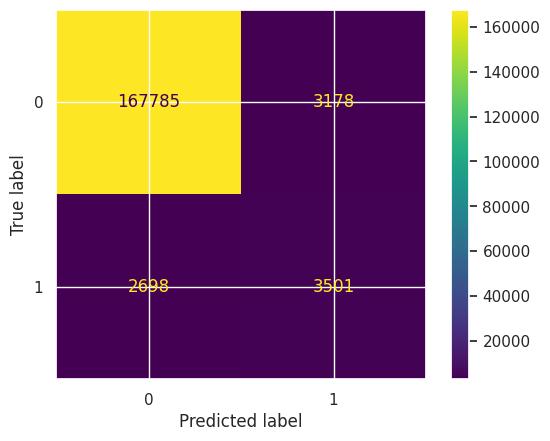

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.52      0.56      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.77      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9120676817140673


In [180]:
RF, RF_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7783723371829173


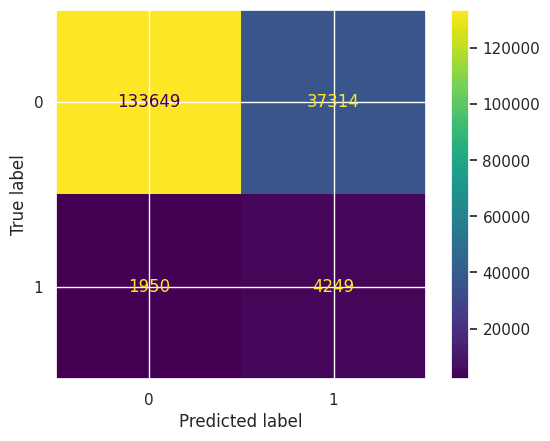

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.10      0.69      0.18      6199

    accuracy                           0.78    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.95      0.78      0.85    177162

roc auc score:  0.8032239706268176


In [181]:
AdaBoost, AdaBoost_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradBoost
Доля верно угаданных объектов 0.7809236743771237


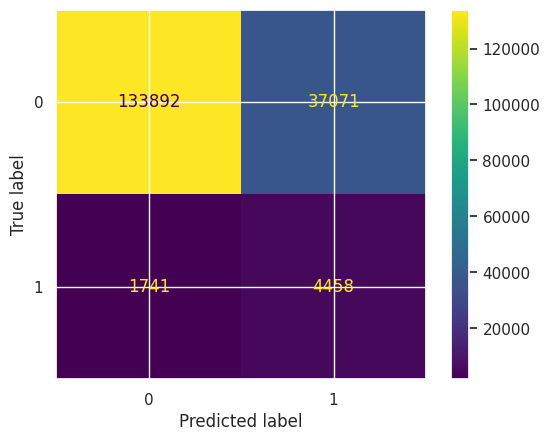

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.72      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.75      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8292763408447931


In [182]:
GradBoost, GradBoost_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8729637281132523


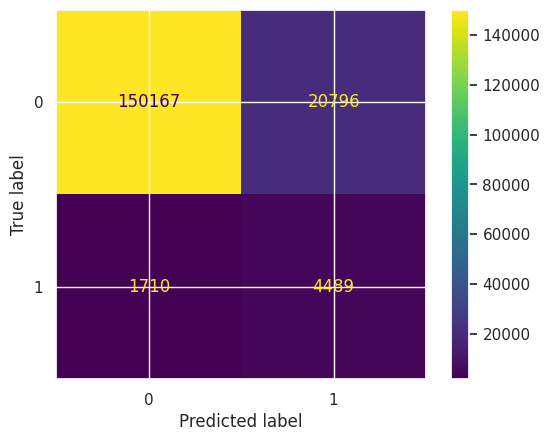

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    170963
           1       0.18      0.72      0.29      6199

    accuracy                           0.87    177162
   macro avg       0.58      0.80      0.61    177162
weighted avg       0.96      0.87      0.91    177162

roc auc score:  0.8831692254108595


In [183]:
XGB, XGB_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8313916076811054


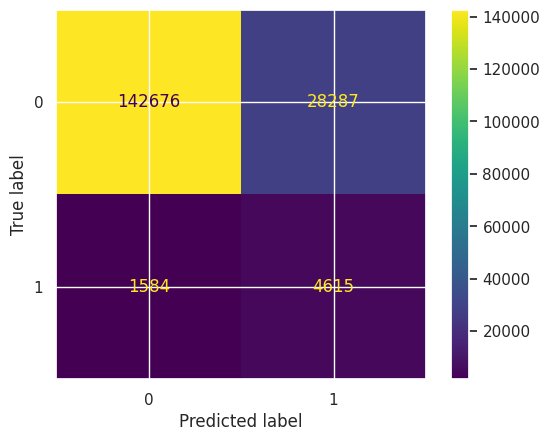

              precision    recall  f1-score   support

           0       0.99      0.83      0.91    170963
           1       0.14      0.74      0.24      6199

    accuracy                           0.83    177162
   macro avg       0.56      0.79      0.57    177162
weighted avg       0.96      0.83      0.88    177162

roc auc score:  0.8656286792066528


In [184]:
LGBM, LGBM_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Посмотрим и сравним оценки ```roc_auc``` до и после удаления не важных признаков

In [185]:
roc_auc_df2 = pd.DataFrame(data=[DT_roc_auc, 
                                 RF_roc_auc, 
                                 AdaBoost_roc_auc,
                                 GradBoost_roc_auc,
                                 XGB_roc_auc,
                                 LGBM_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score2'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df2], axis=1)
roc_auc_general

roc auc score  roc auc score2
DT             0.748016        0.748951
RF             0.913293        0.912068
AdaBoost       0.804542        0.803224
GBM            0.829243        0.829276
XGB            0.885779        0.883169
LGBM           0.868412        0.865629

Теперь уберём выбросы из данных и затем снова приступим к обучению моделей

Снова посмотрим на распределения оставшихся признаков

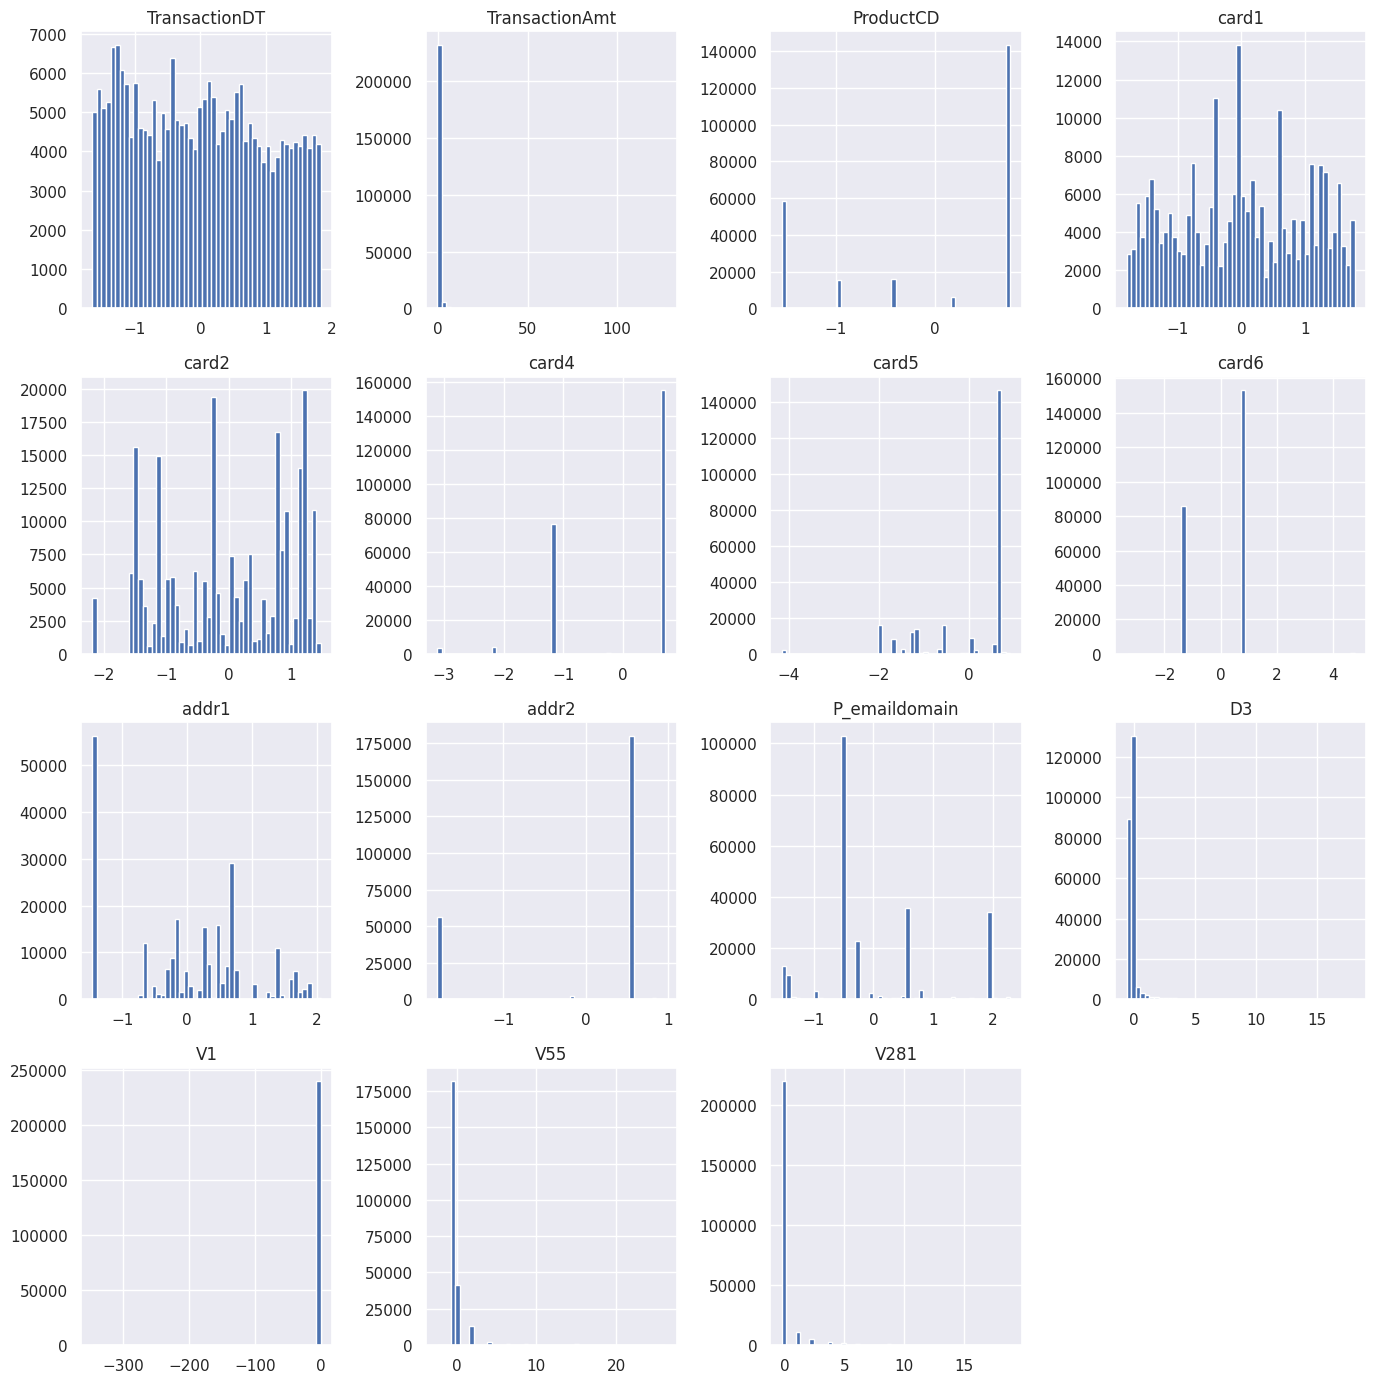

In [186]:
X_train_sc[X_train_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

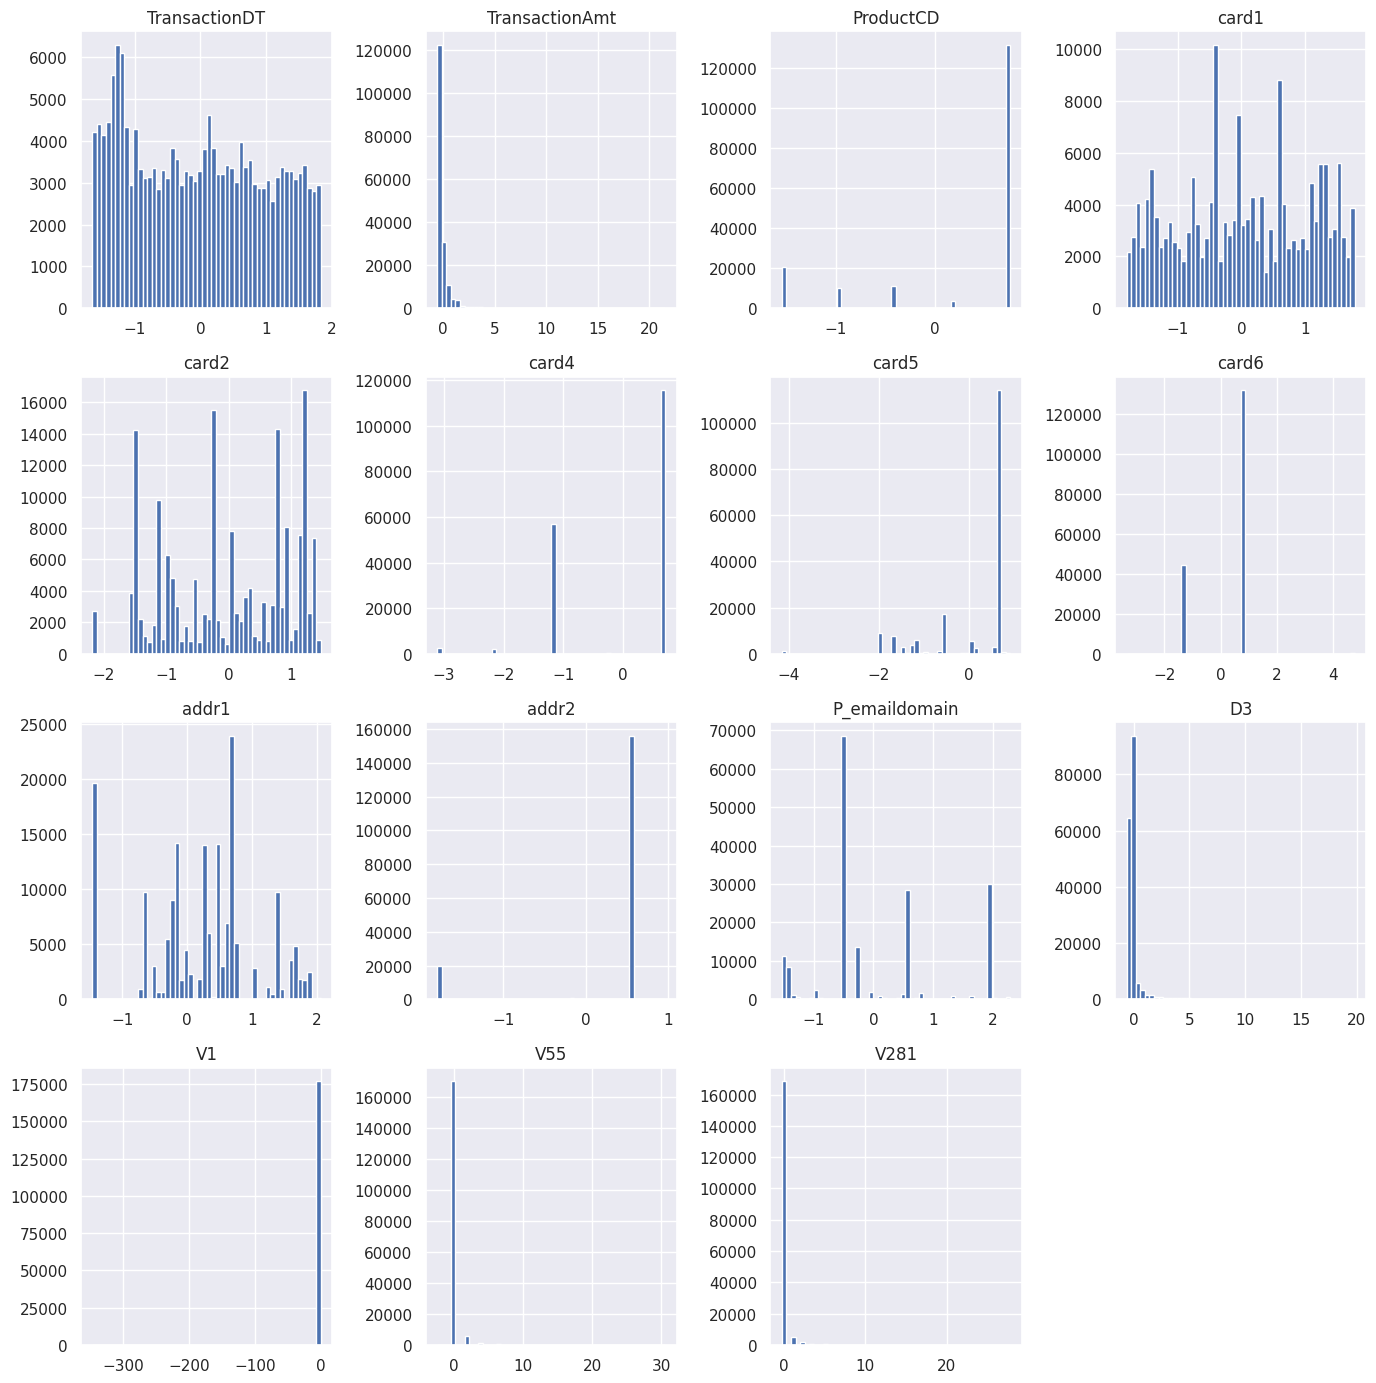

In [187]:
X_valid_sc[X_valid_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

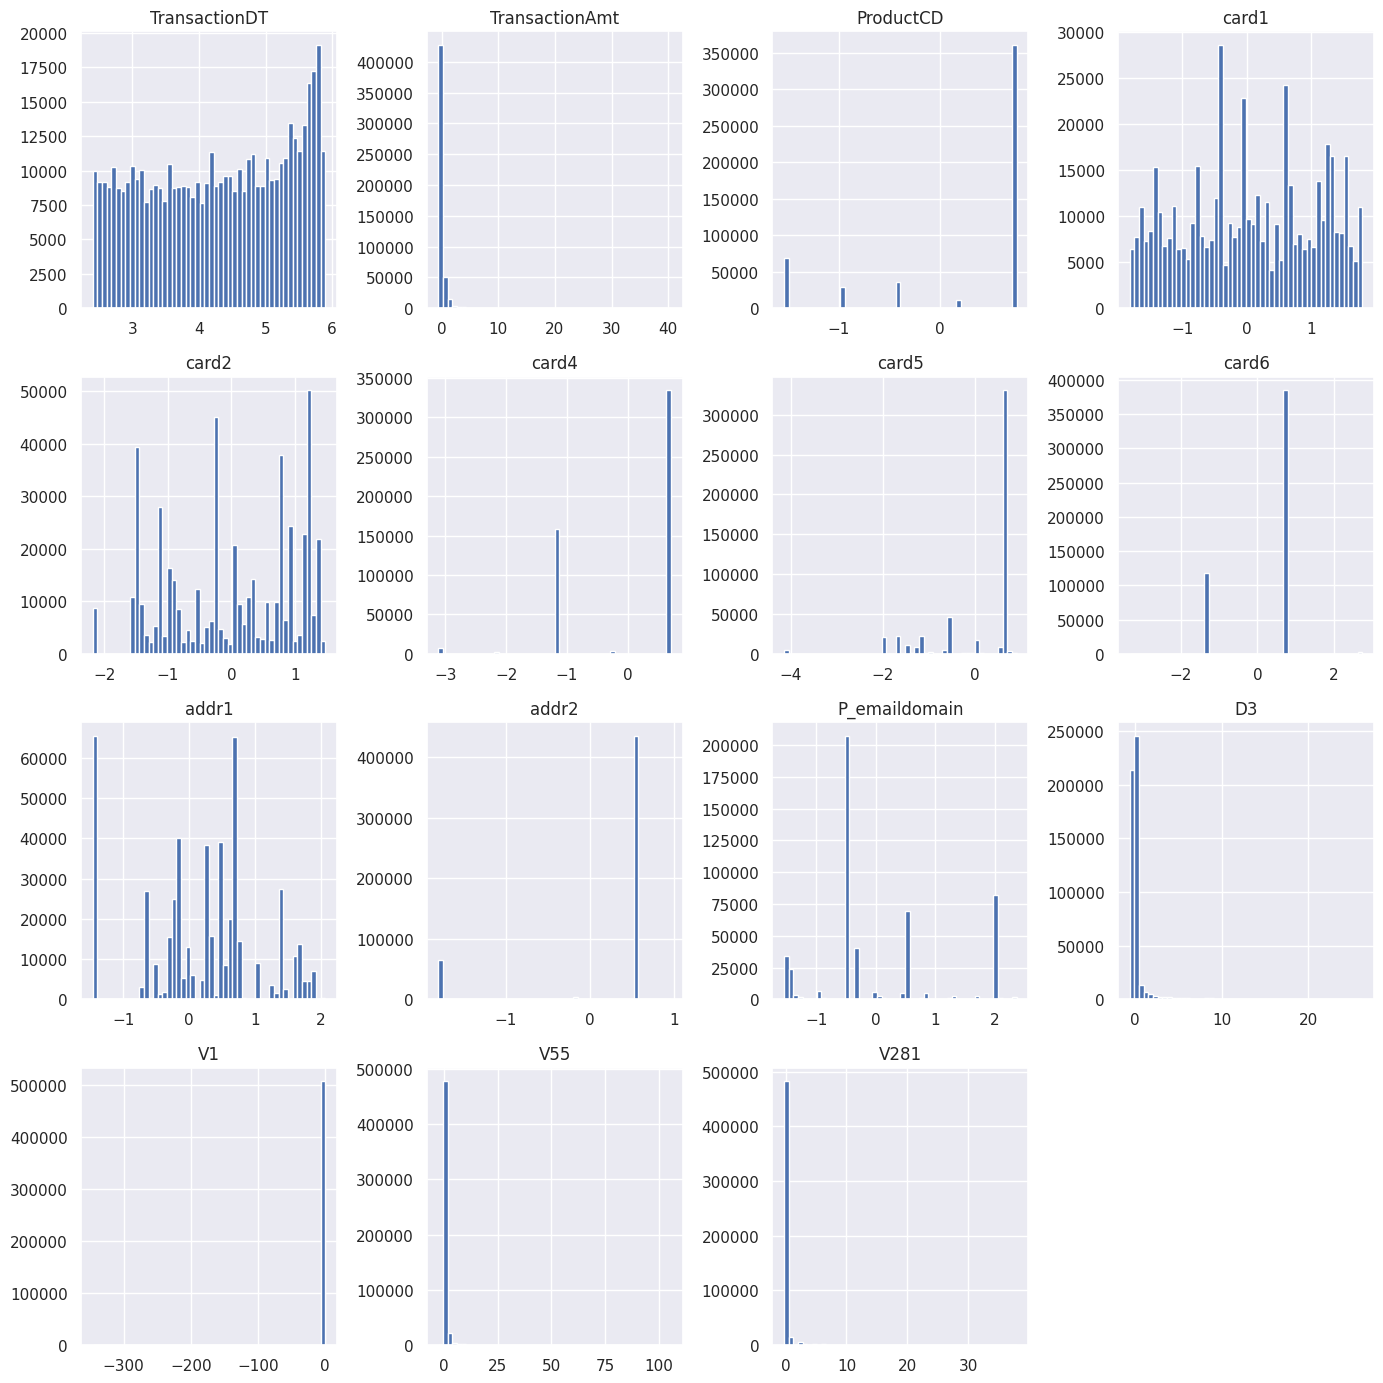

In [188]:
test_df_sc[test_df_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

А также на boxplotы

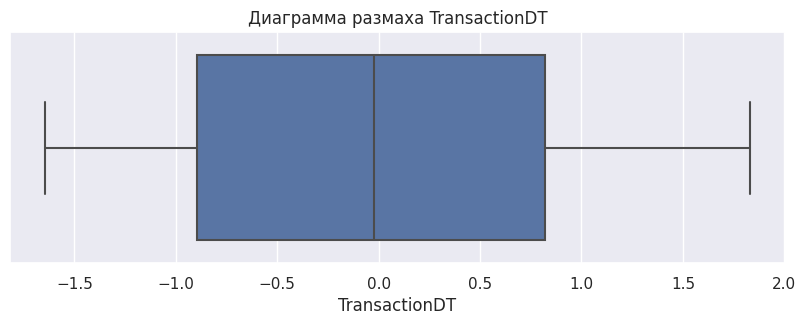

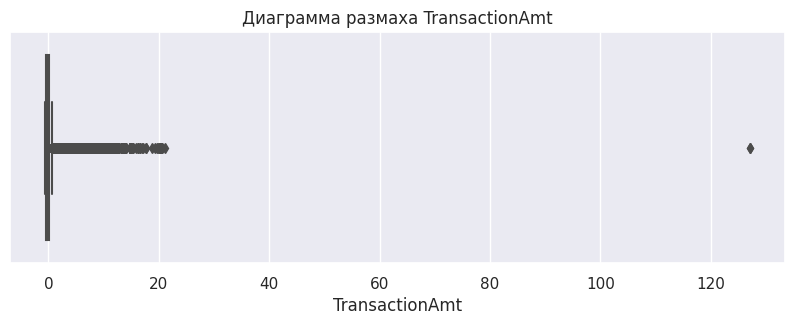

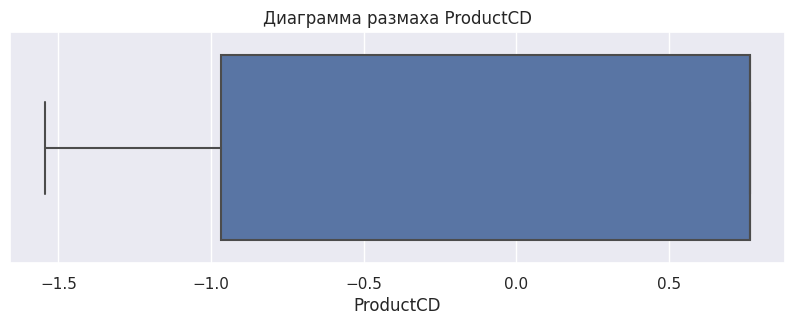

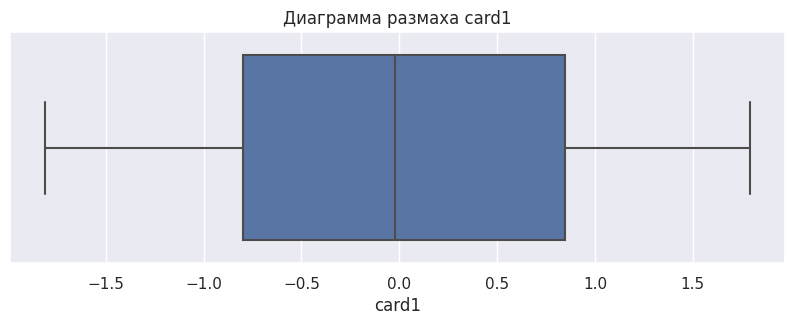

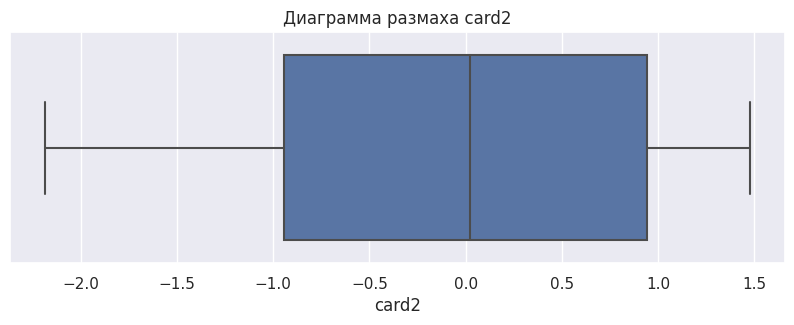

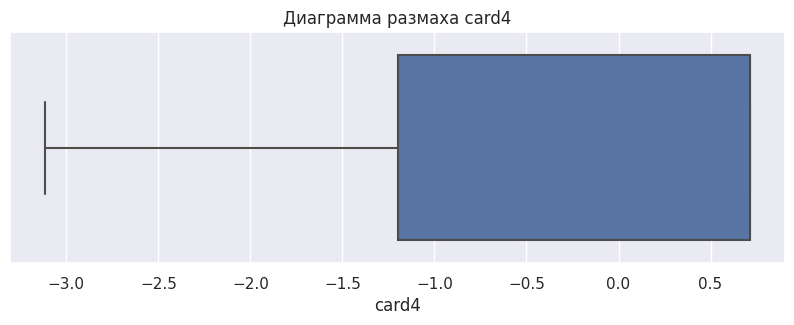

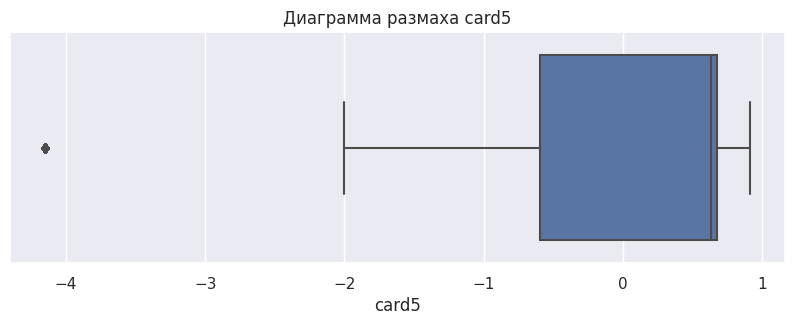

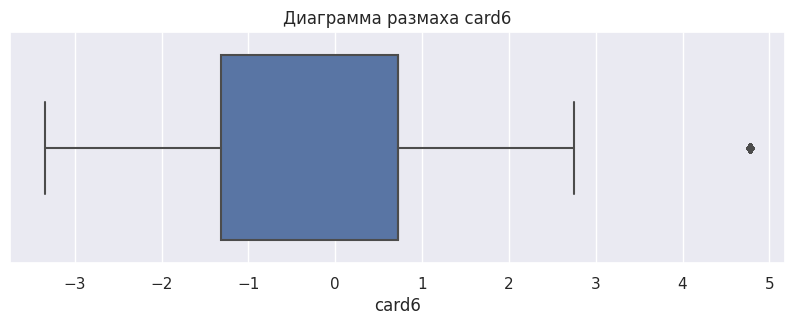

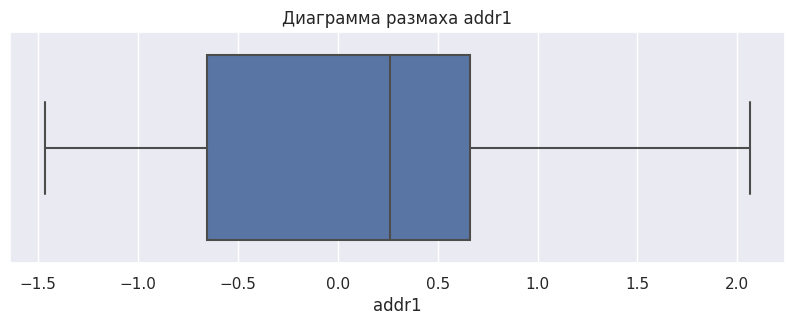

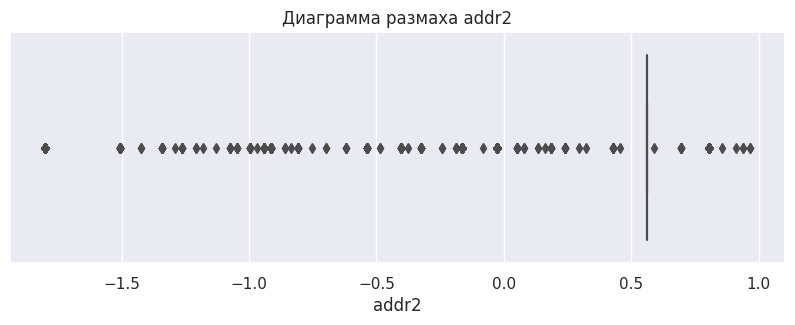

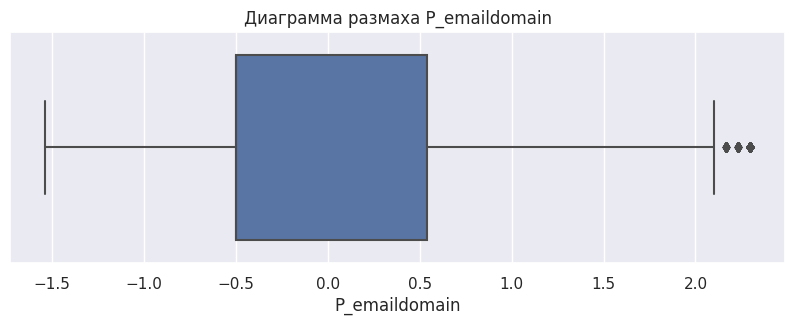

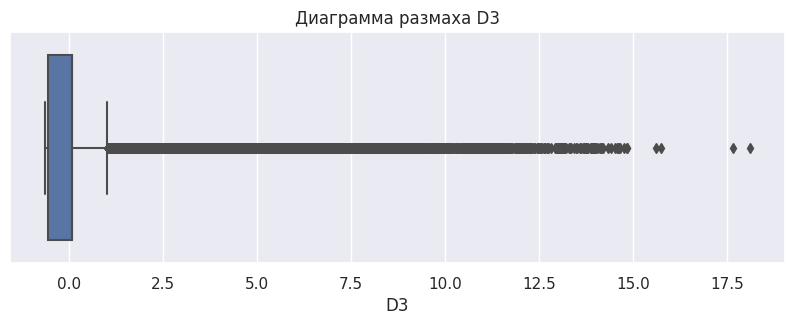

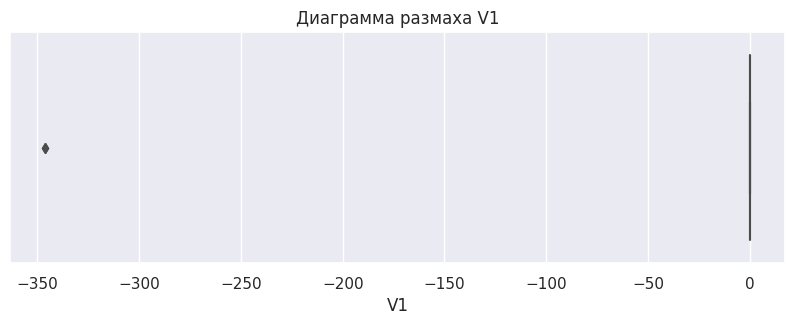

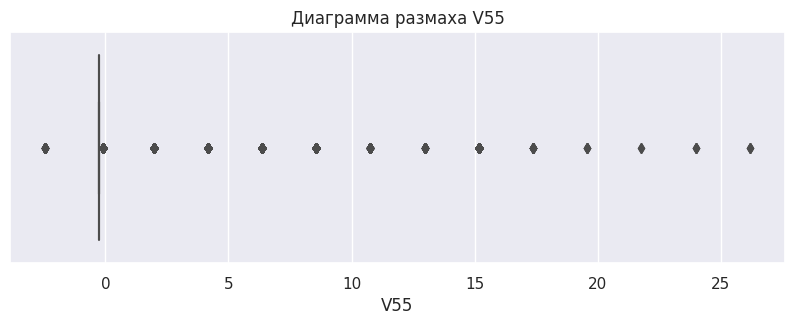

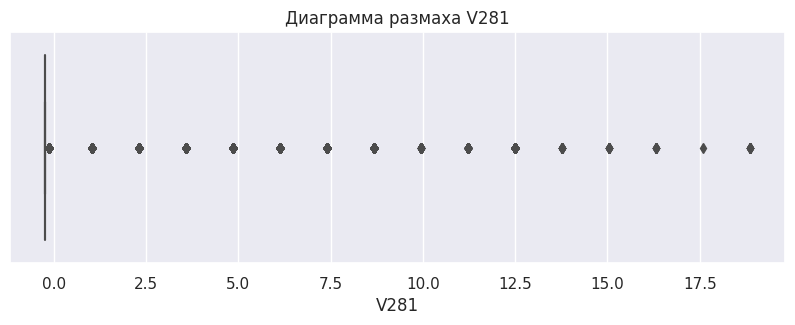

In [189]:
for feat in X_train_sc.columns:
    plt_boxplot(X_train_sc, feat)

Для валидационного датасета:

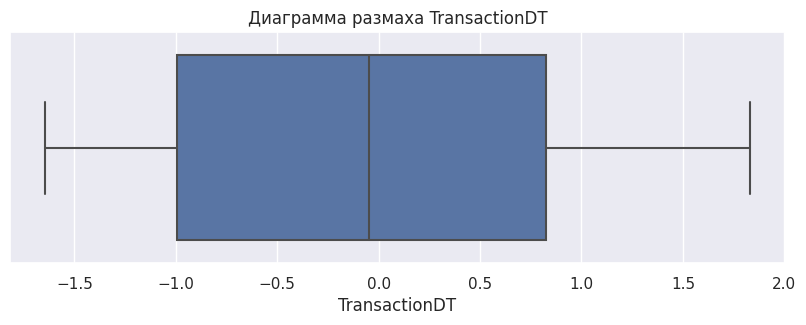

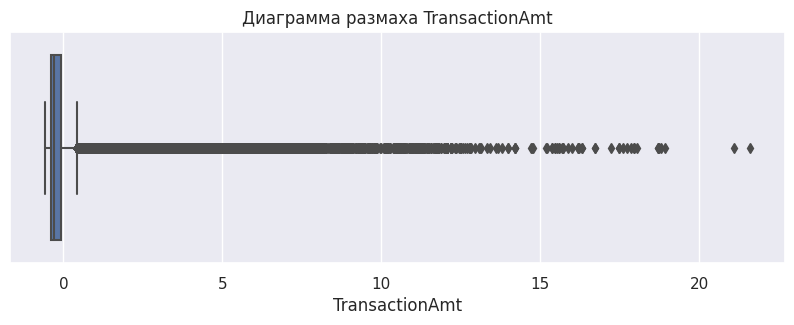

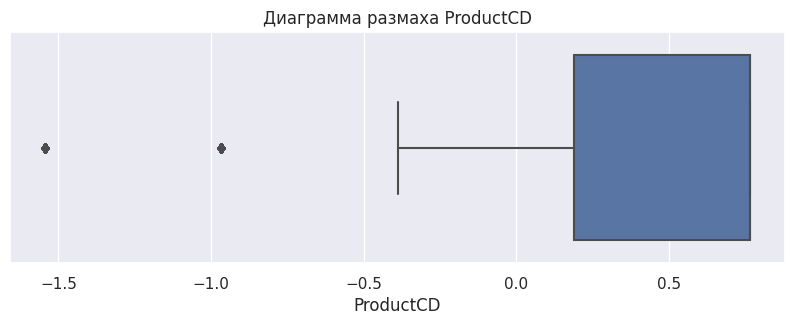

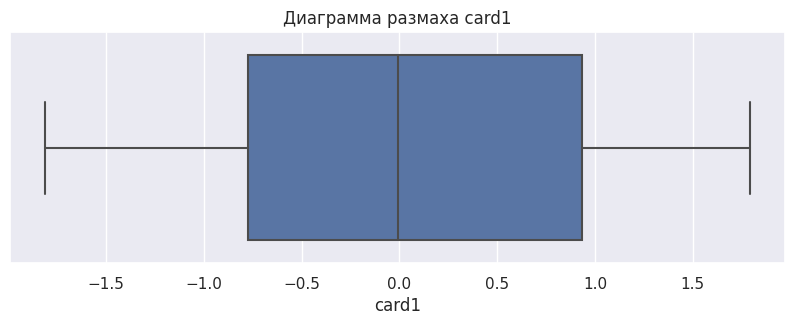

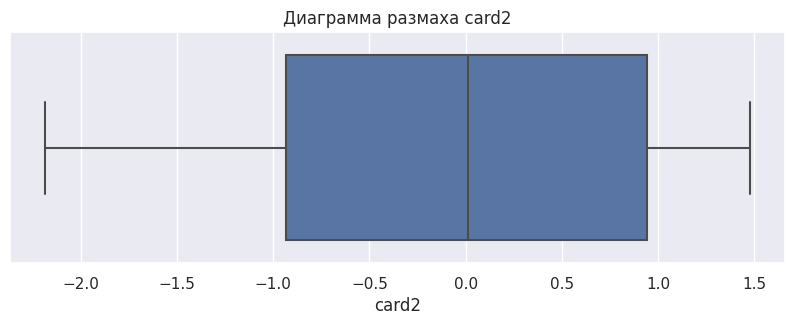

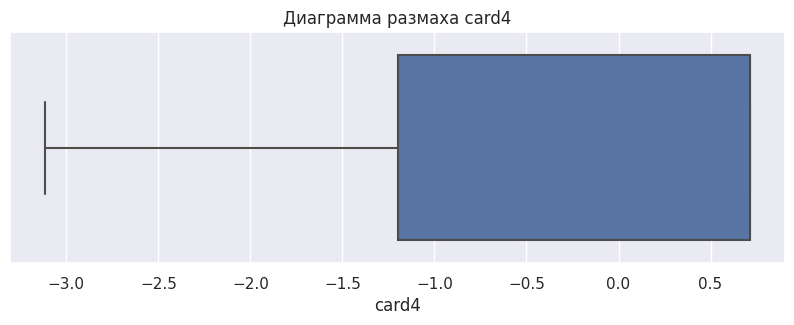

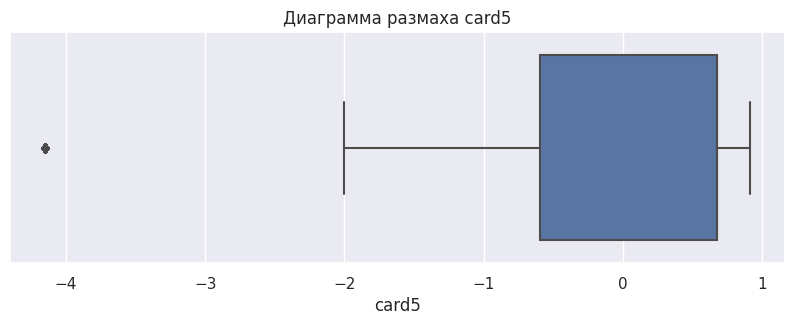

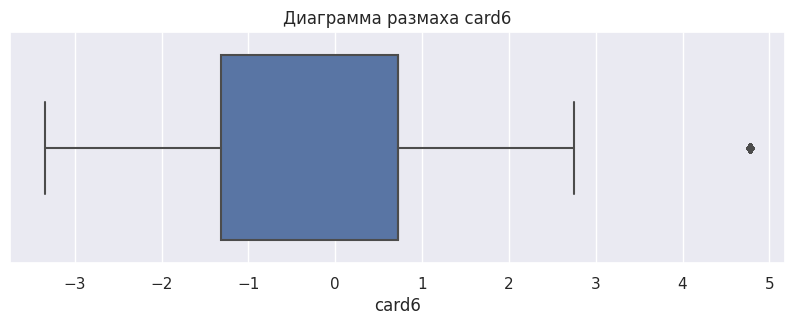

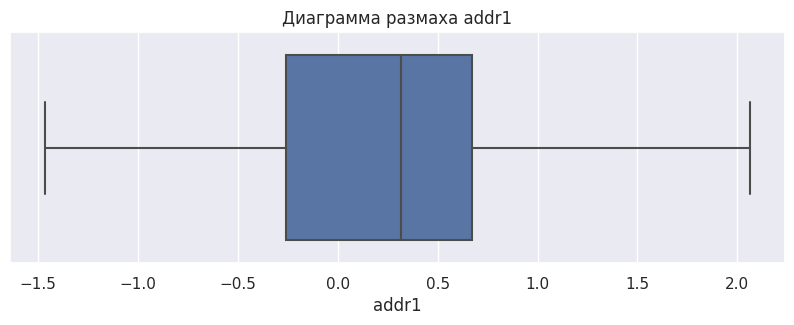

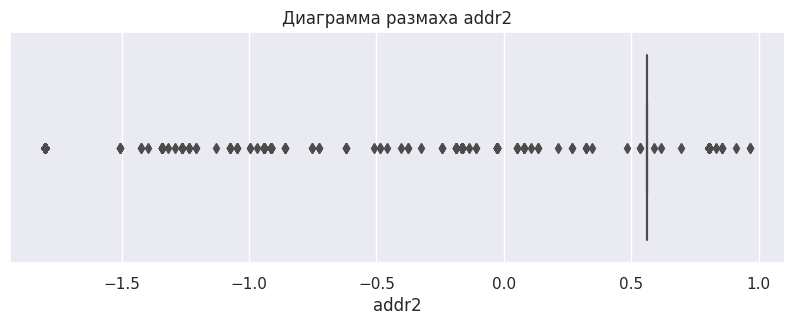

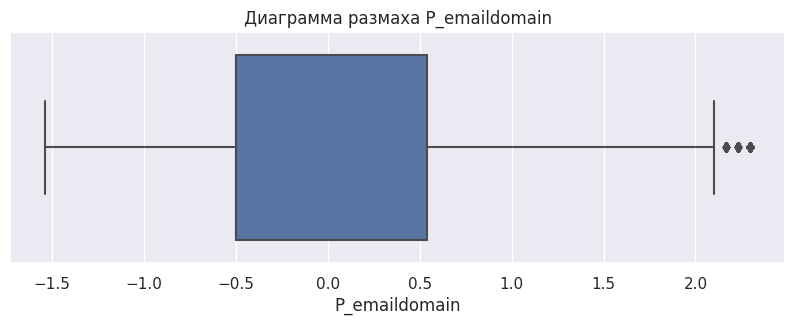

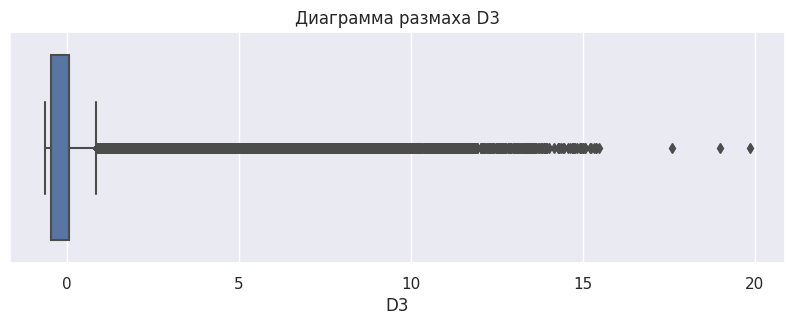

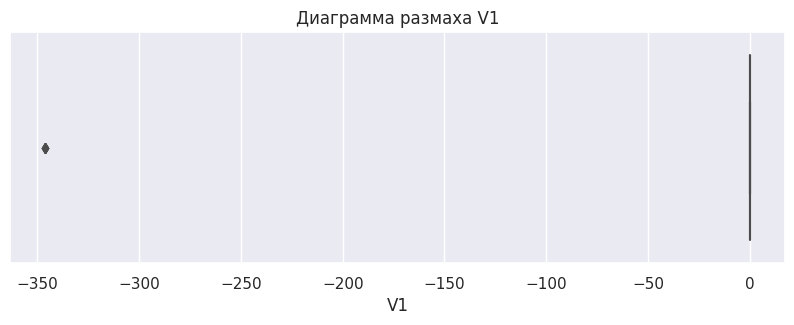

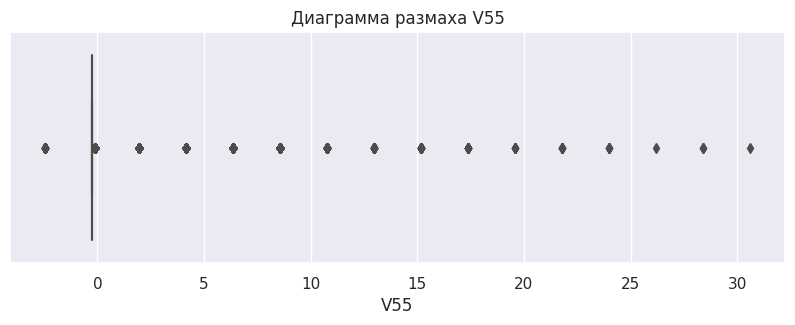

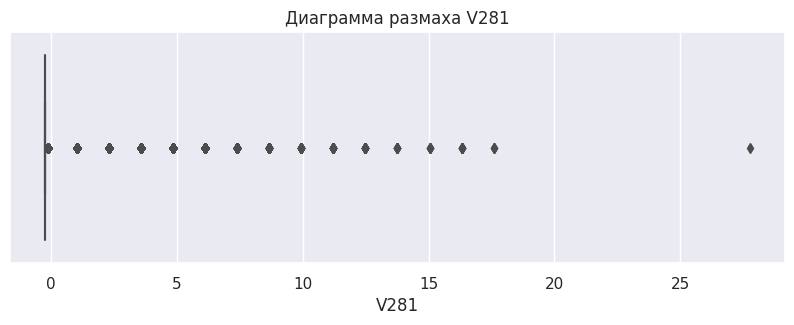

In [190]:
for feat in X_valid_sc.columns:
    plt_boxplot(X_valid_sc, feat)

Для тестового датасета

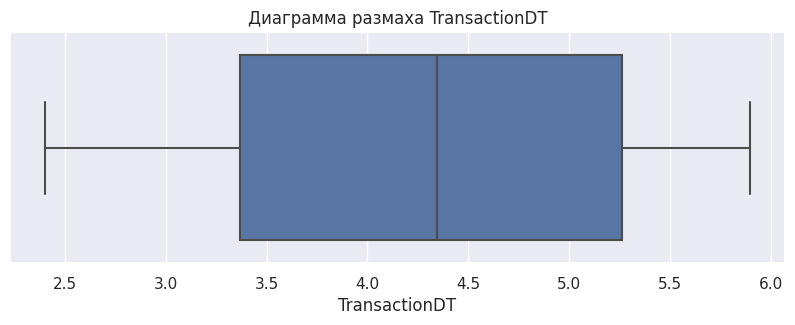

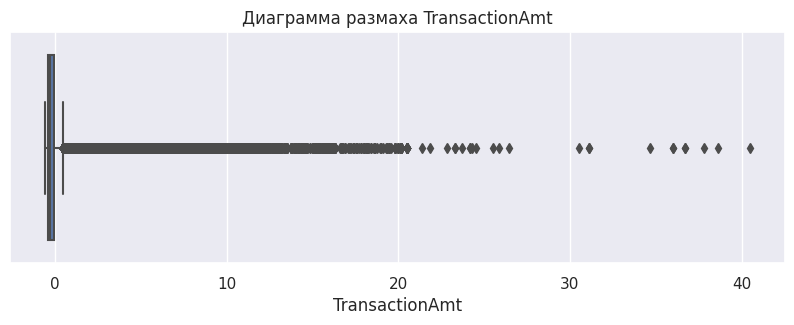

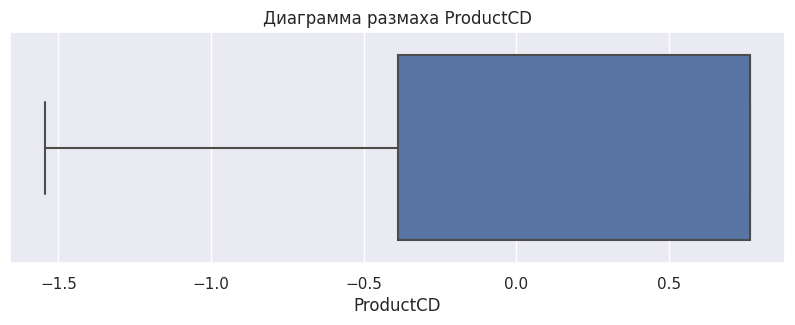

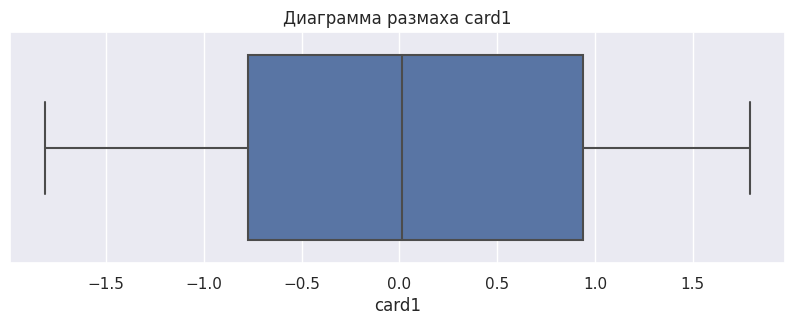

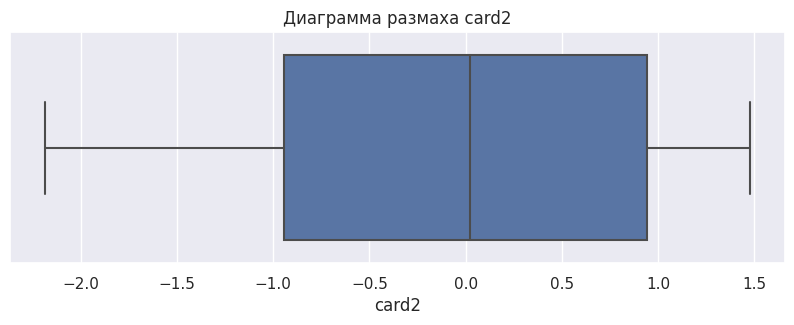

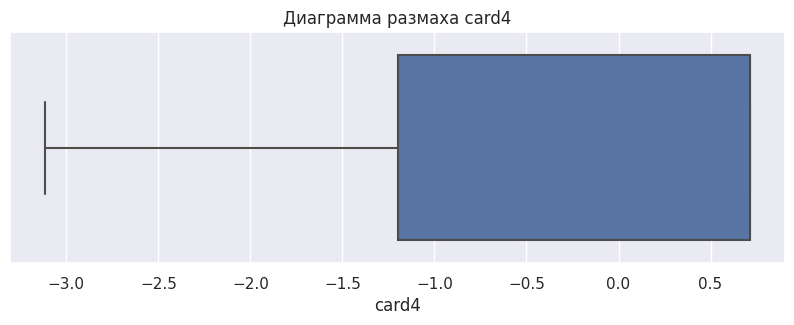

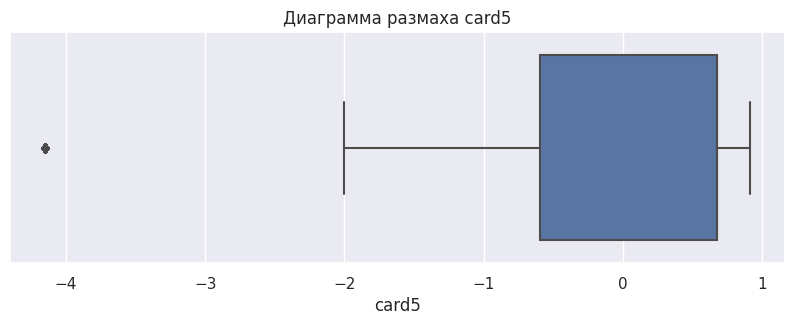

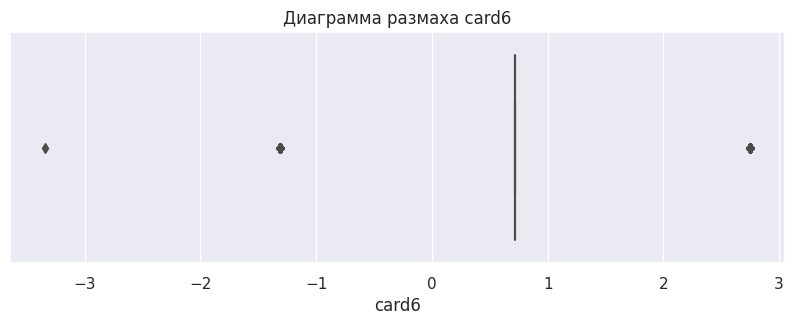

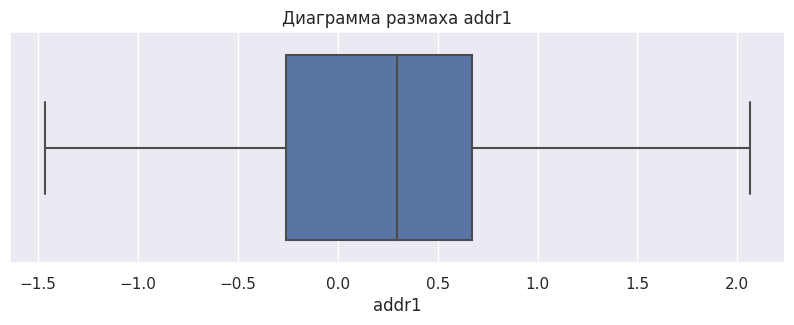

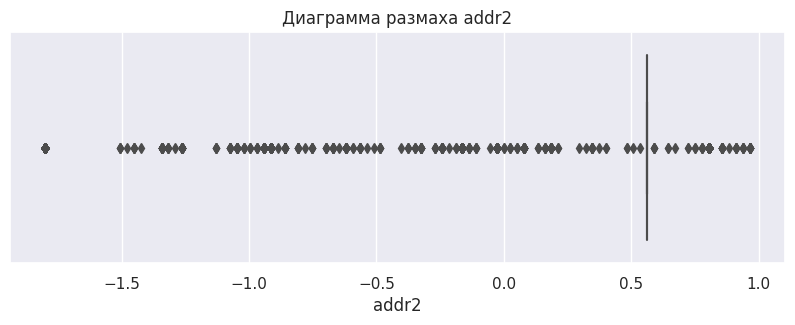

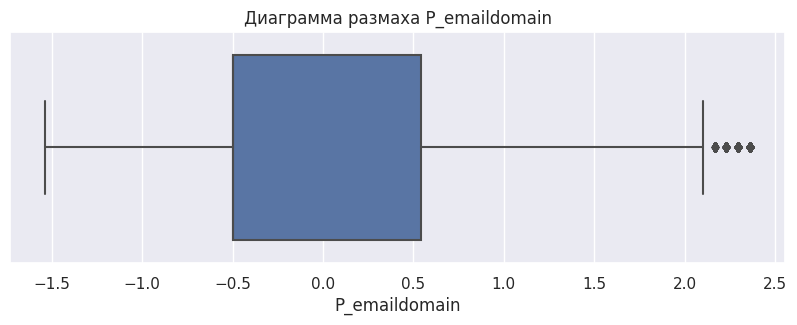

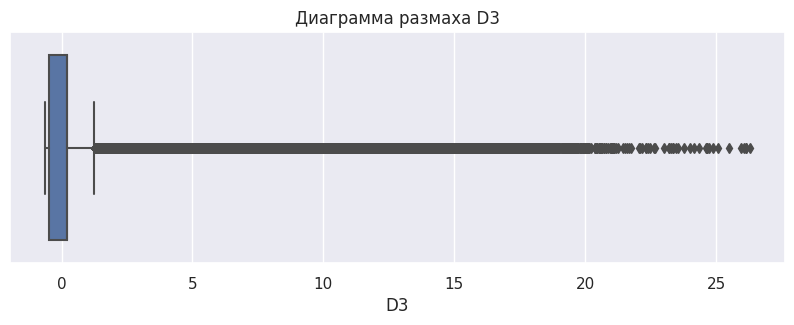

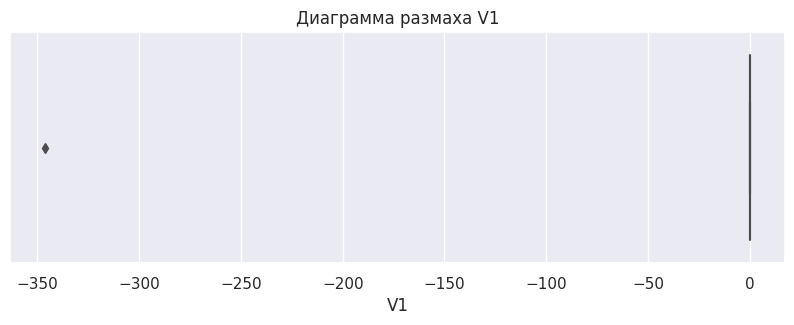

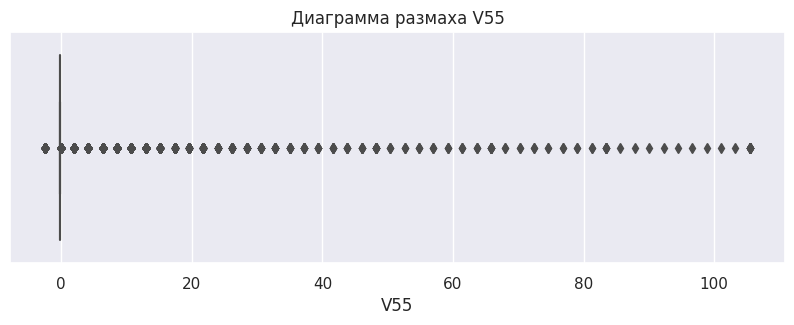

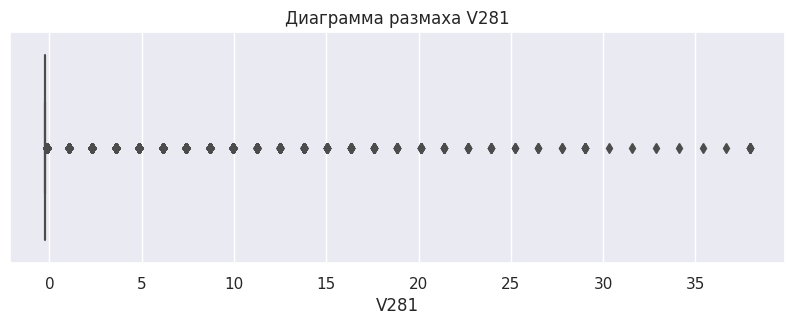

In [191]:
for feat in test_df_sc.columns:
    plt_boxplot(test_df_sc, feat)

Видим, что в признаках ```V1```, ```V55``` и ```V281``` очень много выбросов. Удалим эти признаки из данных

In [192]:
X_train_sc = X_train_sc.drop(columns=['V1', 'V55', 'V281'])
X_valid_sc = X_valid_sc.drop(columns=['V1', 'V55', 'V281'])
test_df_sc = test_df_sc.drop(columns=['V1', 'V55', 'V281'])

In [193]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
220533      -0.518830       -0.102442   0.764445  1.769946  1.202704   
162542      -0.902487        0.097352   0.764445  0.072578 -2.184642   
136171      -1.056077        6.256044   0.764445  1.413161 -0.222905   
110035      -1.186658        0.229281  -0.389375 -0.771240  1.373290   
21860       -1.535424       -0.470134   0.764445  0.303049  0.020789   
...               ...             ...        ...       ...       ...   
544797       1.515197       -0.102442   0.764445 -1.320187  1.306274   
573159       1.698308       -0.504689  -1.543195  1.323706 -0.935710   
566209       1.653549       -0.146405   0.764445 -0.050423 -0.222905   
589166       1.823746       -0.334248   0.764445 -1.110009 -0.527523   
39234       -1.451934       -0.511332  -1.543195  1.271731  1.141781   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
220533 -1.200708  0.018962  0.717344 -0.128422  0.561813      -0.497620   
162542  0.713018 -1.193371  0.717344 -0.278385  0.561813       1.970449   
136171  0.713018  0.018962  0.717344  0.262787  0.561813       1.970449   
110035  0.713018  0.678301 -1.311410  0.490992  0.561813      -0.302773   
21860   0.713018  0.678301  0.717344  0.693116  0.561813       0.541567   
...          ...       ...       ...       ...       ...            ...   
544797 -1.200708  0.635763  0.717344  1.364692  0.561813       0.541567   
573159  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
566209  0.713018  0.678301  0.717344  0.047622  0.561813       0.541567   
589166  0.713018  0.678301 -1.311410  0.653996  0.561813      -1.406909   
39234   0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.042976   

              D3  
220533  0.089546  
162542  0.089546  
136171  0.152338  
110035  0.089546  
21860  -0.272714  
...          ...  
544797 -0.247711  
573159  0.089546  
566209  0.089546  
589166 -0.622757  
39234   0.089546  

[239725 rows x 12 columns]

In [194]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
557643       1.596962       -0.374214   0.764445  1.165089 -0.222905   
288316      -0.097679       -0.472133   0.764445  0.057876 -1.502299   
296247      -0.044979        0.333194   0.764445  1.737021  1.275813   
363123       0.325666       -0.398394   0.764445  1.529742 -1.502299   
55549       -1.377924       -0.374214   0.764445 -0.506188 -1.502299   
...               ...             ...        ...       ...       ...   
395636       0.532737       -0.495193  -1.543195  1.271731  1.141781   
67004       -1.325355       -0.535799  -1.543195  1.153700 -0.947895   
568385       1.669562        1.644099   0.764445 -1.299894 -0.807771   
150004      -0.979509       -0.410184  -0.966285  1.311074  0.952918   
452819       0.891780       -0.102442   0.764445 -0.665426 -0.923525   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
557643  0.713018  0.678301  0.717344 -0.134942  0.561813      -0.497620   
288316  0.713018  0.678301  0.717344 -1.465052 -1.799457      -0.497620   
296247 -1.200708 -1.640020  0.717344 -0.128422  0.561813       0.411669   
363123 -1.200708  0.635763  0.717344  0.262787  0.561813      -1.341960   
55549  -1.200708  0.018962  0.717344 -0.128422  0.561813      -1.471858   
...          ...       ...       ...       ...       ...            ...   
395636  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
67004  -1.200708 -1.214640 -1.311410 -1.465052 -1.799457      -0.302773   
568385 -1.200708 -1.640020  0.717344  0.015021  0.561813      -1.017214   
150004 -1.200708 -1.959055 -1.311410 -0.128422  0.561813      -0.497620   
452819 -1.200708 -1.448599  0.717344  1.364692  0.561813       0.541567   

              D3  
557643 -0.247711  
288316  0.077421  
296247  0.077421  
363123 -0.572751  
55549  -0.622757  
...          ...  
395636  0.077421  
67004   0.077421  
568385  0.077421  
150004  0.077421  
452819 -0.597754  

[177162 rows x 12 columns]

In [195]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.402416       -0.442357   0.764445  0.137805 -1.502299   
1            2.402424       -0.374214   0.764445 -1.132994 -1.502299   
2            2.402435        0.113378   0.764445 -1.090752  1.318459   
3            2.402435        0.568798   0.764445  0.257907  0.014696   
4            2.402436       -0.298478   0.764445  1.713415  0.575192   
...               ...             ...        ...       ...       ...   
506686       5.895085       -0.191651  -1.543195  0.846612  0.106082   
506687       5.895087       -0.521399  -1.543195 -1.364501  0.307129   
506688       5.895096       -0.374214   0.764445  1.432418  0.806702   
506689       5.895098        0.237275   0.764445  1.424136  0.965103   
506690       5.895100       -0.472748  -1.543195 -0.834604 -1.155035   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.713018  0.678301  0.717344 -0.350107  0.561813      -0.497620   
1       0.713018  0.678301  0.717344  0.490992  0.561813      -1.406909   
2       0.713018  0.678301  0.717344  1.618977  0.561813      -0.302773   
3       0.713018 -0.597839  0.717344 -0.121902  0.561813      -0.497620   
4      -1.200708 -1.640020  0.717344  0.262787  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
506686 -1.200708  0.635763  0.717344  0.393190 -0.162668      -0.497620   
506687 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
506688  0.713018  0.678301  0.717344  0.673556  0.561813      -0.302773   
506689 -1.200708  0.635763  0.717344 -0.304466  0.561813      -0.302773   
506690  0.713018 -1.001950 -1.311410 -1.465052 -1.799457      -0.302773   

              D3  
0       0.052325  
1      -0.447736  
2      -0.372727  
3       0.402368  
4      -0.622757  
...          ...  
506686  0.212213  
506687 -0.222708  
506688  0.212213  
506689  0.212213  
506690  0.212213  

[506691 rows x 12 columns]

Также видим, что данные в тестовом датасете упорядочены по признаку ```TransactionDT```, а этот признак является одним из важных признаков при обучении, как видно в списках важности признаков, поэтому следует также упорядочить наши тренировочный и валидационный датасеты по этому признаку (так данные были изначально упорядочены, но они перемешались после всех обработок)

Временно соединим вместе данные с целевыми метками, чтобы не потерять порядок данных

In [196]:
data_sc = pd.concat([X_train_sc, y_train_balanced], axis=1)
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
220533      -0.518830       -0.102442   0.764445  1.769946  1.202704   
162542      -0.902487        0.097352   0.764445  0.072578 -2.184642   
136171      -1.056077        6.256044   0.764445  1.413161 -0.222905   
110035      -1.186658        0.229281  -0.389375 -0.771240  1.373290   
21860       -1.535424       -0.470134   0.764445  0.303049  0.020789   
...               ...             ...        ...       ...       ...   
544797       1.515197       -0.102442   0.764445 -1.320187  1.306274   
573159       1.698308       -0.504689  -1.543195  1.323706 -0.935710   
566209       1.653549       -0.146405   0.764445 -0.050423 -0.222905   
589166       1.823746       -0.334248   0.764445 -1.110009 -0.527523   
39234       -1.451934       -0.511332  -1.543195  1.271731  1.141781   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
220533 -1.200708  0.018962  0.717344 -0.128422  0.561813      -0.497620   
162542  0.713018 -1.193371  0.717344 -0.278385  0.561813       1.970449   
136171  0.713018  0.018962  0.717344  0.262787  0.561813       1.970449   
110035  0.713018  0.678301 -1.311410  0.490992  0.561813      -0.302773   
21860   0.713018  0.678301  0.717344  0.693116  0.561813       0.541567   
...          ...       ...       ...       ...       ...            ...   
544797 -1.200708  0.635763  0.717344  1.364692  0.561813       0.541567   
573159  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
566209  0.713018  0.678301  0.717344  0.047622  0.561813       0.541567   
589166  0.713018  0.678301 -1.311410  0.653996  0.561813      -1.406909   
39234   0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.042976   

              D3  isFraud  
220533  0.089546        0  
162542  0.089546        0  
136171  0.152338        0  
110035  0.089546        0  
21860  -0.272714        0  
...          ...      ...  
544797 -0.247711        1  
573159  0.089546        1  
566209  0.089546        1  
589166 -0.622757        1  
39234   0.089546        1  

[239725 rows x 13 columns]

In [197]:
data_sc = data_sc.sort_values('TransactionDT')
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
9           -1.643749       -0.102442   0.764445  1.585237 -1.502299   
17          -1.643720       -0.170385  -0.966285  0.362064 -1.502299   
18          -1.643708       -0.378411   0.764445 -1.052029  0.806702   
22          -1.643694       -0.370218  -0.966285 -1.660613  1.373290   
25          -1.643659       -0.138611   0.764445  1.168195 -1.502299   
...               ...             ...        ...       ...       ...   
590532       1.829794        0.249145   0.764445  0.474918  1.446398   
590534       1.829799       -0.300256  -1.543195 -0.814104  0.307129   
590535       1.829803       -0.374214   0.764445 -0.661285 -2.184642   
590538       1.829812       -0.102442   0.764445 -0.397061  0.751871   
590539       1.829821        0.548814   0.764445  1.102139 -1.142850   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
9      -1.200708  0.635763  0.717344 -0.128422  0.561813       1.970449   
17     -1.200708  0.529418 -1.311410 -0.128422  0.561813       1.970449   
18      0.713018 -0.597839  0.717344 -0.258825  0.561813      -0.497620   
22      0.713018  0.678301 -1.311410  0.490992  0.561813      -0.497620   
25     -1.200708  0.635763  0.717344  1.416853  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
590532 -1.200708  0.635763  0.717344  0.047622  0.561813       0.736414   
590534 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.497620   
590535  0.713018  0.678301  0.717344  0.314948  0.561813       0.541567   
590538 -1.200708  0.635763  0.717344  1.064765  0.561813      -1.406909   
590539 -1.200708 -1.959055 -1.311410  0.490992  0.561813      -0.497620   

              D3  isFraud  
9       0.127334        0  
17      0.089546        0  
18      0.089546        0  
22      0.089546        0  
25      0.089546        0  
...          ...      ...  
590532  7.253204        0  
590534  0.089546        0  
590535  0.127334        0  
590538 -0.622757        0  
590539 -0.622757        0  

[239725 rows x 13 columns]

Проделаем то же самое для валидационного датасета

In [198]:
valid_data_sc = pd.concat([X_valid_sc, y_valid], axis=1)
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
557643       1.596962       -0.374214   0.764445  1.165089 -0.222905   
288316      -0.097679       -0.472133   0.764445  0.057876 -1.502299   
296247      -0.044979        0.333194   0.764445  1.737021  1.275813   
363123       0.325666       -0.398394   0.764445  1.529742 -1.502299   
55549       -1.377924       -0.374214   0.764445 -0.506188 -1.502299   
...               ...             ...        ...       ...       ...   
395636       0.532737       -0.495193  -1.543195  1.271731  1.141781   
67004       -1.325355       -0.535799  -1.543195  1.153700 -0.947895   
568385       1.669562        1.644099   0.764445 -1.299894 -0.807771   
150004      -0.979509       -0.410184  -0.966285  1.311074  0.952918   
452819       0.891780       -0.102442   0.764445 -0.665426 -0.923525   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
557643  0.713018  0.678301  0.717344 -0.134942  0.561813      -0.497620   
288316  0.713018  0.678301  0.717344 -1.465052 -1.799457      -0.497620   
296247 -1.200708 -1.640020  0.717344 -0.128422  0.561813       0.411669   
363123 -1.200708  0.635763  0.717344  0.262787  0.561813      -1.341960   
55549  -1.200708  0.018962  0.717344 -0.128422  0.561813      -1.471858   
...          ...       ...       ...       ...       ...            ...   
395636  0.713018 -1.193371  0.717344 -1.465052 -1.799457      -0.302773   
67004  -1.200708 -1.214640 -1.311410 -1.465052 -1.799457      -0.302773   
568385 -1.200708 -1.640020  0.717344  0.015021  0.561813      -1.017214   
150004 -1.200708 -1.959055 -1.311410 -0.128422  0.561813      -0.497620   
452819 -1.200708 -1.448599  0.717344  1.364692  0.561813       0.541567   

              D3  isFraud  
557643 -0.247711        0  
288316  0.077421        0  
296247  0.077421        0  
363123 -0.572751        0  
55549  -0.622757        0  
...          ...      ...  
395636  0.077421        0  
67004   0.077421        0  
568385  0.077421        0  
150004  0.077421        0  
452819 -0.597754        0  

[177162 rows x 13 columns]

In [199]:
valid_data_sc = valid_data_sc.sort_values('TransactionDT')
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.643780       -0.296280   0.764445  0.866077 -2.184642   
2           -1.643764       -0.334248   0.764445 -1.052029  0.806702   
8           -1.643750       -0.510101  -0.966285 -1.437183 -1.569314   
10          -1.643747       -0.266756  -1.543195  1.398252 -0.034042   
11          -1.643745       -0.504126  -1.543195 -1.093858  0.106082   
...               ...             ...        ...       ...       ...   
590493       1.829616       -0.338444   0.764445  1.322877 -1.502299   
590498       1.829629        0.229081   0.764445  0.586737 -0.545800   
590507       1.829670       -0.378411   0.764445 -0.430607  0.806702   
590516       1.829702        2.470448   0.764445  1.541545 -0.222905   
590517       1.829710        2.483397   0.764445  1.476318 -0.088874   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.157571 -1.108295 -1.311410  0.595314  0.561813       0.541567   
2       0.713018 -0.597839  0.717344  0.693116  0.561813       0.801364   
8       0.713018  0.678301  0.717344  0.738757  0.561813      -1.471858   
10     -1.200708 -1.278447 -1.311410 -1.465052 -1.799457      -0.497620   
11     -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
...          ...       ...       ...       ...       ...            ...   
590493  0.713018  0.678301  0.717344  0.490992  0.561813       0.541567   
590498  0.713018 -0.597839  0.717344  0.660516  0.561813      -0.497620   
590507  0.713018  0.678301  0.717344  0.262787  0.561813      -0.497620   
590516  0.713018  0.678301  0.717344 -0.128422  0.561813      -0.497620   
590517  0.713018  0.678301 -1.311410 -0.741316  0.561813      -0.302773   

              D3  isFraud  
0      -0.297717        0  
2       0.077421        0  
8       0.077421        0  
10     -0.622757        0  
11      0.077421        0  
...          ...      ...  
590493  1.552508        0  
590498  0.077421        0  
590507 -0.347723        0  
590516  0.152338        0  
590517 -0.622757        0  

[177162 rows x 13 columns]

Напишем функцию для отбора данных от выбросов

In [200]:
def data_without_feat_emsns(df, feature):
    first_qrt = df[feature].describe()['25%']
    third_qrt = df[feature].describe()['75%']
    iqr = third_qrt - first_qrt
    
    condition = (df[feature] > (first_qrt - 3 * iqr)) & \
    (df[feature] < (third_qrt + 3 * iqr))
    
    df = df[condition]
    return df

In [201]:
for feat in X_train_sc.columns:
    train_sc_no_emsms = data_without_feat_emsns(data_sc, feat)

In [202]:
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
9           -1.643749       -0.102442   0.764445  1.585237 -1.502299   
17          -1.643720       -0.170385  -0.966285  0.362064 -1.502299   
18          -1.643708       -0.378411   0.764445 -1.052029  0.806702   
22          -1.643694       -0.370218  -0.966285 -1.660613  1.373290   
25          -1.643659       -0.138611   0.764445  1.168195 -1.502299   
...               ...             ...        ...       ...       ...   
590526       1.829765        0.429114  -0.389375 -1.766220 -1.118481   
590534       1.829799       -0.300256  -1.543195 -0.814104  0.307129   
590535       1.829803       -0.374214   0.764445 -0.661285 -2.184642   
590538       1.829812       -0.102442   0.764445 -0.397061  0.751871   
590539       1.829821        0.548814   0.764445  1.102139 -1.142850   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
9      -1.200708  0.635763  0.717344 -0.128422  0.561813       1.970449   
17     -1.200708  0.529418 -1.311410 -0.128422  0.561813       1.970449   
18      0.713018 -0.597839  0.717344 -0.258825  0.561813      -0.497620   
22      0.713018  0.678301 -1.311410  0.490992  0.561813      -0.497620   
25     -1.200708  0.635763  0.717344  1.416853  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
590526  0.713018  0.678301 -1.311410  0.314948  0.561813      -0.497620   
590534 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.497620   
590535  0.713018  0.678301  0.717344  0.314948  0.561813       0.541567   
590538 -1.200708  0.635763  0.717344  1.064765  0.561813      -1.406909   
590539 -1.200708 -1.959055 -1.311410  0.490992  0.561813      -0.497620   

              D3  isFraud  
9       0.127334        0  
17      0.089546        0  
18      0.089546        0  
22      0.089546        0  
25      0.089546        0  
...          ...      ...  
590526  0.089546        1  
590534  0.089546        0  
590535  0.127334        0  
590538 -0.622757        0  
590539 -0.622757        0  

[233731 rows x 13 columns]

In [203]:
for feat in X_train_sc.columns:
    valid_sc_no_emsms = data_without_feat_emsns(valid_data_sc, feat)

In [204]:
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.643780       -0.296280   0.764445  0.866077 -2.184642   
2           -1.643764       -0.334248   0.764445 -1.052029  0.806702   
8           -1.643750       -0.510101  -0.966285 -1.437183 -1.569314   
10          -1.643747       -0.266756  -1.543195  1.398252 -0.034042   
11          -1.643745       -0.504126  -1.543195 -1.093858  0.106082   
...               ...             ...        ...       ...       ...   
590493       1.829616       -0.338444   0.764445  1.322877 -1.502299   
590498       1.829629        0.229081   0.764445  0.586737 -0.545800   
590507       1.829670       -0.378411   0.764445 -0.430607  0.806702   
590516       1.829702        2.470448   0.764445  1.541545 -0.222905   
590517       1.829710        2.483397   0.764445  1.476318 -0.088874   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.157571 -1.108295 -1.311410  0.595314  0.561813       0.541567   
2       0.713018 -0.597839  0.717344  0.693116  0.561813       0.801364   
8       0.713018  0.678301  0.717344  0.738757  0.561813      -1.471858   
10     -1.200708 -1.278447 -1.311410 -1.465052 -1.799457      -0.497620   
11     -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
...          ...       ...       ...       ...       ...            ...   
590493  0.713018  0.678301  0.717344  0.490992  0.561813       0.541567   
590498  0.713018 -0.597839  0.717344  0.660516  0.561813      -0.497620   
590507  0.713018  0.678301  0.717344  0.262787  0.561813      -0.497620   
590516  0.713018  0.678301  0.717344 -0.128422  0.561813      -0.497620   
590517  0.713018  0.678301 -1.311410 -0.741316  0.561813      -0.302773   

              D3  isFraud  
0      -0.297717        0  
2       0.077421        0  
8       0.077421        0  
10     -0.622757        0  
11      0.077421        0  
...          ...      ...  
590493  1.552508        0  
590498  0.077421        0  
590507 -0.347723        0  
590516  0.152338        0  
590517 -0.622757        0  

[170206 rows x 13 columns]

Снова выполним упорядочивание данных по признаку ```TransactionDT```

In [205]:
train_sc_no_emsms = train_sc_no_emsms.sort_values('TransactionDT')
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
9           -1.643749       -0.102442   0.764445  1.585237 -1.502299   
17          -1.643720       -0.170385  -0.966285  0.362064 -1.502299   
18          -1.643708       -0.378411   0.764445 -1.052029  0.806702   
22          -1.643694       -0.370218  -0.966285 -1.660613  1.373290   
25          -1.643659       -0.138611   0.764445  1.168195 -1.502299   
...               ...             ...        ...       ...       ...   
590526       1.829765        0.429114  -0.389375 -1.766220 -1.118481   
590534       1.829799       -0.300256  -1.543195 -0.814104  0.307129   
590535       1.829803       -0.374214   0.764445 -0.661285 -2.184642   
590538       1.829812       -0.102442   0.764445 -0.397061  0.751871   
590539       1.829821        0.548814   0.764445  1.102139 -1.142850   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
9      -1.200708  0.635763  0.717344 -0.128422  0.561813       1.970449   
17     -1.200708  0.529418 -1.311410 -0.128422  0.561813       1.970449   
18      0.713018 -0.597839  0.717344 -0.258825  0.561813      -0.497620   
22      0.713018  0.678301 -1.311410  0.490992  0.561813      -0.497620   
25     -1.200708  0.635763  0.717344  1.416853  0.561813      -0.497620   
...          ...       ...       ...       ...       ...            ...   
590526  0.713018  0.678301 -1.311410  0.314948  0.561813      -0.497620   
590534 -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.497620   
590535  0.713018  0.678301  0.717344  0.314948  0.561813       0.541567   
590538 -1.200708  0.635763  0.717344  1.064765  0.561813      -1.406909   
590539 -1.200708 -1.959055 -1.311410  0.490992  0.561813      -0.497620   

              D3  isFraud  
9       0.127334        0  
17      0.089546        0  
18      0.089546        0  
22      0.089546        0  
25      0.089546        0  
...          ...      ...  
590526  0.089546        1  
590534  0.089546        0  
590535  0.127334        0  
590538 -0.622757        0  
590539 -0.622757        0  

[233731 rows x 13 columns]

In [206]:
valid_sc_no_emsms = valid_sc_no_emsms.sort_values('TransactionDT')
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.643780       -0.296280   0.764445  0.866077 -2.184642   
2           -1.643764       -0.334248   0.764445 -1.052029  0.806702   
8           -1.643750       -0.510101  -0.966285 -1.437183 -1.569314   
10          -1.643747       -0.266756  -1.543195  1.398252 -0.034042   
11          -1.643745       -0.504126  -1.543195 -1.093858  0.106082   
...               ...             ...        ...       ...       ...   
590493       1.829616       -0.338444   0.764445  1.322877 -1.502299   
590498       1.829629        0.229081   0.764445  0.586737 -0.545800   
590507       1.829670       -0.378411   0.764445 -0.430607  0.806702   
590516       1.829702        2.470448   0.764445  1.541545 -0.222905   
590517       1.829710        2.483397   0.764445  1.476318 -0.088874   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.157571 -1.108295 -1.311410  0.595314  0.561813       0.541567   
2       0.713018 -0.597839  0.717344  0.693116  0.561813       0.801364   
8       0.713018  0.678301  0.717344  0.738757  0.561813      -1.471858   
10     -1.200708 -1.278447 -1.311410 -1.465052 -1.799457      -0.497620   
11     -1.200708  0.635763  0.717344 -1.465052 -1.799457      -0.302773   
...          ...       ...       ...       ...       ...            ...   
590493  0.713018  0.678301  0.717344  0.490992  0.561813       0.541567   
590498  0.713018 -0.597839  0.717344  0.660516  0.561813      -0.497620   
590507  0.713018  0.678301  0.717344  0.262787  0.561813      -0.497620   
590516  0.713018  0.678301  0.717344 -0.128422  0.561813      -0.497620   
590517  0.713018  0.678301 -1.311410 -0.741316  0.561813      -0.302773   

              D3  isFraud  
0      -0.297717        0  
2       0.077421        0  
8       0.077421        0  
10     -0.622757        0  
11      0.077421        0  
...          ...      ...  
590493  1.552508        0  
590498  0.077421        0  
590507 -0.347723        0  
590516  0.152338        0  
590517 -0.622757        0  

[170206 rows x 13 columns]

Теперь можно снова отделить данные от целевых меток

In [207]:
y_train_no_ems = train_sc_no_emsms['isFraud']
X_train_no_ems = train_sc_no_emsms.drop(columns=['isFraud'])

In [208]:
print(y_train_no_ems.shape)
print(X_train_no_ems.shape)

(233731,)
(233731, 12)


In [209]:
y_valid_no_ems = valid_sc_no_emsms['isFraud']
X_valid_no_ems = valid_sc_no_emsms.drop(columns=['isFraud'])
print(y_valid_no_ems.shape)
print(X_valid_no_ems.shape)

(170206,)
(170206, 12)


Посмотрим на распределения данных и boxplotы после очистки данных от выбросов

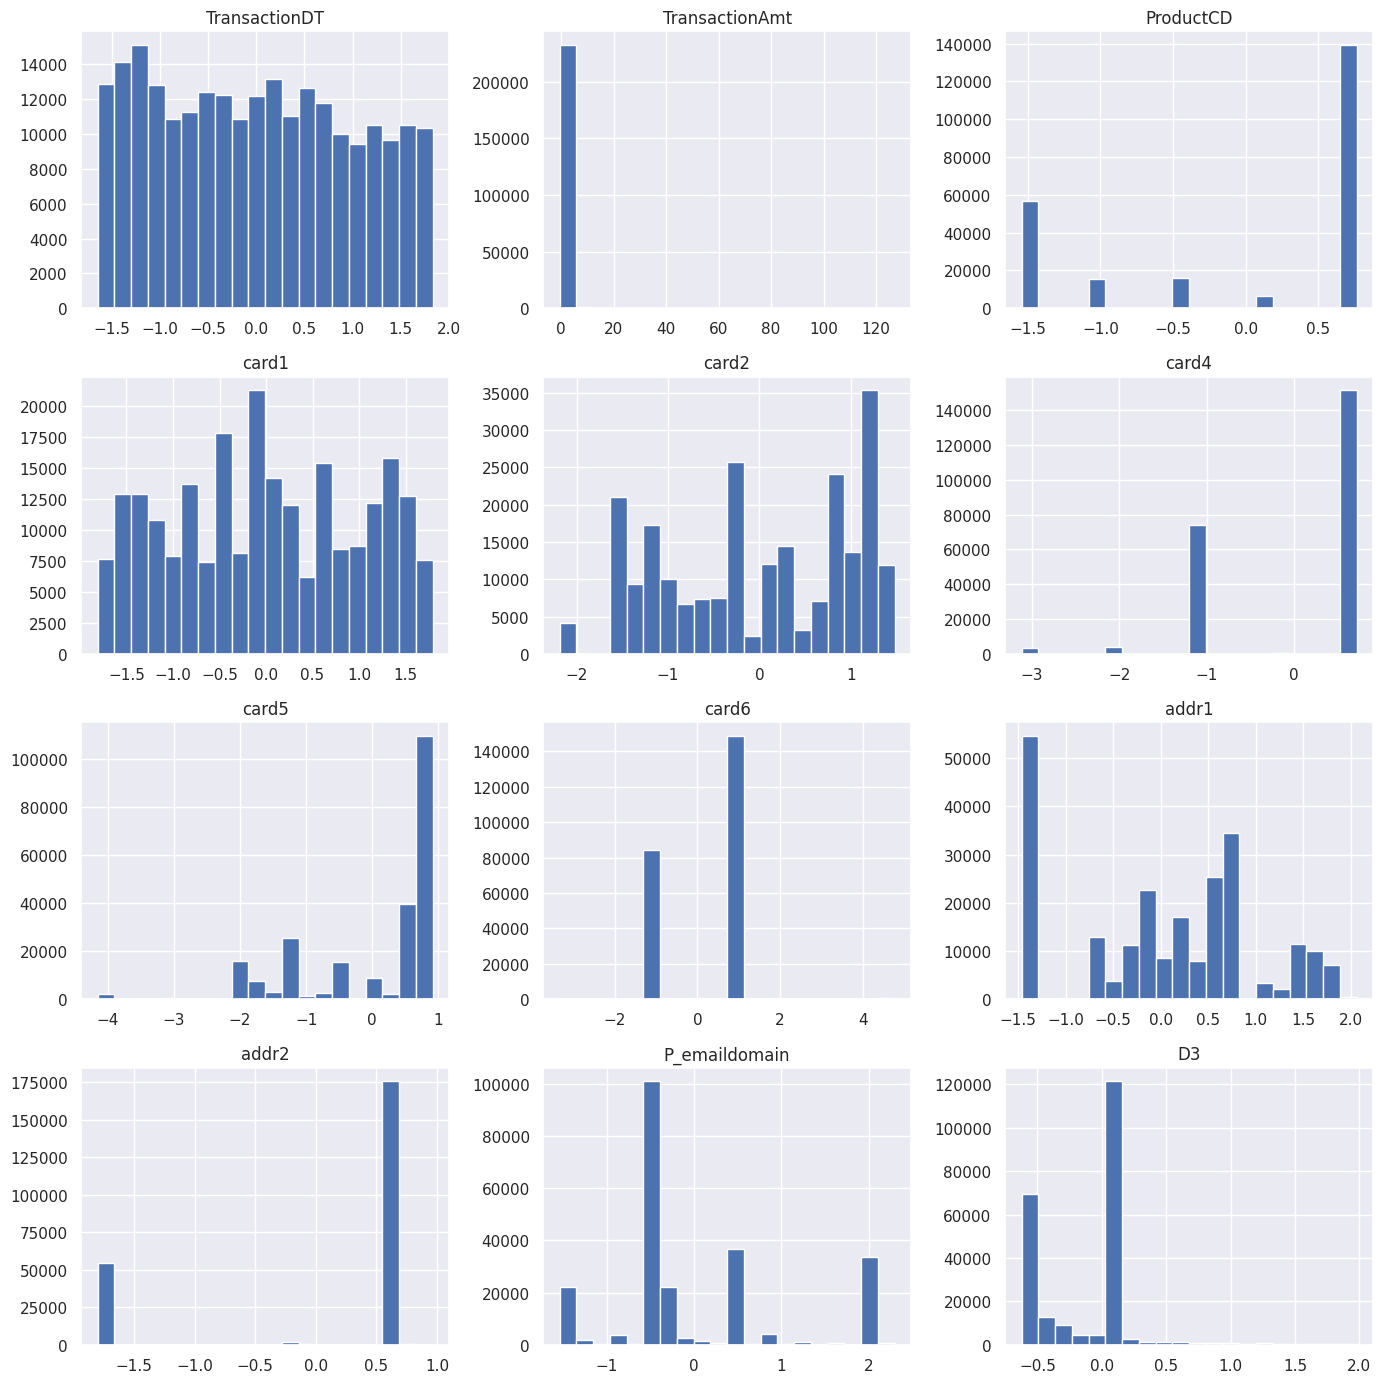

In [210]:
X_train_no_ems.hist(bins=20, figsize=(14,14))
plt.tight_layout()

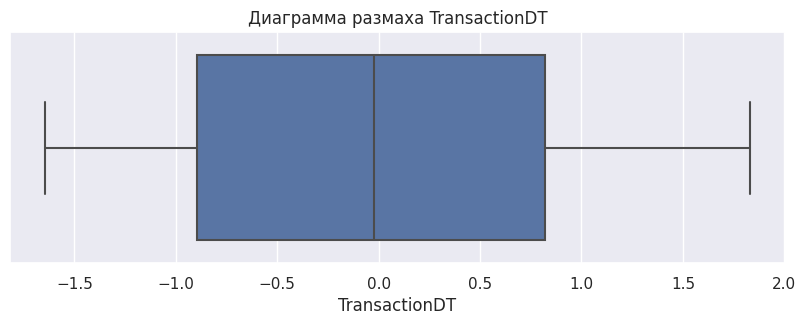

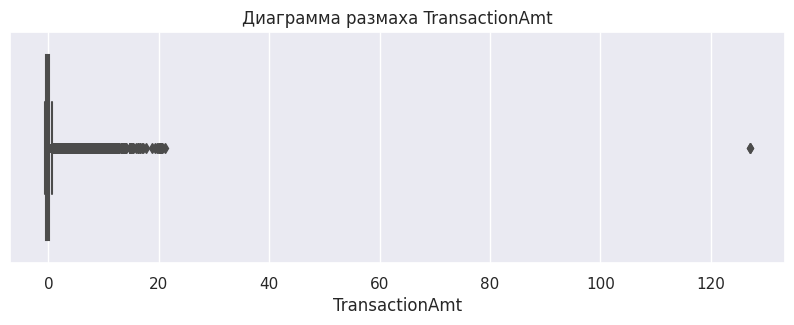

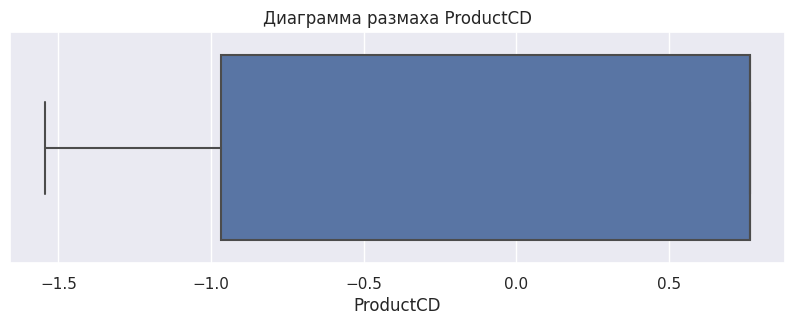

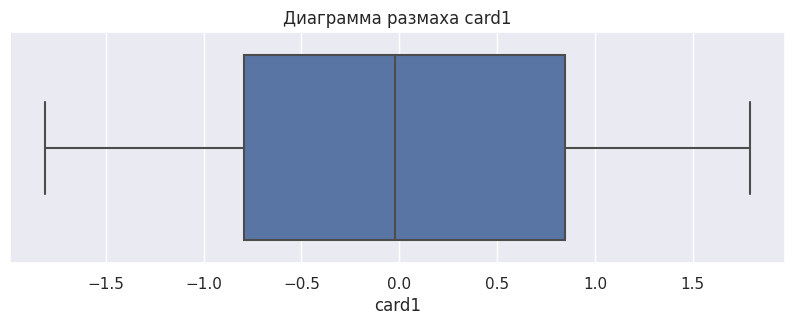

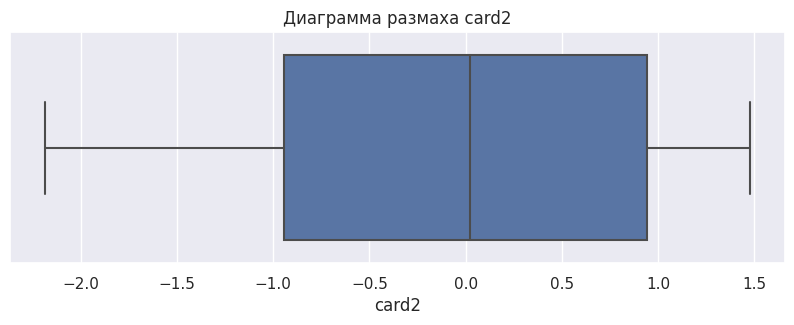

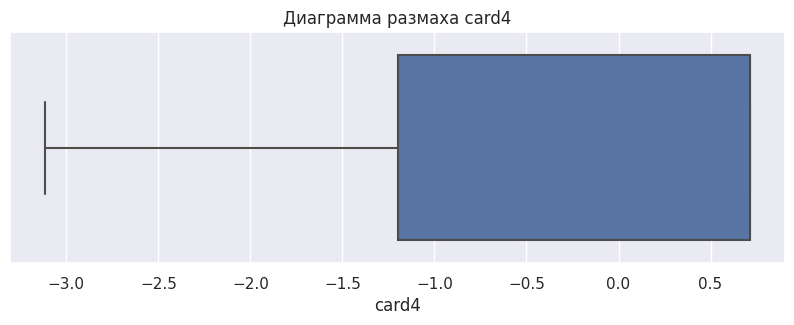

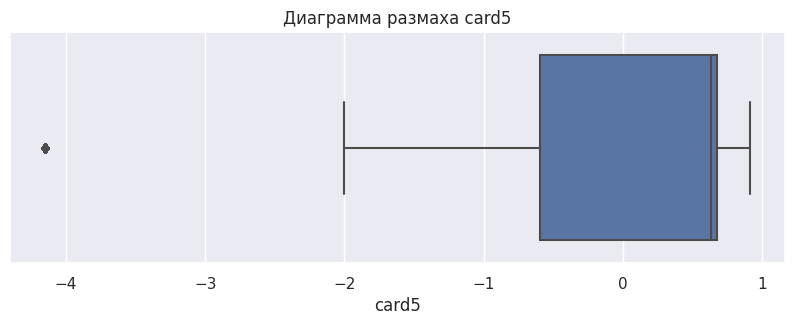

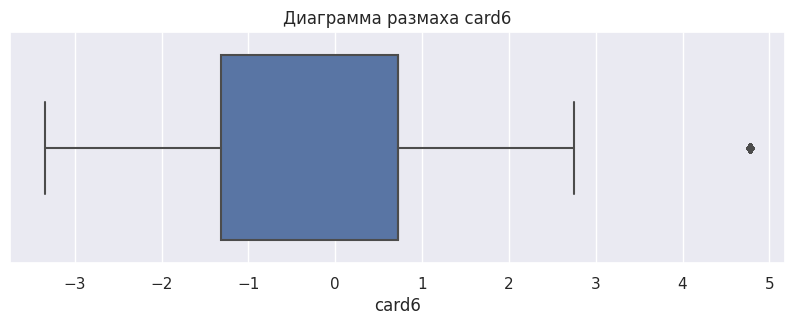

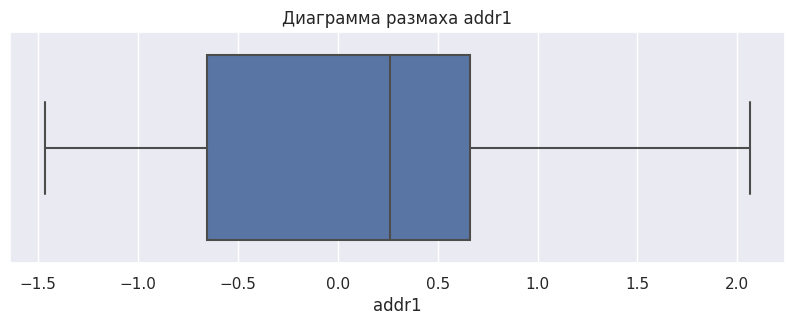

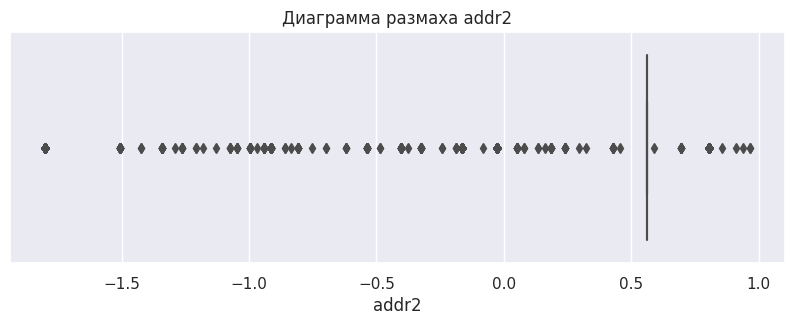

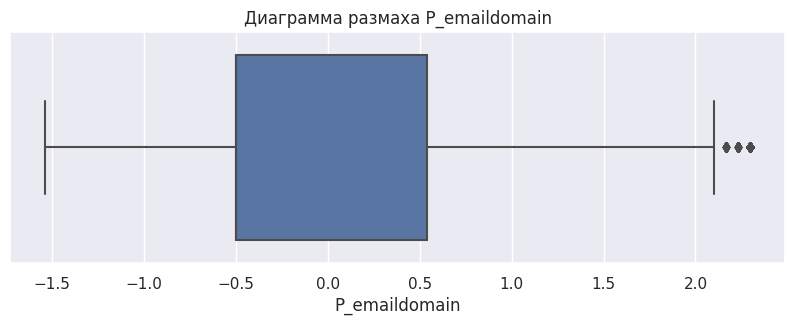

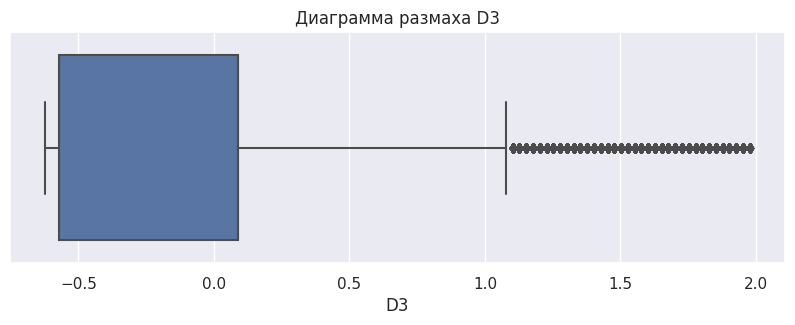

In [211]:
for feat in X_train_no_ems.columns:
    plt_boxplot(X_train_no_ems, feat)

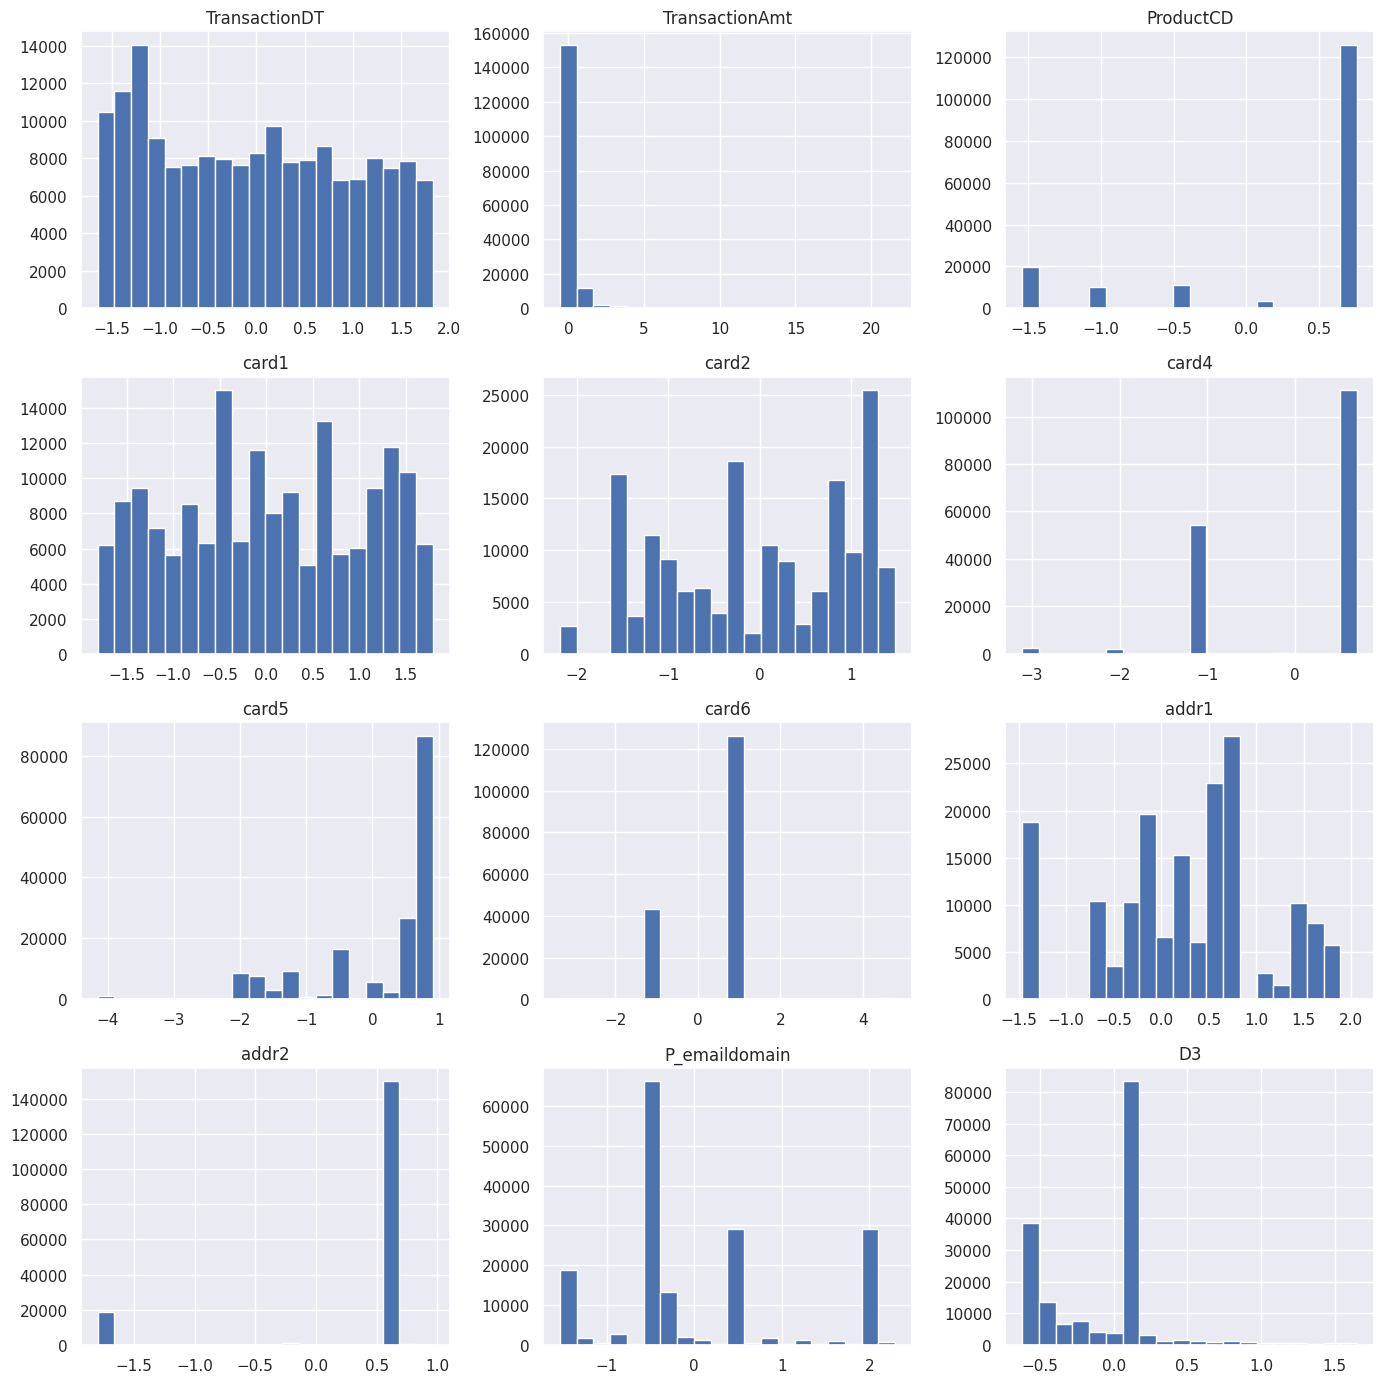

In [212]:
X_valid_no_ems.hist(bins=20, figsize=(14,14))
plt.tight_layout()

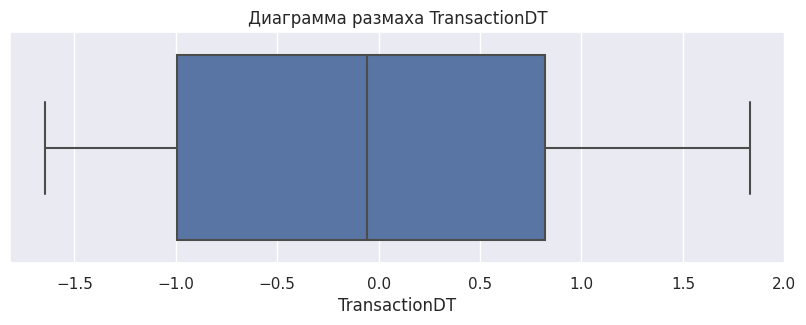

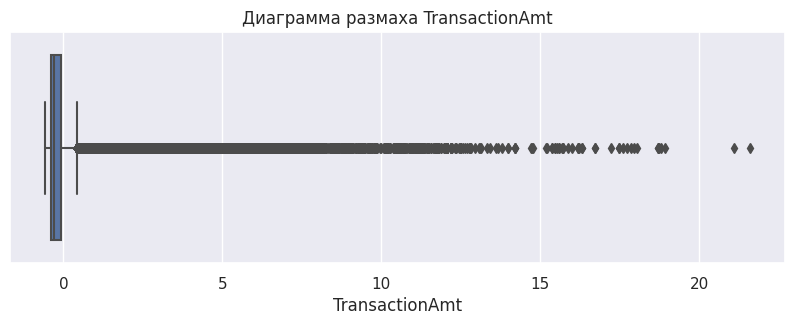

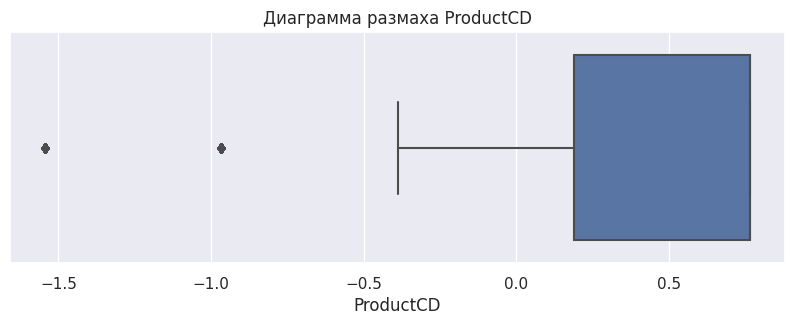

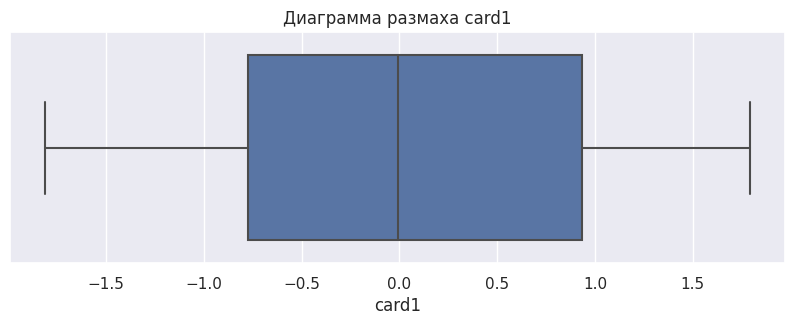

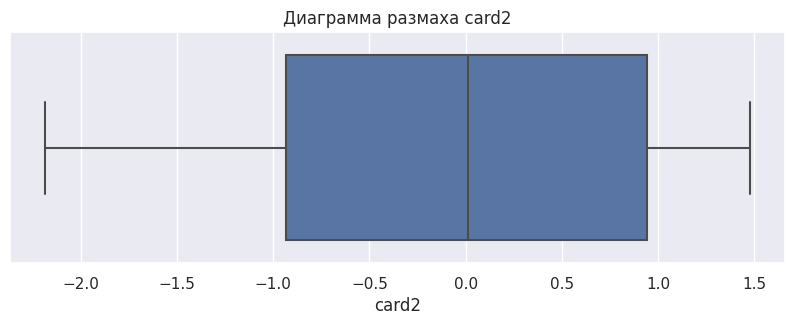

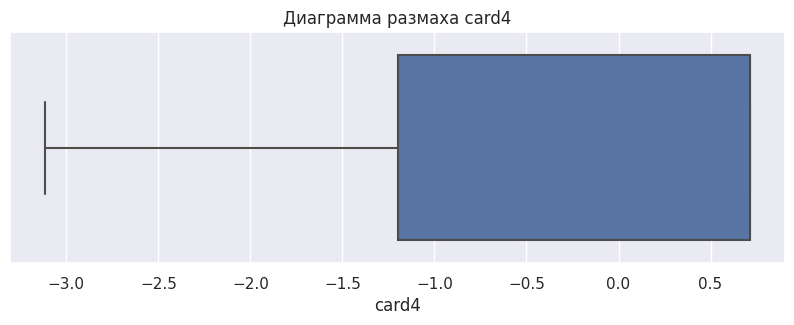

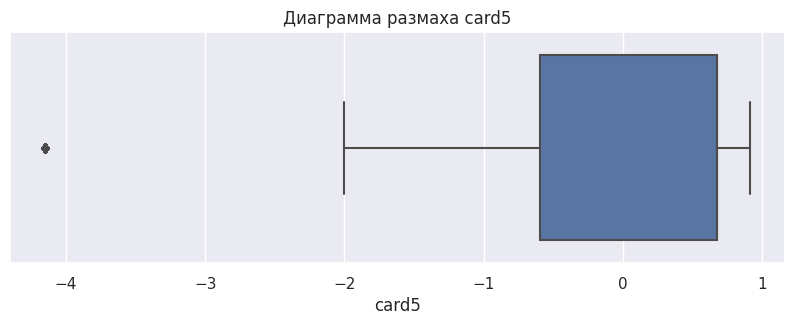

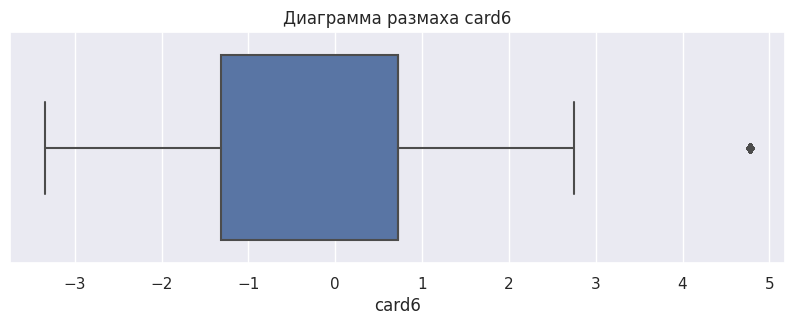

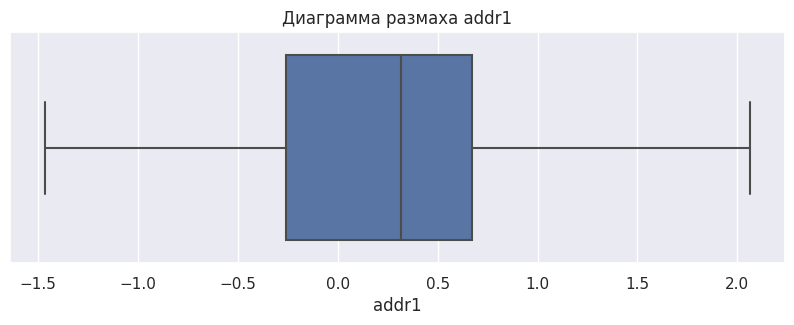

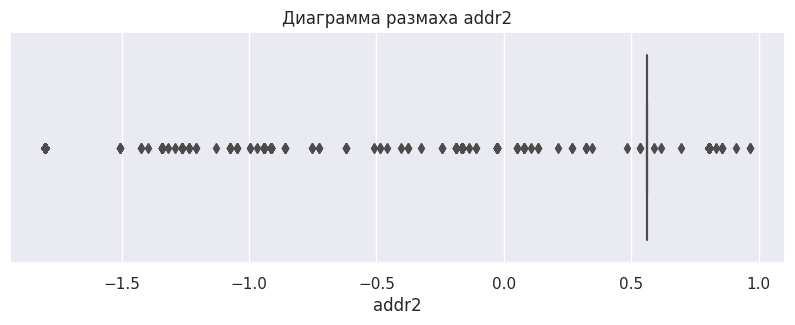

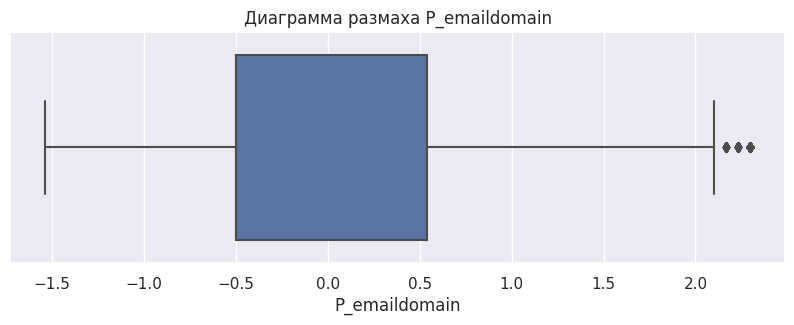

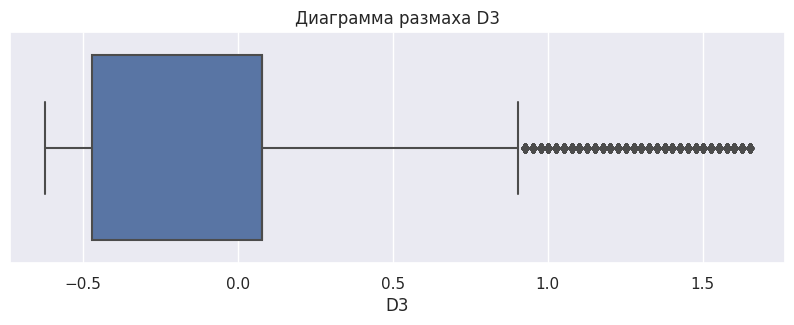

In [213]:
for feat in X_valid_no_ems.columns:
    plt_boxplot(X_valid_no_ems, feat)

Видим, что данные стали намного "чище" после очистки их от выбросов

#### Снова приступим к обучению моделей

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9305194881496539


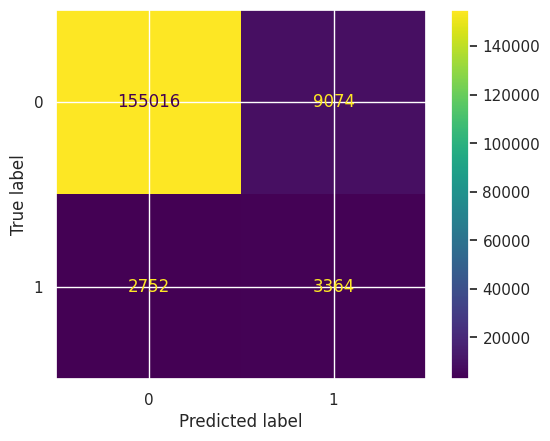

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    164090
           1       0.27      0.55      0.36      6116

    accuracy                           0.93    170206
   macro avg       0.63      0.75      0.66    170206
weighted avg       0.96      0.93      0.94    170206

roc auc score:  0.747366889894087


In [214]:
DT_no_ems, DT_no_ems_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
RF
Доля верно угаданных объектов 0.9658942692972046


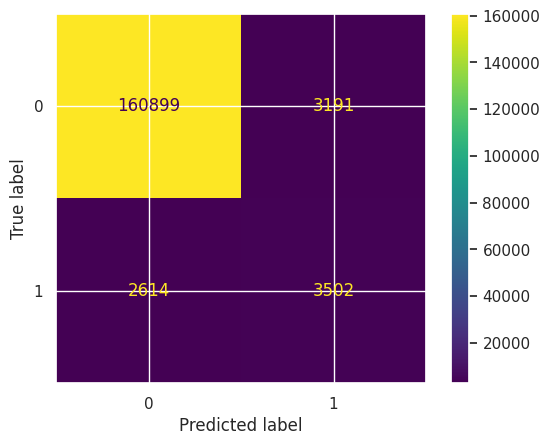

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    164090
           1       0.52      0.57      0.55      6116

    accuracy                           0.97    170206
   macro avg       0.75      0.78      0.76    170206
weighted avg       0.97      0.97      0.97    170206

roc auc score:  0.9140723317943411


In [215]:
RF_no_ems, RF_no_ems_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7731337320658496


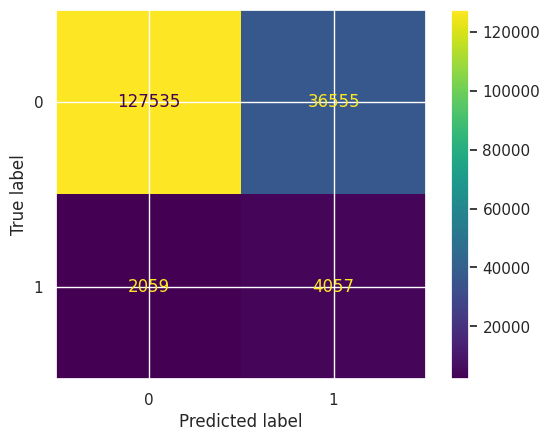

              precision    recall  f1-score   support

           0       0.98      0.78      0.87    164090
           1       0.10      0.66      0.17      6116

    accuracy                           0.77    170206
   macro avg       0.54      0.72      0.52    170206
weighted avg       0.95      0.77      0.84    170206

roc auc score:  0.7903023865374651


In [216]:
AdaBoost_no_ems, AdaBoost_no_ems_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
GradBoost
Доля верно угаданных объектов 0.75738223094368


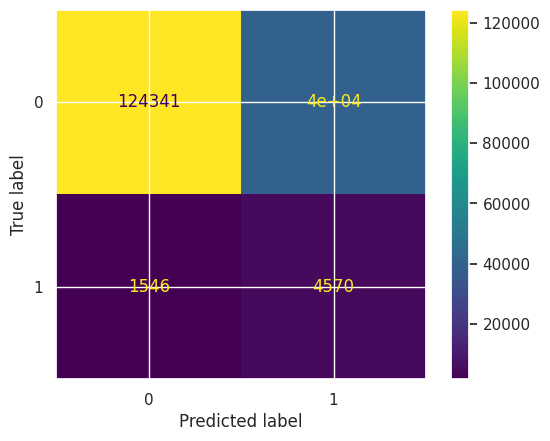

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    164090
           1       0.10      0.75      0.18      6116

    accuracy                           0.76    170206
   macro avg       0.55      0.75      0.52    170206
weighted avg       0.96      0.76      0.83    170206

roc auc score:  0.8243648946459817


In [217]:
GradBoost_no_ems, GradBoost_no_ems_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
XGB
Доля верно угаданных объектов 0.8595231660458503


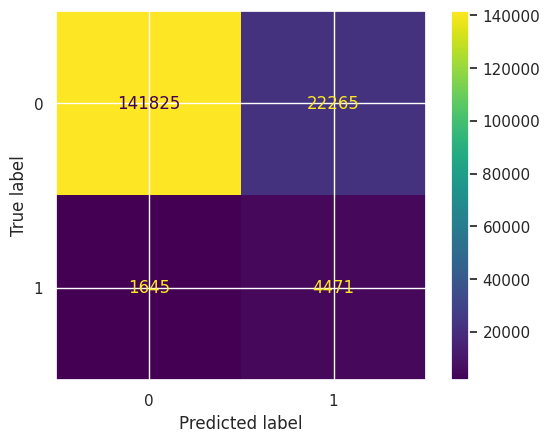

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    164090
           1       0.17      0.73      0.27      6116

    accuracy                           0.86    170206
   macro avg       0.58      0.80      0.60    170206
weighted avg       0.96      0.86      0.90    170206

roc auc score:  0.8783896165191294


In [218]:
XGB_no_ems, XGB_no_ems_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
LGBM
Доля верно угаданных объектов 0.827303385309566


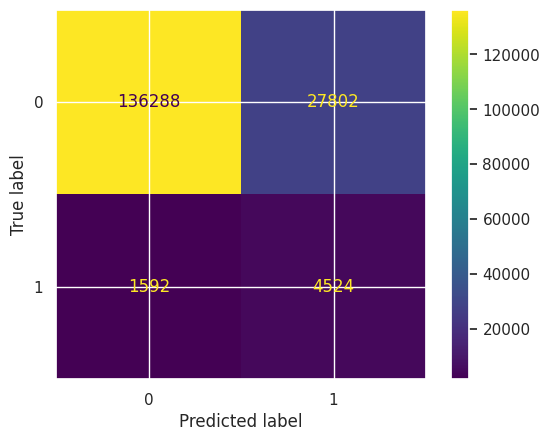

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    164090
           1       0.14      0.74      0.24      6116

    accuracy                           0.83    170206
   macro avg       0.56      0.79      0.57    170206
weighted avg       0.96      0.83      0.88    170206

roc auc score:  0.8600777153112827


In [219]:
LGBM_no_ems, LGBM_no_ems_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

Посмотрим на сравнение результатов ```roc auc score``` до очистки от выбросов и после

In [220]:
roc_auc_df3 = pd.DataFrame(data=[DT_no_ems_roc_auc, 
                                 RF_no_ems_roc_auc, 
                                 AdaBoost_no_ems_roc_auc,
                                 GradBoost_no_ems_roc_auc,
                                 XGB_no_ems_roc_auc,
                                 LGBM_no_ems_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score (no emmisions)'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df3], axis=1)
roc_auc_general

roc auc score  roc auc score (no emmisions)
DT             0.748016                      0.747367
RF             0.913293                      0.914072
AdaBoost       0.804542                      0.790302
GBM            0.829243                      0.824365
XGB            0.885779                      0.878390
LGBM           0.868412                      0.860078

Прогнозы в целом не улучшились, а значит следует поискать другие способы улучшения наших прогнозов

Напомню, что это прогнозы на валидационном датасете с дисбалансом классов, а значит это довольно хороший результат прогнозов

(array([119587.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 114144.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

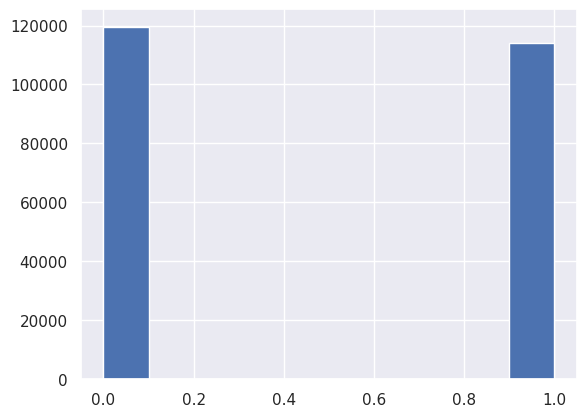

In [221]:
plt.hist(y_train_no_ems, label='train')

(array([164090.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   6116.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

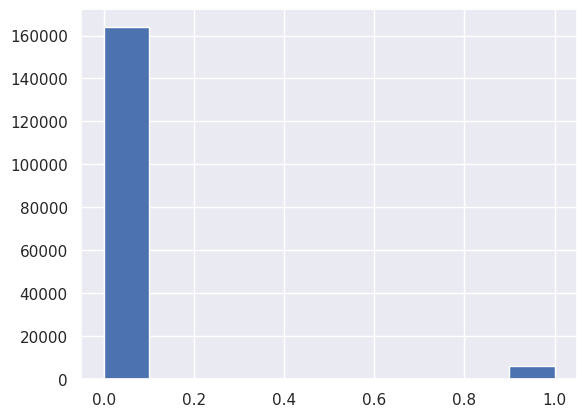

In [222]:
plt.hist(y_valid_no_ems, label='valid')

Но сперва попробуем сделать прогноз на тестовых данных и отправить submit на проверку на Kaggle

Напишем функцию для обучения модели и формирования отчета нужной формы для отправки

Посмотрим на образец формы для отправки

In [223]:
sample_submission.head(10)

TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
5        3663554      0.5
6        3663555      0.5
7        3663556      0.5
8        3663557      0.5
9        3663558      0.5

In [224]:
RF_no_ems.predict(test_df_sc)
y_pred_proba = RF_no_ems.predict_proba(test_df_sc)[:,1]
y_pred_proba

array([0.  , 0.09, 0.06, ..., 0.04, 0.03, 0.38])

In [225]:
transactionIDs_test

0         3663549
1         3663550
2         3663551
3         3663552
4         3663553
           ...   
506686    4170235
506687    4170236
506688    4170237
506689    4170238
506690    4170239
Name: TransactionID, Length: 506691, dtype: uint32

In [226]:
isFraud_df = pd.DataFrame(data=y_pred_proba,
                        index=transactionIDs_test.index,
                        columns=['isFraud'])
submit_df = pd.concat([transactionIDs_test, isFraud_df], axis=1)
submit_df

TransactionID  isFraud
0             3663549     0.00
1             3663550     0.09
2             3663551     0.06
3             3663552     0.16
4             3663553     0.02
...               ...      ...
506686        4170235     0.25
506687        4170236     0.18
506688        4170237     0.04
506689        4170238     0.03
506690        4170239     0.38

[506691 rows x 2 columns]

In [227]:
submit_df.to_csv('RandomForest.csv')

In [228]:
def fit_pred_final(model, model_name, test_data):
    model.predict(test_data)
    y_pred_proba = model.predict_proba(test_data)[:,1]
    submit_df = pd.DataFrame(data=[transactionIDs_test, y_pred_proba],
                             index=list(test_data.index),
                            columns=['TransactionID', 'isFraud'])
#     submit_df.to_csv('{}.csv'.format(model_name))
    return submit_df